In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


# Load the model

In [4]:
import numpy as np
import tensorflow as tf
from keras.models import model_from_json

tf.keras.mixed_precision.set_global_policy('mixed_float16')

model_path = "RBP_m6A_preference_CNN_model_DeepPScan"
keras_model_json = model_path + '.json'
keras_model_weights = model_path + '.h5'
my_model = model_from_json(open(keras_model_json).read())
my_model.load_weights(keras_model_weights)


In [5]:
my_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300, 20)]         0         
_________________________________________________________________
Conv1D_1 (Conv1D)            (None, 300, 512)          154112    
_________________________________________________________________
batch_normalization_8 (Batch (None, 300, 512)          2048      
_________________________________________________________________
activation_8 (Activation)    (None, 300, 512)          0         
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 100, 512)          0         
_________________________________________________________________
Conv1D_2 (Conv1D)            (None, 100, 256)          1179904   
_________________________________________________________________
batch_normalization_9 (Batch (None, 100, 256)          1024

# Prediction for all proteins that have undergone PRICE experiments

## Load data and preprocess

In [ ]:
aa_seq_ouput_len = 300
stride_len = 30

import numpy as np
from tensorflow.keras.utils import to_categorical
# one_hot_encode
def one_hot_encode(sequence, max_length=aa_seq_ouput_len):
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
    encoded = to_categorical([amino_acids.index(aa) for aa in sequence], num_classes=len(amino_acids), dtype="int")
    if len(encoded) < max_length:
        encoded = np.pad(encoded, ((0, max_length - len(encoded)), (0, 0)), 'constant')
    return encoded


In [ ]:
import pandas as pd
def process_input(file_path, out_seq_len=aa_seq_ouput_len, step_size=stride_len):
    df = pd.read_csv(file_path, sep="\t", header=None)
    protein_id_list = []
    protein_AAstr_list = []
    peptide_id_list = []
    peptide_AAstr_list = []
    new_AAseqStr_list = []
    for index, row in df.iterrows():
        protein_id = row[0]
        sequence = row[1]
        # 
        if len(sequence) > out_seq_len:
            for i in range(0, len(sequence)-out_seq_len+1, step_size):
                peptide_AAstr = sequence[i:i+out_seq_len]
                peptide_id = str(protein_id) + ':' + str(i+1)+ '-' + str(i+out_seq_len+1)
                protein_id_list.append(protein_id)
                protein_AAstr_list.append(sequence)
                peptide_id_list.append(peptide_id)
                peptide_AAstr_list.append(peptide_AAstr)
                new_AAseqStr_list.append(peptide_AAstr)
            # 
            if (len(sequence)-out_seq_len) % step_size != 0:
                peptide_AAstr = sequence[len(sequence)-out_seq_len:]
                peptide_id = str(protein_id) + ':' + str(len(sequence)-out_seq_len+1)+ '-' + str(len(sequence))
                protein_id_list.append(protein_id)
                protein_AAstr_list.append(sequence)
                peptide_id_list.append(peptide_id)
                peptide_AAstr_list.append(peptide_AAstr)
                new_AAseqStr_list.append(peptide_AAstr)
        else:
            protein_id_list.append(protein_id)
            protein_AAstr_list.append(sequence)
            peptide_id_list.append(protein_id)
            peptide_AAstr_list.append(sequence)
            new_AAseqStr_list.append(sequence)
    # 
    encoded_sequences = [one_hot_encode(aa_seq, out_seq_len) for aa_seq in new_AAseqStr_list]
    # 
    processed_df = pd.DataFrame({
        'protein_id': protein_id_list,
        'protein_AAstr': protein_AAstr_list,
        'peptide_id': peptide_id_list,
        'peptide_AAstr': peptide_AAstr_list,
        'encoded_AAstr': encoded_sequences,
    })
    return processed_df


In [ ]:
processed_df = process_input("2_all_proAAseq_for_predict.txt")
print(processed_df.shape)
processed_df.head()

(1426, 5)


,protein_id,protein_AAstr,peptide_id,peptide_AAstr,encoded_AAstr
0,1-ACIN1-1|RBD|112|0.49|0.37,SITIDDPVRTAQVPSPPRGKISNIVHISNLVRPFTLGQLKELLGRT...,1-ACIN1-1|RBD|112|0.49|0.37,SITIDDPVRTAQVPSPPRGKISNIVHISNLVRPFTLGQLKELLGRT...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,2-ACIN1-2|RBD|60|0.36|0.08,AELEEVTLDGKPLQALRVTDLKAALEQRGLAKSGQKSALVKRLKGA...,2-ACIN1-2|RBD|60|0.36|0.08,AELEEVTLDGKPLQALRVTDLKAALEQRGLAKSGQKSALVKRLKGA...,"[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,3-ACO1-1|RBD|527|0.87|0.81,IRNCDEFLVKKQDIENILHWNVTQHKNIEVPFKPARVILQDFTGVP...,3-ACO1-1|RBD|527|0.87|0.81:1-301,IRNCDEFLVKKQDIENILHWNVTQHKNIEVPFKPARVILQDFTGVP...,"[[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,..."
3,3-ACO1-1|RBD|527|0.87|0.81,IRNCDEFLVKKQDIENILHWNVTQHKNIEVPFKPARVILQDFTGVP...,3-ACO1-1|RBD|527|0.87|0.81:31-331,PFKPARVILQDFTGVPAVVDFAAMRDAVKKLGGDPEKINPVCPADL...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,..."
4,3-ACO1-1|RBD|527|0.87|0.81,IRNCDEFLVKKQDIENILHWNVTQHKNIEVPFKPARVILQDFTGVP...,3-ACO1-1|RBD|527|0.87|0.81:61-361,LGGDPEKINPVCPADLVIDHSIQVDFNRRADSLQKNQDLEFERNRE...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,..."


## Extract features and labels

In [ ]:
# Extract features and labels
X =  np.array(processed_df['encoded_AAstr'].tolist())
print(X.shape)
X

(1426, 300, 20)


array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

## Prediction

In [ ]:
# 
with tf.device('/GPU:0'):
    pred = my_model.predict(X)
    print(pred.shape)
    pred


(1426, 1)


In [43]:
pred.flatten().tolist()

[-1.2840824127197266,
 -2.8257572650909424,
 -0.2452157735824585,
 -0.14788009226322174,
 -0.2126772105693817,
 -0.20024248957633972,
 -0.23340843617916107,
 -0.2164989411830902,
 -0.21401144564151764,
 -0.11615227162837982,
 -0.28645414113998413,
 0.7973219156265259,
 -2.0615906715393066,
 -2.70114803314209,
 -2.609571695327759,
 -2.5983588695526123,
 -2.644099473953247,
 -2.521305799484253,
 -2.820303201675415,
 -2.714576482772827,
 -1.4958844184875488,
 -2.5248782634735107,
 -1.8743013143539429,
 -2.8500630855560303,
 -2.0766208171844482,
 -2.6211822032928467,
 -2.841049909591675,
 -2.9197847843170166,
 -2.5055599212646484,
 -2.8671023845672607,
 -2.6085782051086426,
 -2.7106845378875732,
 -2.535748243331909,
 -0.6561248302459717,
 -0.39294207096099854,
 -0.9629287719726562,
 -0.09858214855194092,
 -1.3564690351486206,
 -1.4465994834899902,
 -1.4170525074005127,
 -1.3130154609680176,
 -1.2941458225250244,
 -1.2731654644012451,
 -0.1462387889623642,
 0.00965234637260437,
 -2.25541830

## Add prediction results

In [ ]:
processed_df["predict_m6A_log2OR"] = pred.flatten().tolist()
processed_df.head()

,protein_id,protein_AAstr,peptide_id,peptide_AAstr,encoded_AAstr,predict_m6A_log2OR
0,1-ACIN1-1|RBD|112|0.49|0.37,SITIDDPVRTAQVPSPPRGKISNIVHISNLVRPFTLGQLKELLGRT...,1-ACIN1-1|RBD|112|0.49|0.37,SITIDDPVRTAQVPSPPRGKISNIVHISNLVRPFTLGQLKELLGRT...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",-1.284082
1,2-ACIN1-2|RBD|60|0.36|0.08,AELEEVTLDGKPLQALRVTDLKAALEQRGLAKSGQKSALVKRLKGA...,2-ACIN1-2|RBD|60|0.36|0.08,AELEEVTLDGKPLQALRVTDLKAALEQRGLAKSGQKSALVKRLKGA...,"[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",-2.825757
2,3-ACO1-1|RBD|527|0.87|0.81,IRNCDEFLVKKQDIENILHWNVTQHKNIEVPFKPARVILQDFTGVP...,3-ACO1-1|RBD|527|0.87|0.81:1-301,IRNCDEFLVKKQDIENILHWNVTQHKNIEVPFKPARVILQDFTGVP...,"[[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,...",-0.245216
3,3-ACO1-1|RBD|527|0.87|0.81,IRNCDEFLVKKQDIENILHWNVTQHKNIEVPFKPARVILQDFTGVP...,3-ACO1-1|RBD|527|0.87|0.81:31-331,PFKPARVILQDFTGVPAVVDFAAMRDAVKKLGGDPEKINPVCPADL...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,...",-0.147880
4,3-ACO1-1|RBD|527|0.87|0.81,IRNCDEFLVKKQDIENILHWNVTQHKNIEVPFKPARVILQDFTGVP...,3-ACO1-1|RBD|527|0.87|0.81:61-361,LGGDPEKINPVCPADLVIDHSIQVDFNRRADSLQKNQDLEFERNRE...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,...",-0.212677


In [ ]:
processed_df = processed_df.drop("encoded_AAstr", axis=1)
processed_df.to_csv("2_all_proAAseq_for_predict.peptide_wtih_log2OR.xls", sep="\t", header=True, index=False)
print(processed_df.shape)
processed_df.head()

(1426, 5)


,protein_id,protein_AAstr,peptide_id,peptide_AAstr,predict_m6A_log2OR
0,1-ACIN1-1|RBD|112|0.49|0.37,SITIDDPVRTAQVPSPPRGKISNIVHISNLVRPFTLGQLKELLGRT...,1-ACIN1-1|RBD|112|0.49|0.37,SITIDDPVRTAQVPSPPRGKISNIVHISNLVRPFTLGQLKELLGRT...,-1.284082
1,2-ACIN1-2|RBD|60|0.36|0.08,AELEEVTLDGKPLQALRVTDLKAALEQRGLAKSGQKSALVKRLKGA...,2-ACIN1-2|RBD|60|0.36|0.08,AELEEVTLDGKPLQALRVTDLKAALEQRGLAKSGQKSALVKRLKGA...,-2.825757
2,3-ACO1-1|RBD|527|0.87|0.81,IRNCDEFLVKKQDIENILHWNVTQHKNIEVPFKPARVILQDFTGVP...,3-ACO1-1|RBD|527|0.87|0.81:1-301,IRNCDEFLVKKQDIENILHWNVTQHKNIEVPFKPARVILQDFTGVP...,-0.245216
3,3-ACO1-1|RBD|527|0.87|0.81,IRNCDEFLVKKQDIENILHWNVTQHKNIEVPFKPARVILQDFTGVP...,3-ACO1-1|RBD|527|0.87|0.81:31-331,PFKPARVILQDFTGVPAVVDFAAMRDAVKKLGGDPEKINPVCPADL...,-0.147880
4,3-ACO1-1|RBD|527|0.87|0.81,IRNCDEFLVKKQDIENILHWNVTQHKNIEVPFKPARVILQDFTGVP...,3-ACO1-1|RBD|527|0.87|0.81:61-361,LGGDPEKINPVCPADLVIDHSIQVDFNRRADSLQKNQDLEFERNRE...,-0.212677


## Construct the maximum log2OR result for each protein

In [ ]:
# For each protein, take the maximum log2OR value from the prediction results of all peptide segments.
idx = processed_df.groupby('protein_id')['predict_m6A_log2OR'].idxmax()
protein_result_df = processed_df.loc[idx].reset_index(drop=True)
protein_result_df.to_csv("2_all_proAAseq_for_predict.protein_max_log2OR.xls", sep="\t", header=True, index=False)
print(protein_result_df.shape)
protein_result_df.head()


(351, 5)


,protein_id,protein_AAstr,peptide_id,peptide_AAstr,predict_m6A_log2OR
0,1-ACIN1-1|RBD|112|0.49|0.37,SITIDDPVRTAQVPSPPRGKISNIVHISNLVRPFTLGQLKELLGRT...,1-ACIN1-1|RBD|112|0.49|0.37,SITIDDPVRTAQVPSPPRGKISNIVHISNLVRPFTLGQLKELLGRT...,-1.284082
1,10-ANKHD1|Full|435|0.90|0.21,MKAENSHNAGQVDTRSLAEACSDGDVNAVRKLLDEGRSVNEHTEEG...,10-ANKHD1|Full|435|0.90|0.21:136-435,GANIEDHNENGHTPLMEAASAGHVEVARVLLDHGAGINTHSNEFKE...,-1.273165
2,100-LSM4|Full|139|0.25|0.26,MLPLSLLKTAQNHPMLVELKNGETYNGHLVSCDNWMNINLREVICT...,100-LSM4|Full|139|0.25|0.26,MLPLSLLKTAQNHPMLVELKNGETYNGHLVSCDNWMNINLREVICT...,-2.076526
3,101-LSM5|Full|91|0.16|0.25,MAANATTNPSQLLPLELVDKCIGSRIHIVMKSDKEIVGTLLGFDDF...,101-LSM5|Full|91|0.16|0.25,MAANATTNPSQLLPLELVDKCIGSRIHIVMKSDKEIVGTLLGFDDF...,-1.057731
4,102-LSM7|Full|103|0.14|0.57,MADKEKKKKESILDLSKYIDKTIRVKFQGGREASGILKGFDPLLNL...,102-LSM7|Full|103|0.14|0.57,MADKEKKKKESILDLSKYIDKTIRVKFQGGREASGILKGFDPLLNL...,-1.215492


## Calculate the Spearman correlation between the actual log2OR and the predicted log2OR

In [ ]:
protein_result_df.protein_id.values[0].split('|')[3:5]

['0.49', '0.37']

In [ ]:
import numpy as np
from scipy.stats import spearmanr
real_log2OR = []
for info in protein_result_df.protein_id.values:
    x, y = info.split('|')[3:5]
    # print(type(x),type(y))
    real_log2OR.append((np.log2(float(x)) + np.log2(float(y)))/2)

pred_log2OR = protein_result_df.predict_m6A_log2OR.values.tolist()
spr, pv = spearmanr(real_log2OR, pred_log2OR)
print("spearmanr: ", spr)
print("p_value: ", pv)

spearmanr:  0.8824311066172429
p_value:  2.4473435399178638e-116


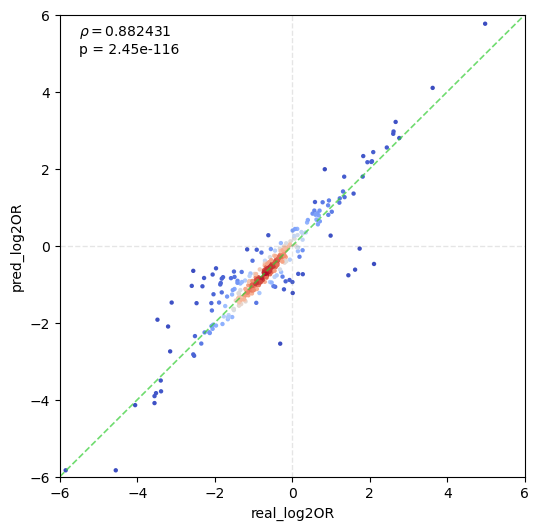

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, gaussian_kde

rho, pval = spearmanr(real_log2OR, pred_log2OR)
xy = np.vstack([real_log2OR, pred_log2OR])
kde = gaussian_kde(xy)(xy)

fig = plt.figure(figsize=(6, 6))
# ax1
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot([-6, 6], [-6, 6], ls='--', lw=1.2, c="limegreen", alpha=0.7)
ax1.hlines(0, -6, 6,  ls='--', lw=1, colors="grey", alpha=0.2)
ax1.vlines(0, -6, 6,  ls='--', lw=1, colors="grey", alpha=0.2)
ax1.scatter(x=real_log2OR, y=pred_log2OR, s=10, c=kde, cmap='coolwarm', edgecolors='none')
ax1.text(-5.5, 5, r'$\rho = $'+str(format(rho, '.6f')+"\np = "+str(format(pval, '.2e'))))
ax1.set_xlim(-6, 6)
ax1.set_ylim(-6, 6)
ax1.set_xlabel("real_log2OR")
ax1.set_ylabel("pred_log2OR")

fig.savefig('all_351_protein_real_and_predicted_m6A_log2OR_scatter_plot.colour_use_kde.pdf')
plt.show()


## Calculate the Pearson correlation between the actual log2OR and the predicted log2OR

In [ ]:
import pandas as pd
protein_result_df = pd.read_csv("2_all_proAAseq_for_predict.protein_max_log2OR.xls", sep="\t", header=0)
print(protein_result_df.shape)
protein_result_df.head()


(351, 5)


,protein_id,protein_AAstr,peptide_id,peptide_AAstr,predict_m6A_log2OR
0,1-ACIN1-1|RBD|112|0.49|0.37,SITIDDPVRTAQVPSPPRGKISNIVHISNLVRPFTLGQLKELLGRT...,1-ACIN1-1|RBD|112|0.49|0.37,SITIDDPVRTAQVPSPPRGKISNIVHISNLVRPFTLGQLKELLGRT...,-1.284082
1,10-ANKHD1|Full|435|0.90|0.21,MKAENSHNAGQVDTRSLAEACSDGDVNAVRKLLDEGRSVNEHTEEG...,10-ANKHD1|Full|435|0.90|0.21:136-435,GANIEDHNENGHTPLMEAASAGHVEVARVLLDHGAGINTHSNEFKE...,-1.273165
2,100-LSM4|Full|139|0.25|0.26,MLPLSLLKTAQNHPMLVELKNGETYNGHLVSCDNWMNINLREVICT...,100-LSM4|Full|139|0.25|0.26,MLPLSLLKTAQNHPMLVELKNGETYNGHLVSCDNWMNINLREVICT...,-2.076526
3,101-LSM5|Full|91|0.16|0.25,MAANATTNPSQLLPLELVDKCIGSRIHIVMKSDKEIVGTLLGFDDF...,101-LSM5|Full|91|0.16|0.25,MAANATTNPSQLLPLELVDKCIGSRIHIVMKSDKEIVGTLLGFDDF...,-1.057731
4,102-LSM7|Full|103|0.14|0.57,MADKEKKKKESILDLSKYIDKTIRVKFQGGREASGILKGFDPLLNL...,102-LSM7|Full|103|0.14|0.57,MADKEKKKKESILDLSKYIDKTIRVKFQGGREASGILKGFDPLLNL...,-1.215492


In [ ]:
protein_result_df.protein_id.values[0].split('|')[3:5]

['0.49', '0.37']

In [ ]:
import numpy as np
from scipy.stats import pearsonr
real_log2OR = []
for info in protein_result_df.protein_id.values:
    x, y = info.split('|')[3:5]
    # print(type(x),type(y))
    real_log2OR.append((np.log2(float(x)) + np.log2(float(y)))/2)

pred_log2OR = protein_result_df.predict_m6A_log2OR.values.tolist()
psr, pv = pearsonr(real_log2OR, pred_log2OR)
print("pearsonr: ", psr)
print("p_value: ", pv)

pearsonr:  0.9397375607155188
p_value:  9.690487357406084e-165


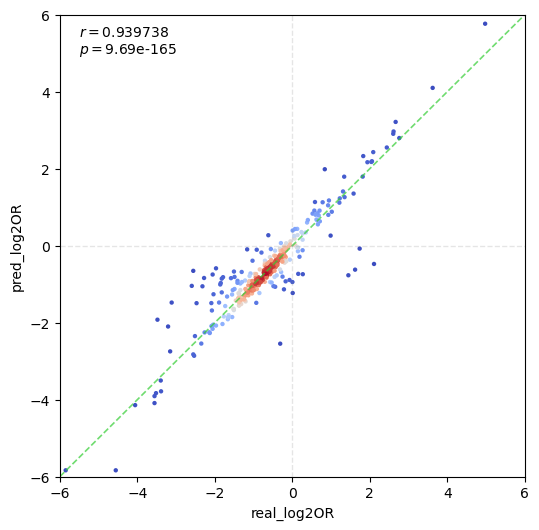

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, gaussian_kde

psr, pval = pearsonr(real_log2OR, pred_log2OR)
xy = np.vstack([real_log2OR, pred_log2OR])
kde = gaussian_kde(xy)(xy)

fig = plt.figure(figsize=(6, 6))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot([-6, 6], [-6, 6], ls='--', lw=1.2, c="limegreen", alpha=0.7)
ax1.hlines(0, -6, 6,  ls='--', lw=1, colors="grey", alpha=0.2)
ax1.vlines(0, -6, 6,  ls='--', lw=1, colors="grey", alpha=0.2)
ax1.scatter(x=real_log2OR, y=pred_log2OR, s=10, c=kde, cmap='coolwarm', edgecolors='none')
ax1.text(-5.5, 5, r'$r = $'+str(format(psr, '.6f')+"\n$p = $"+str(format(pval, '.2e'))))
ax1.set_xlim(-6, 6)
ax1.set_ylim(-6, 6)
ax1.set_xlabel("real_log2OR")
ax1.set_ylabel("pred_log2OR")

fig.savefig('all_351_protein_real_and_predicted_m6A_log2OR_scatter_plot.colour_use_kde.pcc.pdf')
plt.show()


In [ ]:
# Define a function to preprocess the input sequence for subsequent predictions
import pandas as pd
aa_seq_ouput_len = 300
stride_len = 30
def process_input(file_path, out_seq_len=aa_seq_ouput_len, step_size=stride_len):
    df = pd.read_csv(file_path, sep="\t", header=None)
    protein_id_list = []
    protein_AAstr_list = []
    peptide_id_list = []
    peptide_AAstr_list = []
    new_AAseqStr_list = []
    for index, row in df.iterrows():
        protein_id = row[0]
        sequence = row[1]
        if len(sequence) > out_seq_len:
            for i in range(0, len(sequence)-out_seq_len+1, step_size):
                peptide_AAstr = sequence[i:i+out_seq_len]
                peptide_id = str(protein_id) + ':' + str(i+1)+ '-' + str(i+out_seq_len+1)
                protein_id_list.append(protein_id)
                protein_AAstr_list.append(sequence)
                peptide_id_list.append(peptide_id)
                peptide_AAstr_list.append(peptide_AAstr)
                new_AAseqStr_list.append(peptide_AAstr)
            if (len(sequence)-out_seq_len) % step_size != 0:
                peptide_AAstr = sequence[len(sequence)-out_seq_len:]
                peptide_id = str(protein_id) + ':' + str(len(sequence)-out_seq_len+1)+ '-' + str(len(sequence))
                protein_id_list.append(protein_id)
                protein_AAstr_list.append(sequence)
                peptide_id_list.append(peptide_id)
                peptide_AAstr_list.append(peptide_AAstr)
                new_AAseqStr_list.append(peptide_AAstr)
        else:
            protein_id_list.append(protein_id)
            protein_AAstr_list.append(sequence)
            peptide_id_list.append(protein_id)
            peptide_AAstr_list.append(sequence)
            new_AAseqStr_list.append(sequence)
    encoded_sequences = [one_hot_encode(aa_seq, out_seq_len) for aa_seq in new_AAseqStr_list]
    # 
    processed_df = pd.DataFrame({
        'protein_id': protein_id_list,
        'protein_AAstr': protein_AAstr_list,
        'peptide_id': peptide_id_list,
        'peptide_AAstr': peptide_AAstr_list,
        'encoded_AAstr': encoded_sequences,
    })
    return processed_df


# Prediction of the m6A preference score for all human proteins

## Download of protein sequence data and format reshape

In [ ]:
%%bash
# # https://www.ensembl.org/index.html
# # ensembl biomart
# # hg38 : filters None
# # Attributes: [Gene name; Gene stable ID; Transcript stable ID; Protein stable ID; Peptide] 
# # Download the complete protein sequence FASTA file of hg38
# # https://ftp.ensembl.org/pub/release-113/fasta/homo_sapiens/pep/Homo_sapiens.GRCh38.pep.all.fa.gz
# # or https://ftp.ebi.ac.uk/ensemblgenomes/pub/current/vertebrates/fasta/homo_sapiens/pep/Homo_sapiens.GRCh38.pep.all.fa.gz
# # Use a custom script to convert the original protein sequence into a two-column format of "id \tab seq" for prediction purposes.
# nohup python convert_protein_fasta_to_id_AAstr_for_predict.py -f Homo_sapiens.GRCh38.pep.all.fa -o Homo_sapiens.GRCh38.pep.all.fa.reshaped_for_predict.txt >Homo_sapiens.GRCh38.pep.all.fa.convert.runlog 2>&1 & 
# tail -f Homo_sapiens.GRCh38.pep.all.fa.convert.runlog

head Homo_sapiens.GRCh38.pep.all.fa.reshaped_for_predict.txt

TRDJ1|ENSG00000211825|ENST00000390473|ENSP00000452345	TDKLIFGKGTRVTVEP
TRAJ54|ENSG00000211836|ENST00000390484|ENSP00000452564	IQGAQKLVFGQGTRLTINP
TRAJ49|ENSG00000211840|ENST00000390488|ENSP00000451657	NTGNQFYFGTGTSLTVIP
TRDJ3|ENSG00000211828|ENST00000390476|ENSP00000451140	SWDTRQMFFGTGIKLFVEP
TRAJ48|ENSG00000211841|ENST00000390489|ENSP00000450777	SNFGNEKLTFGTGTRLTIIP
TRAJ59|ENSG00000211832|ENST00000390480|ENSP00000451065	KEGNRKFTFGMGTQVRV
TRAJ61|ENSG00000211831|ENST00000390479|ENSP00000452464	YRVNRKLTFGANTRGIMKL
TRDJ4|ENSG00000211826|ENST00000390474|ENSP00000452040	RPLIFGKGTYLEVQQ
TRAJ47|ENSG00000211842|ENST00000390490|ENSP00000451749	EYGNKLVFGAGTILRVKS
TRDJ2|ENSG00000211827|ENST00000390475|ENSP00000450875	LTAQLFFGKGTQLIVEP


## Load all human protein sequences and perform preprocessing

In [58]:
df = pd.read_csv("Homo_sapiens.GRCh38.pep.all.fa.reshaped_for_predict.txt", sep="\t", header=None)
print(df.shape)
df.head()

(123586, 2)


,0,1
0,TRDJ1|ENSG00000211825|ENST00000390473|ENSP0000...,TDKLIFGKGTRVTVEP
1,TRAJ54|ENSG00000211836|ENST00000390484|ENSP000...,IQGAQKLVFGQGTRLTINP
2,TRAJ49|ENSG00000211840|ENST00000390488|ENSP000...,NTGNQFYFGTGTSLTVIP
3,TRDJ3|ENSG00000211828|ENST00000390476|ENSP0000...,SWDTRQMFFGTGIKLFVEP
4,TRAJ48|ENSG00000211841|ENST00000390489|ENSP000...,SNFGNEKLTFGTGTRLTIIP


In [ ]:
processed_df = process_input("Homo_sapiens.GRCh38.pep.all.fa.reshaped_for_predict.txt")
print(processed_df.shape)
processed_df.head()


(613854, 5)


,protein_id,protein_AAstr,peptide_id,peptide_AAstr,encoded_AAstr
0,TRDJ1|ENSG00000211825|ENST00000390473|ENSP0000...,TDKLIFGKGTRVTVEP,TRDJ1|ENSG00000211825|ENST00000390473|ENSP0000...,TDKLIFGKGTRVTVEP,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,TRAJ54|ENSG00000211836|ENST00000390484|ENSP000...,IQGAQKLVFGQGTRLTINP,TRAJ54|ENSG00000211836|ENST00000390484|ENSP000...,IQGAQKLVFGQGTRLTINP,"[[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,..."
2,TRAJ49|ENSG00000211840|ENST00000390488|ENSP000...,NTGNQFYFGTGTSLTVIP,TRAJ49|ENSG00000211840|ENST00000390488|ENSP000...,NTGNQFYFGTGTSLTVIP,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,..."
3,TRDJ3|ENSG00000211828|ENST00000390476|ENSP0000...,SWDTRQMFFGTGIKLFVEP,TRDJ3|ENSG00000211828|ENST00000390476|ENSP0000...,SWDTRQMFFGTGIKLFVEP,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,TRAJ48|ENSG00000211841|ENST00000390489|ENSP000...,SNFGNEKLTFGTGTRLTIIP,TRAJ48|ENSG00000211841|ENST00000390489|ENSP000...,SNFGNEKLTFGTGTRLTIIP,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


## feature extraction

In [ ]:
X =  np.array(processed_df['encoded_AAstr'].tolist())
print(X.shape)
X

(613854, 300, 20)


array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

## prediction

In [ ]:
with tf.device('/GPU:0'):
    pred = my_model.predict(X)
    print(pred.shape)
    pred


(613854, 1)


In [62]:
pred.flatten().tolist()

[-0.05596923828125,
 0.12420654296875,
 -0.147705078125,
 -0.0242919921875,
 0.04510498046875,
 0.11859130859375,
 0.291259765625,
 0.11236572265625,
 0.158447265625,
 -0.01263427734375,
 0.1787109375,
 0.0084228515625,
 -0.06451416015625,
 0.04608154296875,
 0.178466796875,
 -0.17626953125,
 0.06427001953125,
 -0.0032958984375,
 -0.0596923828125,
 -0.033721923828125,
 -0.132568359375,
 -0.047821044921875,
 -0.056884765625,
 0.07208251953125,
 -0.0919189453125,
 0.199951171875,
 0.03521728515625,
 0.0157470703125,
 0.04913330078125,
 -0.0130615234375,
 0.03973388671875,
 0.12115478515625,
 0.04852294921875,
 -0.059722900390625,
 -0.06341552734375,
 -0.07086181640625,
 0.169677734375,
 0.0548095703125,
 -0.085693359375,
 -0.07635498046875,
 0.1552734375,
 0.134765625,
 0.0447998046875,
 0.09356689453125,
 -0.0693359375,
 -0.06585693359375,
 0.08477783203125,
 -0.222900390625,
 0.0501708984375,
 -0.175048828125,
 -0.11602783203125,
 0.276123046875,
 -0.260498046875,
 0.07672119140625,
 -

## Add prediction results

In [63]:
processed_df["predict_mps"] = pred.flatten().tolist()
processed_df.head()

,protein_id,protein_AAstr,peptide_id,peptide_AAstr,encoded_AAstr,predict_mps
0,TRDJ1|ENSG00000211825|ENST00000390473|ENSP0000...,TDKLIFGKGTRVTVEP,TRDJ1|ENSG00000211825|ENST00000390473|ENSP0000...,TDKLIFGKGTRVTVEP,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",-0.055969
1,TRAJ54|ENSG00000211836|ENST00000390484|ENSP000...,IQGAQKLVFGQGTRLTINP,TRAJ54|ENSG00000211836|ENST00000390484|ENSP000...,IQGAQKLVFGQGTRLTINP,"[[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,...",0.124207
2,TRAJ49|ENSG00000211840|ENST00000390488|ENSP000...,NTGNQFYFGTGTSLTVIP,TRAJ49|ENSG00000211840|ENST00000390488|ENSP000...,NTGNQFYFGTGTSLTVIP,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,...",-0.147705
3,TRDJ3|ENSG00000211828|ENST00000390476|ENSP0000...,SWDTRQMFFGTGIKLFVEP,TRDJ3|ENSG00000211828|ENST00000390476|ENSP0000...,SWDTRQMFFGTGIKLFVEP,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",-0.024292
4,TRAJ48|ENSG00000211841|ENST00000390489|ENSP000...,SNFGNEKLTFGTGTRLTIIP,TRAJ48|ENSG00000211841|ENST00000390489|ENSP000...,SNFGNEKLTFGTGTRLTIIP,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.045105


In [ ]:
processed_df = processed_df.drop("encoded_AAstr", axis=1)
processed_df.to_csv("Homo_sapiens.GRCh38.pep.all.fa.reshaped_for_predict.peptide_wtih_mps.xls", sep="\t", header=True, index=False)
print(processed_df.shape)
processed_df.head()


(613854, 5)


,protein_id,protein_AAstr,peptide_id,peptide_AAstr,predict_mps
0,TRDJ1|ENSG00000211825|ENST00000390473|ENSP0000...,TDKLIFGKGTRVTVEP,TRDJ1|ENSG00000211825|ENST00000390473|ENSP0000...,TDKLIFGKGTRVTVEP,-0.055969
1,TRAJ54|ENSG00000211836|ENST00000390484|ENSP000...,IQGAQKLVFGQGTRLTINP,TRAJ54|ENSG00000211836|ENST00000390484|ENSP000...,IQGAQKLVFGQGTRLTINP,0.124207
2,TRAJ49|ENSG00000211840|ENST00000390488|ENSP000...,NTGNQFYFGTGTSLTVIP,TRAJ49|ENSG00000211840|ENST00000390488|ENSP000...,NTGNQFYFGTGTSLTVIP,-0.147705
3,TRDJ3|ENSG00000211828|ENST00000390476|ENSP0000...,SWDTRQMFFGTGIKLFVEP,TRDJ3|ENSG00000211828|ENST00000390476|ENSP0000...,SWDTRQMFFGTGIKLFVEP,-0.024292
4,TRAJ48|ENSG00000211841|ENST00000390489|ENSP000...,SNFGNEKLTFGTGTRLTIIP,TRAJ48|ENSG00000211841|ENST00000390489|ENSP000...,SNFGNEKLTFGTGTRLTIIP,0.045105


## get the maximum m6A prefer score for each protein

In [ ]:
idx = processed_df.groupby('protein_id')['predict_mps'].idxmax()
protein_result_df = processed_df.loc[idx].reset_index(drop=True)
protein_result_df.to_csv("Homo_sapiens.GRCh38.pep.all.fa.reshaped_for_predict.protein_max_mps.xls", sep="\t", header=True, index=False)
print(protein_result_df.shape)
protein_result_df.head()


(122068, 5)


,protein_id,protein_AAstr,peptide_id,peptide_AAstr,predict_mps
0,A1BG|ENSG00000121410|ENST00000263100|ENSP00000...,MSMLVVFLLLWGVTWGPVTEAAIFYETQPSLWAESESLLKPLANVT...,A1BG|ENSG00000121410|ENST00000263100|ENSP00000...,RREGDHEFLEVPEAQEDVEATFPVHQPGNYSCSYRTDGEGALSEPS...,0.911133
1,A1BG|ENSG00000121410|ENST00000600966|ENSP00000...,LTCQAHLETPDFQLFKNGVAQEPVHLDSPAIKHQFLLTGDTQGRYR...,A1BG|ENSG00000121410|ENST00000600966|ENSP00000...,HLETPDFQLFKNGVAQEPVHLDSPAIKHQFLLTGDTQGRYRCRSGL...,0.404053
2,A1CF|ENSG00000148584|ENST00000373993|ENSP00000...,MESNHKSGDGLSGTQKEAALRALVQRTGYSLVQENGQRKYGGPPPG...,A1CF|ENSG00000148584|ENST00000373993|ENSP00000...,MESNHKSGDGLSGTQKEAALRALVQRTGYSLVQENGQRKYGGPPPG...,-0.861328
3,A1CF|ENSG00000148584|ENST00000373995|ENSP00000...,MEAVCLGTCPEPEASMSTAIPGLKKGNNALQSIILQTLLEKENGQR...,A1CF|ENSG00000148584|ENST00000373995|ENSP00000...,PPPGWDAAPPERGCEIFIGKLPRDLFEDELIPLCEKIGKIYEMRMM...,-0.840332
4,A1CF|ENSG00000148584|ENST00000373997|ENSP00000...,MESNHKSGDGLSGTQKEAALRALVQRTGYSLVQENGQRKYGGPPPG...,A1CF|ENSG00000148584|ENST00000373997|ENSP00000...,MESNHKSGDGLSGTQKEAALRALVQRTGYSLVQENGQRKYGGPPPG...,-0.861328


## Scatter plot of the ranking of predicted protein scores

In [221]:
import pandas as pd
protein_result_file = "Homo_sapiens.GRCh38.pep.all.fa.reshaped_for_predict.protein_max_mps.xls"
protein_result_df = pd.read_csv(protein_result_file, sep="\t", usecols=["protein_id", "predict_mps"])
print(protein_result_df.shape)
protein_result_df.head()


(122068, 2)


,protein_id,predict_mps
0,A1BG|ENSG00000121410|ENST00000263100|ENSP00000...,0.911133
1,A1BG|ENSG00000121410|ENST00000600966|ENSP00000...,0.404053
2,A1CF|ENSG00000148584|ENST00000373993|ENSP00000...,-0.861328
3,A1CF|ENSG00000148584|ENST00000373995|ENSP00000...,-0.840332
4,A1CF|ENSG00000148584|ENST00000373997|ENSP00000...,-0.861328


In [222]:
protein_result_df.predict_mps.describe()

count    122068.000000
mean          0.127949
std           0.688673
min          -5.558594
25%          -0.308105
50%           0.162109
75%           0.689941
max           2.541016
Name: predict_mps, dtype: float64

In [223]:
df_for_plot = protein_result_df.sort_values(by="predict_mps", ascending=False)
df_for_plot.reset_index(drop=True, inplace=True)
df_for_plot.head(n=50)

,protein_id,predict_mps
0,YTHDF2|ENSG00000198492|ENST00000542507|ENSP000...,2.541016
1,YTHDF2|ENSG00000198492|ENST00000373812|ENSP000...,2.541016
2,YTHDF2|ENSG00000198492|ENST00000541996|ENSP000...,2.517578
3,YTHDF2|ENSG00000198492|ENST00000474884|ENSP000...,2.431641
4,YTHDF2|ENSG00000198492|ENST00000496288|ENSP000...,2.353516
5,YTHDF1|ENSG00000149658|ENST00000370339|ENSP000...,2.294922
6,YTHDF1|ENSG00000149658|ENST00000370334|ENSP000...,2.152344
7,YTHDF3|ENSG00000185728|ENST00000539294|ENSP000...,1.873047
8,YTHDF3|ENSG00000185728|ENST00000517371|ENSP000...,1.863281
9,TRMT10A|ENSG00000145331|ENST00000455368|ENSP00...,1.846680


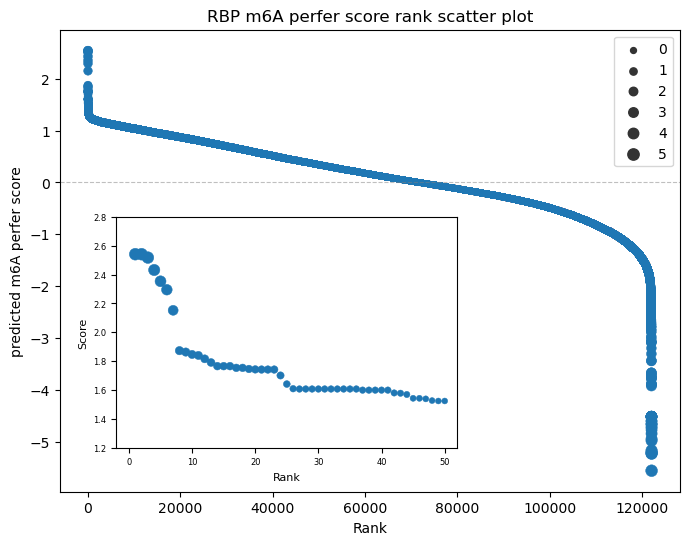

In [ ]:
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
matplotlib.rcParams['pdf.fonttype'] = 42

fig = plt.figure(figsize=(8, 6))
# ax1
ax1 = fig.add_subplot(1, 1, 1)
sns.scatterplot(data=df_for_plot, 
                x=df_for_plot.index + 1, 
                y=df_for_plot.predict_mps, 
                size=np.abs(df_for_plot.predict_mps),
                edgecolor=None,
                linewidths=0
                )
ax1.axhline(y=0, color='grey', linestyle='--', lw=0.8, alpha=0.5)
ax1.set_xlabel("Rank")
ax1.set_ylabel("predicted m6A perfer score")
ax1.set_title("RBP m6A perfer score rank scatter plot")
ax1.legend(loc="upper right")

# Create a local enlargement drawing
ax_inset = inset_axes(ax1, width="50%", height="50%", loc='lower left', 
                        bbox_to_anchor=[0.08, 0.08, 1.1, 1], bbox_transform=ax1.transAxes)
#
df_mps_top = df_for_plot.head(n=50)
sns.scatterplot(
    data=df_mps_top,
    x=df_mps_top.index + 1,
    y=df_mps_top.predict_mps,
    size=np.abs(df_mps_top.predict_mps),
    linewidths=0,
    edgecolor=None,
    ax=ax_inset,
    legend=None
)
ax_inset.set_xlim(-2, 52)
ax_inset.set_ylim(1.2, 2.8)
ax_inset.set_xlabel("Rank", fontsize=8)
ax_inset.set_ylabel("Score", fontsize=8)
ax_inset.tick_params(axis='both', which='major', labelsize=6)

# plt.savefig("all_human_proteins_max_predicted_m6A_perfer_score_rank_scatter_plot.pdf")
plt.show()


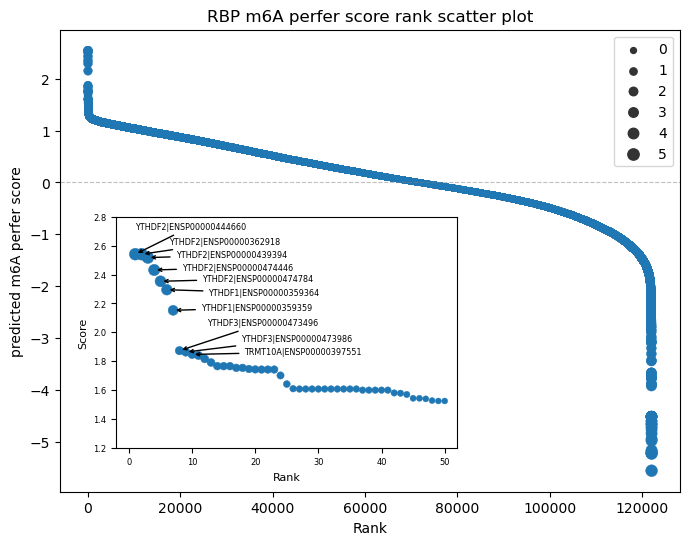

In [ ]:
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
matplotlib.rcParams['pdf.fonttype'] = 42

fig = plt.figure(figsize=(8, 6))
# ax1
ax1 = fig.add_subplot(1, 1, 1)
sns.scatterplot(data=df_for_plot, 
                x=df_for_plot.index + 1, 
                y=df_for_plot.predict_mps, 
                size=np.abs(df_for_plot.predict_mps),
                edgecolor=None,
                linewidths=0
                )
ax1.axhline(y=0, color='grey', linestyle='--', lw=0.8, alpha=0.5)
ax1.set_xlabel("Rank")
ax1.set_ylabel("predicted m6A perfer score")
ax1.set_title("RBP m6A perfer score rank scatter plot")
ax1.legend(loc="upper right")

# Create a local enlargement drawing
ax_inset = inset_axes(ax1, width="50%", height="50%", loc='lower left', 
                        bbox_to_anchor=[0.08, 0.08, 1.1, 1], bbox_transform=ax1.transAxes)
#
df_mps_top = df_for_plot.head(n=50)
sns.scatterplot(
    data=df_mps_top,
    x=df_mps_top.index + 1,
    y=df_mps_top.predict_mps,
    size=np.abs(df_mps_top.predict_mps),
    linewidths=0,
    edgecolor=None,
    ax=ax_inset,
    legend=None
)
# 
ax_inset.set_xlim(-2, 52)
ax_inset.set_ylim(1.2, 2.8)
ax_inset.set_xlabel("Rank", fontsize=8)
ax_inset.set_ylabel("Score", fontsize=8)
ax_inset.tick_params(axis='both', which='major', labelsize=6)

# The top 10 proteins with the highest scores are labeled
# for pro_idx in list(range(11)):
#     ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[pro_idx].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[pro_idx]+1, df_mps_top.predict_mps[pro_idx]), 
#                 xytext=(50, 15), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[0].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[0]+1, df_mps_top.predict_mps[0]), 
                xytext=(40, 18), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[1].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[1]+1, df_mps_top.predict_mps[1]), 
                xytext=(60, 7), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[2].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[2]+1, df_mps_top.predict_mps[2]), 
                xytext=(60, 0), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[3].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[3]+1, df_mps_top.predict_mps[3]), 
                xytext=(60, 0), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[4].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[4]+1, df_mps_top.predict_mps[4]), 
                xytext=(70, 0), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[5].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[5]+1, df_mps_top.predict_mps[5]), 
                xytext=(70, -4), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[6].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[6]+1, df_mps_top.predict_mps[6]), 
                xytext=(60, 0), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[7].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[7]+1, df_mps_top.predict_mps[7]), 
                xytext=(60, 18), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[8].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[8]+1, df_mps_top.predict_mps[8]), 
                xytext=(80, 8), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[9].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[9]+1, df_mps_top.predict_mps[9]), 
                xytext=(80, 0), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))

# plt.savefig("all_human_proteins_max_predicted_m6A_perfer_score_rank_scatter_plot.pdf")
plt.show()


# The m6A preference score predictions for all proteins of the other nine representative species

In [ ]:
# mkdir other_species_all_proteins_predict

# Download the complete protein sequences of nine representative species 
# including mice, zebrafish, Arabidopsis, corn, etc. from Ensemble.
# And then reorganize and reformat the sequence into the form of <protein ID>\t<protein sequence>, for example:

# <gene_symble|gene_id|transcript_id|protein_id> <\t> <amino_acid_sequence> 


In [ ]:
import os
print(os.getcwd())
os.chdir("./other_species_all_proteins_predict/")
print(os.getcwd())


## mouse (Mus musculus)

### Load all protein sequences and perform preprocessing

In [ ]:
df = pd.read_csv("Mus_musculus.GRCm39.pep.all.fa.reshaped_for_predict.txt", sep="\t", header=None)
print(df.shape)
df.head()

(66403, 2)


,0,1
0,Gm20730|ENSMUSG00000076500|ENSMUST00000103301|...,MRCLAEFLRLLVLWIPATGDIVMTQAAPSVPANPGESVSISCRSSK...
1,Gm54608|ENSMUSG00000090395|ENSMUST00000166255|...,HGCVLRPQTVYFQVKCVFVIISGDGESALHCVYIVGATSTTKNYCH...
2,Gm54637|ENSMUSG00000090765|ENSMUST00000095364|...,SLTIIVSSVLRCQASELHVGCVGGCVYSKCGLAFELLIVGNTTIFR...
3,Igkv1-133|ENSMUSG00000094491|ENSMUST0000010330...,MMSPAQFLFLLVLWIQETNGDVVMTQTPLTLSVTIGQPASISCKSS...
4,Igkv1-132|ENSMUSG00000096580|ENSMUST0000010330...,MMSPVQFLFLLMLWIQETNGDVVMTQTPLSLSVTIGQPASISCKSS...


In [68]:
processed_df = process_input("Mus_musculus.GRCm39.pep.all.fa.reshaped_for_predict.txt")
print(processed_df.shape)
processed_df.head()
# 1m15s

(349284, 5)


,protein_id,protein_AAstr,peptide_id,peptide_AAstr,encoded_AAstr
0,Gm20730|ENSMUSG00000076500|ENSMUST00000103301|...,MRCLAEFLRLLVLWIPATGDIVMTQAAPSVPANPGESVSISCRSSK...,Gm20730|ENSMUSG00000076500|ENSMUST00000103301|...,MRCLAEFLRLLVLWIPATGDIVMTQAAPSVPANPGESVSISCRSSK...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,..."
1,Gm54608|ENSMUSG00000090395|ENSMUST00000166255|...,HGCVLRPQTVYFQVKCVFVIISGDGESALHCVYIVGATSTTKNYCH...,Gm54608|ENSMUSG00000090395|ENSMUST00000166255|...,HGCVLRPQTVYFQVKCVFVIISGDGESALHCVYIVGATSTTKNYCH...,"[[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,Gm54637|ENSMUSG00000090765|ENSMUST00000095364|...,SLTIIVSSVLRCQASELHVGCVGGCVYSKCGLAFELLIVGNTTIFR...,Gm54637|ENSMUSG00000090765|ENSMUST00000095364|...,SLTIIVSSVLRCQASELHVGCVGGCVYSKCGLAFELLIVGNTTIFR...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,Igkv1-133|ENSMUSG00000094491|ENSMUST0000010330...,MMSPAQFLFLLVLWIQETNGDVVMTQTPLTLSVTIGQPASISCKSS...,Igkv1-133|ENSMUSG00000094491|ENSMUST0000010330...,MMSPAQFLFLLVLWIQETNGDVVMTQTPLTLSVTIGQPASISCKSS...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,..."
4,Igkv1-132|ENSMUSG00000096580|ENSMUST0000010330...,MMSPVQFLFLLMLWIQETNGDVVMTQTPLSLSVTIGQPASISCKSS...,Igkv1-132|ENSMUSG00000096580|ENSMUST0000010330...,MMSPVQFLFLLMLWIQETNGDVVMTQTPLSLSVTIGQPASISCKSS...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,..."


### Feature extraction

In [ ]:
X =  np.array(processed_df['encoded_AAstr'].tolist())
print(X.shape)
X

(349284, 300, 20)


array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

### Prediction

In [ ]:
with tf.device('/GPU:0'):
    pred = my_model.predict(X)
    print(pred.shape)
    pred
# ~ 35s

(349284, 1)


In [71]:
pred.flatten().tolist()

[-0.374755859375,
 0.55029296875,
 0.271484375,
 -0.8515625,
 -0.9912109375,
 -0.8232421875,
 -0.82177734375,
 -0.37646484375,
 -1.228515625,
 -0.666015625,
 -0.6044921875,
 -0.4111328125,
 -0.1702880859375,
 -0.91357421875,
 -0.501953125,
 -1.060546875,
 -0.16357421875,
 -0.6669921875,
 -0.66015625,
 -0.9375,
 -0.0772705078125,
 -0.20654296875,
 -1.3876953125,
 -1.6728515625,
 -0.9248046875,
 -0.8720703125,
 -0.63037109375,
 -0.9560546875,
 -0.99951171875,
 -1.33984375,
 -0.52197265625,
 -0.484619140625,
 -1.4326171875,
 -0.434814453125,
 -1.2119140625,
 -0.284423828125,
 0.05902099609375,
 -0.984375,
 -0.611328125,
 -0.7373046875,
 -0.35888671875,
 -0.79541015625,
 -1.357421875,
 -0.90576171875,
 -0.93798828125,
 -0.78076171875,
 -0.6865234375,
 -1.0224609375,
 -1.330078125,
 -0.63134765625,
 -0.443115234375,
 -1.3759765625,
 -0.51708984375,
 -0.8935546875,
 -0.890625,
 -1.216796875,
 -1.2822265625,
 -0.1361083984375,
 -0.003173828125,
 -0.020050048828125,
 -0.203125,
 0.063415527343

### Add prediction results

In [72]:
processed_df["predict_mps"] = pred.flatten().tolist()
processed_df.head()

,protein_id,protein_AAstr,peptide_id,peptide_AAstr,encoded_AAstr,predict_mps
0,Gm20730|ENSMUSG00000076500|ENSMUST00000103301|...,MRCLAEFLRLLVLWIPATGDIVMTQAAPSVPANPGESVSISCRSSK...,Gm20730|ENSMUSG00000076500|ENSMUST00000103301|...,MRCLAEFLRLLVLWIPATGDIVMTQAAPSVPANPGESVSISCRSSK...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,...",-0.374756
1,Gm54608|ENSMUSG00000090395|ENSMUST00000166255|...,HGCVLRPQTVYFQVKCVFVIISGDGESALHCVYIVGATSTTKNYCH...,Gm54608|ENSMUSG00000090395|ENSMUST00000166255|...,HGCVLRPQTVYFQVKCVFVIISGDGESALHCVYIVGATSTTKNYCH...,"[[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,...",0.550293
2,Gm54637|ENSMUSG00000090765|ENSMUST00000095364|...,SLTIIVSSVLRCQASELHVGCVGGCVYSKCGLAFELLIVGNTTIFR...,Gm54637|ENSMUSG00000090765|ENSMUST00000095364|...,SLTIIVSSVLRCQASELHVGCVGGCVYSKCGLAFELLIVGNTTIFR...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.271484
3,Igkv1-133|ENSMUSG00000094491|ENSMUST0000010330...,MMSPAQFLFLLVLWIQETNGDVVMTQTPLTLSVTIGQPASISCKSS...,Igkv1-133|ENSMUSG00000094491|ENSMUST0000010330...,MMSPAQFLFLLVLWIQETNGDVVMTQTPLTLSVTIGQPASISCKSS...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,...",-0.851562
4,Igkv1-132|ENSMUSG00000096580|ENSMUST0000010330...,MMSPVQFLFLLMLWIQETNGDVVMTQTPLSLSVTIGQPASISCKSS...,Igkv1-132|ENSMUSG00000096580|ENSMUST0000010330...,MMSPVQFLFLLMLWIQETNGDVVMTQTPLSLSVTIGQPASISCKSS...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,...",-0.991211


In [73]:
processed_df = processed_df.drop("encoded_AAstr", axis=1)
processed_df.to_csv("Mus_musculus.GRCm39.pep.all.fa.reshaped_for_predict.peptide_wtih_mps.xls", sep="\t", header=True, index=False)
print(processed_df.shape)
processed_df.head()

(349284, 5)


,protein_id,protein_AAstr,peptide_id,peptide_AAstr,predict_mps
0,Gm20730|ENSMUSG00000076500|ENSMUST00000103301|...,MRCLAEFLRLLVLWIPATGDIVMTQAAPSVPANPGESVSISCRSSK...,Gm20730|ENSMUSG00000076500|ENSMUST00000103301|...,MRCLAEFLRLLVLWIPATGDIVMTQAAPSVPANPGESVSISCRSSK...,-0.374756
1,Gm54608|ENSMUSG00000090395|ENSMUST00000166255|...,HGCVLRPQTVYFQVKCVFVIISGDGESALHCVYIVGATSTTKNYCH...,Gm54608|ENSMUSG00000090395|ENSMUST00000166255|...,HGCVLRPQTVYFQVKCVFVIISGDGESALHCVYIVGATSTTKNYCH...,0.550293
2,Gm54637|ENSMUSG00000090765|ENSMUST00000095364|...,SLTIIVSSVLRCQASELHVGCVGGCVYSKCGLAFELLIVGNTTIFR...,Gm54637|ENSMUSG00000090765|ENSMUST00000095364|...,SLTIIVSSVLRCQASELHVGCVGGCVYSKCGLAFELLIVGNTTIFR...,0.271484
3,Igkv1-133|ENSMUSG00000094491|ENSMUST0000010330...,MMSPAQFLFLLVLWIQETNGDVVMTQTPLTLSVTIGQPASISCKSS...,Igkv1-133|ENSMUSG00000094491|ENSMUST0000010330...,MMSPAQFLFLLVLWIQETNGDVVMTQTPLTLSVTIGQPASISCKSS...,-0.851562
4,Igkv1-132|ENSMUSG00000096580|ENSMUST0000010330...,MMSPVQFLFLLMLWIQETNGDVVMTQTPLSLSVTIGQPASISCKSS...,Igkv1-132|ENSMUSG00000096580|ENSMUST0000010330...,MMSPVQFLFLLMLWIQETNGDVVMTQTPLSLSVTIGQPASISCKSS...,-0.991211


### Get the maximum m6A prefer score for each protein

In [ ]:
idx = processed_df.groupby('protein_id')['predict_mps'].idxmax()
protein_result_df = processed_df.loc[idx].reset_index(drop=True)
protein_result_df.to_csv("Mus_musculus.GRCm39.pep.all.fa.reshaped_for_predict.protein_max_mps.xls", sep="\t", header=True, index=False)
print(protein_result_df.shape)
protein_result_df.head()

(66276, 5)


,protein_id,protein_AAstr,peptide_id,peptide_AAstr,predict_mps
0,0610010K14Rik|ENSMUSG00000020831|ENSMUST000000...,MTSASTKVGEIFSAAGAAFTKLGELTMQLHPVSDSSPAGAKWTETE...,0610010K14Rik|ENSMUSG00000020831|ENSMUST000000...,MTSASTKVGEIFSAAGAAFTKLGELTMQLHPVSDSSPAGAKWTETE...,-0.383545
1,0610010K14Rik|ENSMUSG00000020831|ENSMUST000000...,MTSASTKVGEIFSAAGAAFTKLGELTMQLHPVSDSSPAGAKWTETE...,0610010K14Rik|ENSMUSG00000020831|ENSMUST000000...,MTSASTKVGEIFSAAGAAFTKLGELTMQLHPVSDSSPAGAKWTETE...,-0.344482
2,0610010K14Rik|ENSMUSG00000020831|ENSMUST000001...,MLLRPQVGEIFSAAGAAFTKLGELTMQLHPVSDSSPAGAKWTETEI...,0610010K14Rik|ENSMUSG00000020831|ENSMUST000001...,MLLRPQVGEIFSAAGAAFTKLGELTMQLHPVSDSSPAGAKWTETEI...,-0.070312
3,0610010K14Rik|ENSMUSG00000020831|ENSMUST000001...,MTSASTKVGEIFSAAGAAFTKLGELTMQLHPVSDSSPAGAQIKTTV...,0610010K14Rik|ENSMUSG00000020831|ENSMUST000001...,MTSASTKVGEIFSAAGAAFTKLGELTMQLHPVSDSSPAGAQIKTTV...,-0.121338
4,0610010K14Rik|ENSMUSG00000020831|ENSMUST000001...,MTSASTKVGEIFSAAGAAFTKLGELTMQLHPVSDSSPAGAQIKTTV...,0610010K14Rik|ENSMUSG00000020831|ENSMUST000001...,MTSASTKVGEIFSAAGAAFTKLGELTMQLHPVSDSSPAGAQIKTTV...,-0.668457


### Scatter plot of the ranking of predicted protein scores

In [253]:
import pandas as pd
protein_result_file = "Mus_musculus.GRCm39.pep.all.fa.reshaped_for_predict.protein_max_mps.xls"
protein_result_df = pd.read_csv(protein_result_file, sep="\t", usecols=["protein_id", "predict_mps"])
print(protein_result_df.shape)
protein_result_df.head()


(66276, 2)


,protein_id,predict_mps
0,0610010K14Rik|ENSMUSG00000020831|ENSMUST000000...,-0.383545
1,0610010K14Rik|ENSMUSG00000020831|ENSMUST000000...,-0.344482
2,0610010K14Rik|ENSMUSG00000020831|ENSMUST000001...,-0.070312
3,0610010K14Rik|ENSMUSG00000020831|ENSMUST000001...,-0.121338
4,0610010K14Rik|ENSMUSG00000020831|ENSMUST000001...,-0.668457


In [254]:
protein_result_df.predict_mps.describe()

count    66276.000000
mean         0.181049
std          0.680916
min         -5.109375
25%         -0.260986
50%          0.231934
75%          0.751465
max          2.521484
Name: predict_mps, dtype: float64

In [255]:
df_for_plot = protein_result_df.sort_values(by="predict_mps", ascending=False)
df_for_plot.reset_index(drop=True, inplace=True)
df_for_plot.head(n=50)

,protein_id,predict_mps
0,Ythdf2|ENSMUSG00000040025|ENSMUST00000152796|E...,2.521484
1,Ythdf1|ENSMUSG00000038848|ENSMUST00000037299|E...,2.017578
2,Ythdf1|ENSMUSG00000038848|ENSMUST00000108876|E...,1.997070
3,Ythdf2|ENSMUSG00000040025|ENSMUST00000085181|E...,1.936523
4,Ythdf3|ENSMUSG00000047213|ENSMUST00000108346|E...,1.884766
5,Ythdf3|ENSMUSG00000047213|ENSMUST00000108345|E...,1.865234
6,Ythdf3|ENSMUSG00000047213|ENSMUST00000191774|E...,1.604492
7,Fmr1|ENSMUSG00000000838|ENSMUST00000114657|ENS...,1.546875
8,Fmr1|ENSMUSG00000000838|ENSMUST00000114654|ENS...,1.546875
9,Fmr1|ENSMUSG00000000838|ENSMUST00000114656|ENS...,1.538086


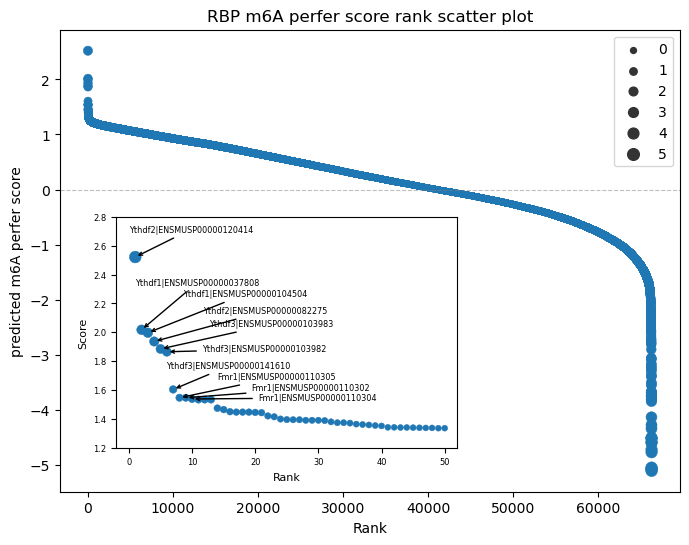

In [ ]:
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
matplotlib.rcParams['pdf.fonttype'] = 42

fig = plt.figure(figsize=(8, 6))
# ax1
ax1 = fig.add_subplot(1, 1, 1)
sns.scatterplot(data=df_for_plot, 
                x=df_for_plot.index + 1, 
                y=df_for_plot.predict_mps, 
                size=np.abs(df_for_plot.predict_mps),
                edgecolor=None,
                linewidths=0
                )
ax1.axhline(y=0, color='grey', linestyle='--', lw=0.8, alpha=0.5)
ax1.set_xlabel("Rank")
ax1.set_ylabel("predicted m6A perfer score")
ax1.set_title("RBP m6A perfer score rank scatter plot")
ax1.legend(loc="upper right")

# Create a local enlargement drawing
ax_inset = inset_axes(ax1, width="50%", height="50%", loc='lower left', 
                        bbox_to_anchor=[0.08, 0.08, 1.1, 1], bbox_transform=ax1.transAxes)
#
df_mps_top = df_for_plot.head(n=50)
sns.scatterplot(
    data=df_mps_top,
    x=df_mps_top.index + 1,
    y=df_mps_top.predict_mps,
    size=np.abs(df_mps_top.predict_mps),
    linewidths=0,
    edgecolor=None,
    ax=ax_inset,
    legend=None
)
ax_inset.set_xlim(-2, 52)
ax_inset.set_ylim(1.2, 2.8)
ax_inset.set_xlabel("Rank", fontsize=8)
ax_inset.set_ylabel("Score", fontsize=8)
ax_inset.tick_params(axis='both', which='major', labelsize=6)

# The top 10 proteins with the highest scores are labeled
# for pro_idx in list(range(11)):
#     ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[pro_idx].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[pro_idx]+1, df_mps_top.predict_mps[pro_idx]), 
#                 xytext=(50, 15), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[0].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[0]+1, df_mps_top.predict_mps[0]), 
                xytext=(40, 18), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[1].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[1]+1, df_mps_top.predict_mps[1]), 
                xytext=(40, 32), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[2].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[2]+1, df_mps_top.predict_mps[2]), 
                xytext=(70, 26), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[3].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[3]+1, df_mps_top.predict_mps[3]), 
                xytext=(80, 20), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[4].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[4]+1, df_mps_top.predict_mps[4]), 
                xytext=(80, 16), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[5].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[5]+1, df_mps_top.predict_mps[5]), 
                xytext=(70, 0), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[6].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[6]+1, df_mps_top.predict_mps[6]), 
                xytext=(40, 15), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[7].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[7]+1, df_mps_top.predict_mps[7]), 
                xytext=(70, 13), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[8].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[8]+1, df_mps_top.predict_mps[8]), 
                xytext=(90, 5), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[9].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[9]+1, df_mps_top.predict_mps[9]), 
                xytext=(90, -1), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))

# plt.savefig("all_mouse_proteins_max_predicted_m6A_perfer_score_rank_scatter_plot.pdf")
plt.show()


## zebra_fish (Danio rerio)

### Load all protein sequences and perform preprocessing

In [ ]:
df = pd.read_csv("Danio_rerio.GRCz11.pep.all.fa.reshaped_for_predict.txt", sep="\t", header=None)
print(df.shape)
df.head()

(51989, 2)


,0,1
0,ndst2a|ENSDARG00000086269|ENSDART00000125149|E...,MGLWKLVRGVRQLELHRLILALIIFCLLSMAFLAYYVSNSPKIKEA...
1,ndst2a|ENSDARG00000086269|ENSDART00000182440|E...,MGLWKLVRGVRQLELHRLILALIIFCLLSMAFLAYYVSNSPKIKEA...
2,apip|ENSDARG00000003132|ENSDART00000007487|ENS...,MSSVVNAAYAEYNGKEKGDQEDPRVLIPQLCRLFYELGWVTGTGGG...
3,SLC16A6|ENSDARG00000104629|ENSDART00000171190|...,MAQWIFRLRSCFGSKVYSEVPDGGWGWIVAVAFFLVEVFTYGVIKS...
4,SLC16A6|ENSDARG00000104629|ENSDART00000170923|...,MAQWIFRLRSCFGSKVYSEVPDGGWGWIVAVAFFLVEVFTYGVIKS...


In [76]:
processed_df = process_input("Danio_rerio.GRCz11.pep.all.fa.reshaped_for_predict.txt")
print(processed_df.shape)
processed_df.head()
# 45s

(338526, 5)


,protein_id,protein_AAstr,peptide_id,peptide_AAstr,encoded_AAstr
0,ndst2a|ENSDARG00000086269|ENSDART00000125149|E...,MGLWKLVRGVRQLELHRLILALIIFCLLSMAFLAYYVSNSPKIKEA...,ndst2a|ENSDARG00000086269|ENSDART00000125149|E...,MGLWKLVRGVRQLELHRLILALIIFCLLSMAFLAYYVSNSPKIKEA...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,..."
1,ndst2a|ENSDARG00000086269|ENSDART00000125149|E...,MGLWKLVRGVRQLELHRLILALIIFCLLSMAFLAYYVSNSPKIKEA...,ndst2a|ENSDARG00000086269|ENSDART00000125149|E...,FSDCGGVVADAAGGQRTPLFLPPFSGRQRTVKVVDNSRTEPVVLVF...,"[[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,ndst2a|ENSDARG00000086269|ENSDART00000125149|E...,MGLWKLVRGVRQLELHRLILALIIFCLLSMAFLAYYVSNSPKIKEA...,ndst2a|ENSDARG00000086269|ENSDART00000125149|E...,YSQLGQEIVAILESSRFRYHTEIAPSKGDMPTLMERDIGRYALVIY...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,ndst2a|ENSDARG00000086269|ENSDART00000125149|E...,MGLWKLVRGVRQLELHRLILALIIFCLLSMAFLAYYVSNSPKIKEA...,ndst2a|ENSDARG00000086269|ENSDART00000125149|E...,KYVNLDAWNRDLLDKYCSEFGVGIIGFFKANENSLLSAQLKGFPLF...,"[[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,..."
4,ndst2a|ENSDARG00000086269|ENSDART00000125149|E...,MGLWKLVRGVRQLELHRLILALIIFCLLSMAFLAYYVSNSPKIKEA...,ndst2a|ENSDARG00000086269|ENSDART00000125149|E...,LGLRDYHINPAAPLLYITKPNEVEQGLLPGDDWTVFQSNHSTYEPV...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,..."


### Feature extraction

In [ ]:
X =  np.array(processed_df['encoded_AAstr'].tolist())
print(X.shape)
X

(338526, 300, 20)


array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 1, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 1],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 0],
        ...,
        [0, 0, 0, ..., 

### Prediction

In [ ]:
with tf.device('/GPU:0'):
    pred = my_model.predict(X)
    print(pred.shape)
    pred
# ~ 34s

(338526, 1)


In [79]:
pred.flatten().tolist()

[1.07421875,
 1.0390625,
 0.88720703125,
 0.65283203125,
 0.88623046875,
 0.70751953125,
 0.30810546875,
 0.517578125,
 0.5390625,
 0.98193359375,
 1.107421875,
 1.07421875,
 1.0390625,
 0.88720703125,
 0.65283203125,
 0.88623046875,
 0.70751953125,
 0.30810546875,
 0.517578125,
 0.5390625,
 0.98193359375,
 1.107421875,
 -0.334228515625,
 -1.3720703125,
 -1.2236328125,
 -1.146484375,
 -0.53125,
 -0.1533203125,
 -1.3720703125,
 -1.2236328125,
 -1.146484375,
 -0.53125,
 -0.1533203125,
 0.402099609375,
 0.7451171875,
 0.375,
 0.7109375,
 0.47998046875,
 -0.54296875,
 0.08465576171875,
 -0.501953125,
 -0.1715087890625,
 -0.78564453125,
 0.41796875,
 0.65966796875,
 0.6611328125,
 0.7109375,
 0.560546875,
 0.43896484375,
 0.4609375,
 -0.195068359375,
 -0.86669921875,
 0.00030517578125,
 0.12335205078125,
 -0.029571533203125,
 -0.00634765625,
 -0.063232421875,
 0.037841796875,
 0.0521240234375,
 0.26806640625,
 0.387451171875,
 -0.27490234375,
 -0.00048828125,
 -0.0391845703125,
 -0.20483398

### Add prediction results

In [80]:
processed_df["predict_mps"] = pred.flatten().tolist()
processed_df.head()

,protein_id,protein_AAstr,peptide_id,peptide_AAstr,encoded_AAstr,predict_mps
0,ndst2a|ENSDARG00000086269|ENSDART00000125149|E...,MGLWKLVRGVRQLELHRLILALIIFCLLSMAFLAYYVSNSPKIKEA...,ndst2a|ENSDARG00000086269|ENSDART00000125149|E...,MGLWKLVRGVRQLELHRLILALIIFCLLSMAFLAYYVSNSPKIKEA...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,...",1.074219
1,ndst2a|ENSDARG00000086269|ENSDART00000125149|E...,MGLWKLVRGVRQLELHRLILALIIFCLLSMAFLAYYVSNSPKIKEA...,ndst2a|ENSDARG00000086269|ENSDART00000125149|E...,FSDCGGVVADAAGGQRTPLFLPPFSGRQRTVKVVDNSRTEPVVLVF...,"[[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1.039062
2,ndst2a|ENSDARG00000086269|ENSDART00000125149|E...,MGLWKLVRGVRQLELHRLILALIIFCLLSMAFLAYYVSNSPKIKEA...,ndst2a|ENSDARG00000086269|ENSDART00000125149|E...,YSQLGQEIVAILESSRFRYHTEIAPSKGDMPTLMERDIGRYALVIY...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.887207
3,ndst2a|ENSDARG00000086269|ENSDART00000125149|E...,MGLWKLVRGVRQLELHRLILALIIFCLLSMAFLAYYVSNSPKIKEA...,ndst2a|ENSDARG00000086269|ENSDART00000125149|E...,KYVNLDAWNRDLLDKYCSEFGVGIIGFFKANENSLLSAQLKGFPLF...,"[[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,...",0.652832
4,ndst2a|ENSDARG00000086269|ENSDART00000125149|E...,MGLWKLVRGVRQLELHRLILALIIFCLLSMAFLAYYVSNSPKIKEA...,ndst2a|ENSDARG00000086269|ENSDART00000125149|E...,LGLRDYHINPAAPLLYITKPNEVEQGLLPGDDWTVFQSNHSTYEPV...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,...",0.886230


In [81]:
processed_df = processed_df.drop("encoded_AAstr", axis=1)
processed_df.to_csv("Danio_rerio.GRCz11.pep.all.fa.reshaped_for_predict.peptide_wtih_mps.xls", sep="\t", header=True, index=False)
print(processed_df.shape)
processed_df.head()

(338526, 5)


,protein_id,protein_AAstr,peptide_id,peptide_AAstr,predict_mps
0,ndst2a|ENSDARG00000086269|ENSDART00000125149|E...,MGLWKLVRGVRQLELHRLILALIIFCLLSMAFLAYYVSNSPKIKEA...,ndst2a|ENSDARG00000086269|ENSDART00000125149|E...,MGLWKLVRGVRQLELHRLILALIIFCLLSMAFLAYYVSNSPKIKEA...,1.074219
1,ndst2a|ENSDARG00000086269|ENSDART00000125149|E...,MGLWKLVRGVRQLELHRLILALIIFCLLSMAFLAYYVSNSPKIKEA...,ndst2a|ENSDARG00000086269|ENSDART00000125149|E...,FSDCGGVVADAAGGQRTPLFLPPFSGRQRTVKVVDNSRTEPVVLVF...,1.039062
2,ndst2a|ENSDARG00000086269|ENSDART00000125149|E...,MGLWKLVRGVRQLELHRLILALIIFCLLSMAFLAYYVSNSPKIKEA...,ndst2a|ENSDARG00000086269|ENSDART00000125149|E...,YSQLGQEIVAILESSRFRYHTEIAPSKGDMPTLMERDIGRYALVIY...,0.887207
3,ndst2a|ENSDARG00000086269|ENSDART00000125149|E...,MGLWKLVRGVRQLELHRLILALIIFCLLSMAFLAYYVSNSPKIKEA...,ndst2a|ENSDARG00000086269|ENSDART00000125149|E...,KYVNLDAWNRDLLDKYCSEFGVGIIGFFKANENSLLSAQLKGFPLF...,0.652832
4,ndst2a|ENSDARG00000086269|ENSDART00000125149|E...,MGLWKLVRGVRQLELHRLILALIIFCLLSMAFLAYYVSNSPKIKEA...,ndst2a|ENSDARG00000086269|ENSDART00000125149|E...,LGLRDYHINPAAPLLYITKPNEVEQGLLPGDDWTVFQSNHSTYEPV...,0.886230


### Get the maximum m6A prefer score for each protein

In [ ]:
idx = processed_df.groupby('protein_id')['predict_mps'].idxmax()
protein_result_df = processed_df.loc[idx].reset_index(drop=True)
protein_result_df.to_csv("Danio_rerio.GRCz11.pep.all.fa.reshaped_for_predict.protein_max_mps.xls", sep="\t", header=True, index=False)
print(protein_result_df.shape)
protein_result_df.head()

(37680, 5)


,protein_id,protein_AAstr,peptide_id,peptide_AAstr,predict_mps
0,42sp43|ENSDARG00000104170|ENSDART00000163104|E...,MNTEVMKREDVVPRVQLFNCVYAECGATFTRQWRLQEHETVHTGVR...,42sp43|ENSDARG00000104170|ENSDART00000163104|E...,MNTEVMKREDVVPRVQLFNCVYAECGATFTRQWRLQEHETVHTGVR...,0.923828
1,42sp43|ENSDARG00000104170|ENSDART00000164644|E...,MNTEVMKREDVVPRVQLFNCVYAECGATFTRQWRLQEHETVHTGVC...,42sp43|ENSDARG00000104170|ENSDART00000164644|E...,MNTEVMKREDVVPRVQLFNCVYAECGATFTRQWRLQEHETVHTGVC...,0.972168
2,42sp43|ENSDARG00000104170|ENSDART00000167480|E...,MNTEVMKREDVVPRVQLFNCVYAECGATFTRQWRLQEHETVHTGVR...,42sp43|ENSDARG00000104170|ENSDART00000167480|E...,MNTEVMKREDVVPRVQLFNCVYAECGATFTRQWRLQEHETVHTGVR...,0.780762
3,A1CF|ENSDARG00000002968|ENSDART00000152292|ENS...,METNQKCGDGLTGTQKEAALRALIQRTGYHIHQENGQRRYGGPPPG...,A1CF|ENSDARG00000002968|ENSDART00000152292|ENS...,METNQKCGDGLTGTQKEAALRALIQRTGYHIHQENGQRRYGGPPPG...,-0.827637
4,A1CF|ENSDARG00000002968|ENSDART00000185434|ENS...,METNQKCGDGLTGTQKEAALRALIQRTGYHIHQENGQRRYGGPPPG...,A1CF|ENSDARG00000002968|ENSDART00000185434|ENS...,METNQKCGDGLTGTQKEAALRALIQRTGYHIHQENGQRRYGGPPPG...,-0.827637


### Scatter plot of the ranking of predicted protein scores

In [264]:
import pandas as pd
protein_result_file = "Danio_rerio.GRCz11.pep.all.fa.reshaped_for_predict.protein_max_mps.xls"
protein_result_df = pd.read_csv(protein_result_file, sep="\t", usecols=["protein_id", "predict_mps"])
print(protein_result_df.shape)
protein_result_df.head()


(37680, 2)


,protein_id,predict_mps
0,42sp43|ENSDARG00000104170|ENSDART00000163104|E...,0.923828
1,42sp43|ENSDARG00000104170|ENSDART00000164644|E...,0.972168
2,42sp43|ENSDARG00000104170|ENSDART00000167480|E...,0.780762
3,A1CF|ENSDARG00000002968|ENSDART00000152292|ENS...,-0.827637
4,A1CF|ENSDARG00000002968|ENSDART00000185434|ENS...,-0.827637


In [265]:
protein_result_df.predict_mps.describe()

count    37680.000000
mean         0.373338
std          0.647905
min         -3.785156
25%         -0.025948
50%          0.518555
75%          0.893555
max          1.685547
Name: predict_mps, dtype: float64

In [266]:
df_for_plot = protein_result_df.sort_values(by="predict_mps", ascending=False)
df_for_plot.reset_index(drop=True, inplace=True)
df_for_plot.head(n=50)

,protein_id,predict_mps
0,ythdf2|ENSDARG00000014498|ENSDART00000127043|E...,1.685547
1,ythdf2|ENSDARG00000014498|ENSDART00000186773|E...,1.674805
2,ythdf3|ENSDARG00000057939|ENSDART00000122294|E...,1.583008
3,ythdf1|ENSDARG00000016447|ENSDART00000025171|E...,1.498047
4,ythdf1|ENSDARG00000016447|ENSDART00000184512|E...,1.498047
5,zc2hc1a|ENSDARG00000112745|ENSDART00000169409|...,1.451172
6,SNX1|ENSDARG00000103529|ENSDART00000160072|ENS...,1.423828
7,ADAMTS7|ENSDARG00000102478|ENSDART00000162653|...,1.362305
8,ccn1|ENSDARG00000023062|ENSDART00000036631|ENS...,1.359375
9,dgcr8|ENSDARG00000035564|ENSDART00000144560|EN...,1.345703


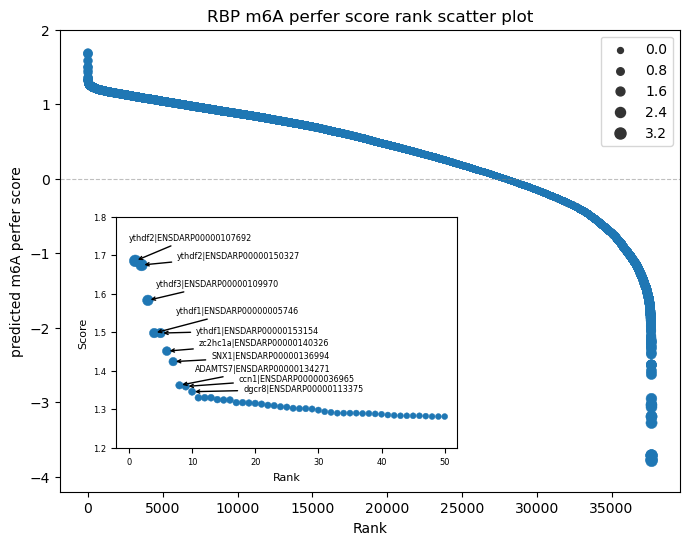

In [ ]:
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
matplotlib.rcParams['pdf.fonttype'] = 42

fig = plt.figure(figsize=(8, 6))
# ax1
ax1 = fig.add_subplot(1, 1, 1)
sns.scatterplot(data=df_for_plot, 
                x=df_for_plot.index + 1, 
                y=df_for_plot.predict_mps, 
                size=np.abs(df_for_plot.predict_mps),
                edgecolor=None,
                linewidths=0
                )
ax1.axhline(y=0, color='grey', linestyle='--', lw=0.8, alpha=0.5)
ax1.set_ylim(-4.2, 2)
ax1.set_xlabel("Rank")
ax1.set_ylabel("predicted m6A perfer score")
ax1.set_title("RBP m6A perfer score rank scatter plot")
ax1.legend(loc="upper right")

# Create a local enlargement drawing
ax_inset = inset_axes(ax1, width="50%", height="50%", loc='lower left', 
                        bbox_to_anchor=[0.08, 0.08, 1.1, 1], bbox_transform=ax1.transAxes)
#
df_mps_top = df_for_plot.head(n=50)
sns.scatterplot(
    data=df_mps_top,
    x=df_mps_top.index + 1,
    y=df_mps_top.predict_mps,
    size=np.abs(df_mps_top.predict_mps),
    linewidths=0,
    edgecolor=None,
    ax=ax_inset,
    legend=None
)
ax_inset.set_xlim(-2, 52)
ax_inset.set_ylim(1.2, 1.8)
ax_inset.set_xlabel("Rank", fontsize=8)
ax_inset.set_ylabel("Score", fontsize=8)
ax_inset.tick_params(axis='both', which='major', labelsize=6)

# # The top 10 proteins with the highest scores are labeled
# for pro_idx in list(range(11)):
#     ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[pro_idx].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[pro_idx]+1, df_mps_top.predict_mps[pro_idx]), 
#                 xytext=(50, 15), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[0].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[0]+1, df_mps_top.predict_mps[0]), 
                xytext=(40, 15), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[1].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[1]+1, df_mps_top.predict_mps[1]), 
                xytext=(70, 5), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[2].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[2]+1, df_mps_top.predict_mps[2]), 
                xytext=(50, 10), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[3].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[3]+1, df_mps_top.predict_mps[3]), 
                xytext=(60, 14), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[4].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[4]+1, df_mps_top.predict_mps[4]), 
                xytext=(70, 0), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[5].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[5]+1, df_mps_top.predict_mps[5]), 
                xytext=(70, 4), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[6].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[6]+1, df_mps_top.predict_mps[6]), 
                xytext=(70, 2), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[7].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[7]+1, df_mps_top.predict_mps[7]), 
                xytext=(60, 10), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[8].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[8]+1, df_mps_top.predict_mps[8]), 
                xytext=(80, 4), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[9].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[9]+1, df_mps_top.predict_mps[9]), 
                xytext=(80, 0), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))

plt.savefig("all_zebra_fish_proteins_max_predicted_m6A_perfer_score_rank_scatter_plot.pdf")
plt.show()


## fruit_fly (Drosophila melanogaster)

### Load all protein sequences and perform preprocessing

In [ ]:
df = pd.read_csv("Drosophila_melanogaster.BDGP6.46.pep.all.fa.reshaped_for_predict.txt", sep="\t", header=None)
print(df.shape)
df.head()

(30309, 2)


,0,1
0,Nep1|FBgn0029843|FBtr0343930|FBpp0310420,MSQQHEATAAAAEKPLNNGYLQANAPLEELSATVVSPLLGQQQVQH...
1,Nep1|FBgn0029843|FBtr0070872|FBpp0070837,MSQQHEATAAAAEKPLNNGYLQANAPLEELSATVVSPLLGQQQVQH...
2,Nep1|FBgn0029843|FBtr0070873|FBpp0070838,MSQQHEATAAAAEKPLNNGYLQANAPLEELSATVVSPLLGQQQVQH...
3,Nep1|FBgn0029843|FBtr0340032|FBpp0309046,MSQQHEATAAAAEKPLNNGYLQANAPLEELSATVVSPLLGQQQVQH...
4,gus|FBgn0026238|FBtr0309849|FBpp0301583,MGQKISGGVKTVSRNDSQSTFKPIIPRELQADFVKPARIDILLDMP...


In [84]:
processed_df = process_input("Drosophila_melanogaster.BDGP6.46.pep.all.fa.reshaped_for_predict.txt")
print(processed_df.shape)
processed_df.head()
# 1m15s

(279599, 5)


,protein_id,protein_AAstr,peptide_id,peptide_AAstr,encoded_AAstr
0,Nep1|FBgn0029843|FBtr0343930|FBpp0310420,MSQQHEATAAAAEKPLNNGYLQANAPLEELSATVVSPLLGQQQVQH...,Nep1|FBgn0029843|FBtr0343930|FBpp0310420:1-301,MSQQHEATAAAAEKPLNNGYLQANAPLEELSATVVSPLLGQQQVQH...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,..."
1,Nep1|FBgn0029843|FBtr0343930|FBpp0310420,MSQQHEATAAAAEKPLNNGYLQANAPLEELSATVVSPLLGQQQVQH...,Nep1|FBgn0029843|FBtr0343930|FBpp0310420:51-351,QMQQQQQQQQQNKLPTVVFLAPDGSGGVGIQRGNPAQGNPGMVTGT...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,..."
2,Nep1|FBgn0029843|FBtr0343930|FBpp0310420,MSQQHEATAAAAEKPLNNGYLQANAPLEELSATVVSPLLGQQQVQH...,Nep1|FBgn0029843|FBtr0343930|FBpp0310420:101-401,DWLLKESQQRRRLLVLAIAFTVLGAAIGALAIYFASVHQRCHLYRL...,"[[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,Nep1|FBgn0029843|FBtr0343930|FBpp0310420,MSQQHEATAAAAEKPLNNGYLQANAPLEELSATVVSPLLGQQQVQH...,Nep1|FBgn0029843|FBtr0343930|FBpp0310420:151-451,DDRPNGRWNQDSGSAHEGQDNICMTQECVRTAASLLSAMDLNSDPC...,"[[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,Nep1|FBgn0029843|FBtr0343930|FBpp0310420,MSQQHEATAAAAEKPLNNGYLQANAPLEELSATVVSPLLGQQQVQH...,Nep1|FBgn0029843|FBtr0343930|FBpp0310420:201-501,QYACGTWNKMHPIPEDRSSISTFEVLSDQQQVILRAVLEEPIDERD...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,..."


### Feature extraction

In [ ]:
X =  np.array(processed_df['encoded_AAstr'].tolist())
print(X.shape)
X

(279599, 300, 20)


array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

### Prediction

In [ ]:
with tf.device('/GPU:0'):
    pred = my_model.predict(X)
    print(pred.shape)
    pred
# ~ 54s

(279599, 1)


In [87]:
pred.flatten().tolist()

[0.484375,
 0.75537109375,
 0.6123046875,
 0.46484375,
 0.217529296875,
 0.50244140625,
 0.30859375,
 -0.1185302734375,
 -0.13427734375,
 -0.15625,
 -0.338623046875,
 0.46044921875,
 0.484375,
 0.75537109375,
 0.6123046875,
 0.46484375,
 0.217529296875,
 0.50244140625,
 0.30859375,
 -0.1185302734375,
 -0.13427734375,
 -0.15625,
 -0.338623046875,
 0.46044921875,
 0.484375,
 0.75537109375,
 0.6123046875,
 0.46484375,
 0.217529296875,
 0.50244140625,
 0.30859375,
 -0.1185302734375,
 -0.13427734375,
 -0.15625,
 -0.338623046875,
 0.46044921875,
 0.484375,
 0.75537109375,
 0.6123046875,
 0.46484375,
 0.217529296875,
 0.50244140625,
 0.30859375,
 -0.1185302734375,
 -0.13427734375,
 -0.15625,
 -0.338623046875,
 0.46044921875,
 0.00970458984375,
 0.00970458984375,
 0.00970458984375,
 0.00970458984375,
 0.00970458984375,
 0.00970458984375,
 0.00970458984375,
 0.6533203125,
 0.6630859375,
 0.244384765625,
 0.38232421875,
 -0.10540771484375,
 0.181396484375,
 0.841796875,
 0.66748046875,
 -0.08044

### Add prediction results

In [88]:
processed_df["predict_mps"] = pred.flatten().tolist()
processed_df.head()

,protein_id,protein_AAstr,peptide_id,peptide_AAstr,encoded_AAstr,predict_mps
0,Nep1|FBgn0029843|FBtr0343930|FBpp0310420,MSQQHEATAAAAEKPLNNGYLQANAPLEELSATVVSPLLGQQQVQH...,Nep1|FBgn0029843|FBtr0343930|FBpp0310420:1-301,MSQQHEATAAAAEKPLNNGYLQANAPLEELSATVVSPLLGQQQVQH...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,...",0.484375
1,Nep1|FBgn0029843|FBtr0343930|FBpp0310420,MSQQHEATAAAAEKPLNNGYLQANAPLEELSATVVSPLLGQQQVQH...,Nep1|FBgn0029843|FBtr0343930|FBpp0310420:51-351,QMQQQQQQQQQNKLPTVVFLAPDGSGGVGIQRGNPAQGNPGMVTGT...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,...",0.755371
2,Nep1|FBgn0029843|FBtr0343930|FBpp0310420,MSQQHEATAAAAEKPLNNGYLQANAPLEELSATVVSPLLGQQQVQH...,Nep1|FBgn0029843|FBtr0343930|FBpp0310420:101-401,DWLLKESQQRRRLLVLAIAFTVLGAAIGALAIYFASVHQRCHLYRL...,"[[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.612305
3,Nep1|FBgn0029843|FBtr0343930|FBpp0310420,MSQQHEATAAAAEKPLNNGYLQANAPLEELSATVVSPLLGQQQVQH...,Nep1|FBgn0029843|FBtr0343930|FBpp0310420:151-451,DDRPNGRWNQDSGSAHEGQDNICMTQECVRTAASLLSAMDLNSDPC...,"[[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.464844
4,Nep1|FBgn0029843|FBtr0343930|FBpp0310420,MSQQHEATAAAAEKPLNNGYLQANAPLEELSATVVSPLLGQQQVQH...,Nep1|FBgn0029843|FBtr0343930|FBpp0310420:201-501,QYACGTWNKMHPIPEDRSSISTFEVLSDQQQVILRAVLEEPIDERD...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,...",0.217529


In [89]:
processed_df = processed_df.drop("encoded_AAstr", axis=1)
processed_df.to_csv("Drosophila_melanogaster.BDGP6.46.pep.all.fa.reshaped_for_predict.peptide_wtih_mps.xls", sep="\t", header=True, index=False)
print(processed_df.shape)
processed_df.head()

(279599, 5)


,protein_id,protein_AAstr,peptide_id,peptide_AAstr,predict_mps
0,Nep1|FBgn0029843|FBtr0343930|FBpp0310420,MSQQHEATAAAAEKPLNNGYLQANAPLEELSATVVSPLLGQQQVQH...,Nep1|FBgn0029843|FBtr0343930|FBpp0310420:1-301,MSQQHEATAAAAEKPLNNGYLQANAPLEELSATVVSPLLGQQQVQH...,0.484375
1,Nep1|FBgn0029843|FBtr0343930|FBpp0310420,MSQQHEATAAAAEKPLNNGYLQANAPLEELSATVVSPLLGQQQVQH...,Nep1|FBgn0029843|FBtr0343930|FBpp0310420:51-351,QMQQQQQQQQQNKLPTVVFLAPDGSGGVGIQRGNPAQGNPGMVTGT...,0.755371
2,Nep1|FBgn0029843|FBtr0343930|FBpp0310420,MSQQHEATAAAAEKPLNNGYLQANAPLEELSATVVSPLLGQQQVQH...,Nep1|FBgn0029843|FBtr0343930|FBpp0310420:101-401,DWLLKESQQRRRLLVLAIAFTVLGAAIGALAIYFASVHQRCHLYRL...,0.612305
3,Nep1|FBgn0029843|FBtr0343930|FBpp0310420,MSQQHEATAAAAEKPLNNGYLQANAPLEELSATVVSPLLGQQQVQH...,Nep1|FBgn0029843|FBtr0343930|FBpp0310420:151-451,DDRPNGRWNQDSGSAHEGQDNICMTQECVRTAASLLSAMDLNSDPC...,0.464844
4,Nep1|FBgn0029843|FBtr0343930|FBpp0310420,MSQQHEATAAAAEKPLNNGYLQANAPLEELSATVVSPLLGQQQVQH...,Nep1|FBgn0029843|FBtr0343930|FBpp0310420:201-501,QYACGTWNKMHPIPEDRSSISTFEVLSDQQQVILRAVLEEPIDERD...,0.217529


### Get the maximum m6A prefer score for each protein

In [ ]:
idx = processed_df.groupby('protein_id')['predict_mps'].idxmax()
protein_result_df = processed_df.loc[idx].reset_index(drop=True)
protein_result_df.to_csv("Drosophila_melanogaster.BDGP6.46.pep.all.fa.reshaped_for_predict.protein_max_mps.xls", sep="\t", header=True, index=False)
print(protein_result_df.shape)
protein_result_df.head()


(18961, 5)


,protein_id,protein_AAstr,peptide_id,peptide_AAstr,predict_mps
0,128up|FBgn0010339|FBtr0087976|FBpp0087084,MSTILEKISAIESEMARTQKNKATSAHLGLLKAKLAKLRRELISPK...,128up|FBgn0010339|FBtr0087976|FBpp0087084:69-368,FVGFPSVGKSTLLSNLAGVYSEVAAYEFTTLTTVPGCIKYKGAKIQ...,0.377686
1,14-3-3epsilon|FBgn0020238|FBtr0083565|FBpp0082987,MWQLTWAFALAFLLVGGEAKPSHLHYNHFDPHHVNHFDGHHLSHLD...,14-3-3epsilon|FBgn0020238|FBtr0083565|FBpp0082987,MWQLTWAFALAFLLVGGEAKPSHLHYNHFDPHHVNHFDGHHLSHLD...,1.166992
2,14-3-3epsilon|FBgn0020238|FBtr0083566|FBpp0082988,MTERENNVYKAKLAEQAERYDEMVEAMKKVASMDVELTVEERNLLS...,14-3-3epsilon|FBgn0020238|FBtr0083566|FBpp0082988,MTERENNVYKAKLAEQAERYDEMVEAMKKVASMDVELTVEERNLLS...,0.179443
3,14-3-3epsilon|FBgn0020238|FBtr0083567|FBpp0082989,MTERENNVYKAKLAEQAERYDEMVEAMKKVASMDVELTVEERNLLS...,14-3-3epsilon|FBgn0020238|FBtr0083567|FBpp0082989,MTERENNVYKAKLAEQAERYDEMVEAMKKVASMDVELTVEERNLLS...,0.013550
4,14-3-3epsilon|FBgn0020238|FBtr0083568|FBpp0082990,MTERENNVYKAKLAEQAERYDEMVEAMKKVASMDVELTVEERNLLS...,14-3-3epsilon|FBgn0020238|FBtr0083568|FBpp0082990,MTERENNVYKAKLAEQAERYDEMVEAMKKVASMDVELTVEERNLLS...,0.001099


### Scatter plot of the ranking of predicted protein scores

In [276]:
import pandas as pd
protein_result_file = "Drosophila_melanogaster.BDGP6.46.pep.all.fa.reshaped_for_predict.protein_max_mps.xls"
protein_result_df = pd.read_csv(protein_result_file, sep="\t", usecols=["protein_id", "predict_mps"])
print(protein_result_df.shape)
protein_result_df.head()


(18961, 2)


,protein_id,predict_mps
0,128up|FBgn0010339|FBtr0087976|FBpp0087084,0.377686
1,14-3-3epsilon|FBgn0020238|FBtr0083565|FBpp0082987,1.166992
2,14-3-3epsilon|FBgn0020238|FBtr0083566|FBpp0082988,0.179443
3,14-3-3epsilon|FBgn0020238|FBtr0083567|FBpp0082989,0.013550
4,14-3-3epsilon|FBgn0020238|FBtr0083568|FBpp0082990,0.001099


In [277]:
protein_result_df.predict_mps.describe()

count    18961.000000
mean         0.520419
std          0.590377
min         -1.771484
25%          0.187744
50%          0.698730
75%          0.979980
max          1.310547
Name: predict_mps, dtype: float64

In [278]:
df_for_plot = protein_result_df.sort_values(by="predict_mps", ascending=False)
df_for_plot.reset_index(drop=True, inplace=True)
df_for_plot.head(n=50)

,protein_id,predict_mps
0,GluRS-m|FBgn0036629|FBtr0075411|FBpp0075169,1.310547
1,ham|FBgn0045852|FBtr0305620|FBpp0294066,1.299805
2,ham|FBgn0045852|FBtr0332015|FBpp0304333,1.299805
3,E23|FBgn0020445|FBtr0089979|FBpp0088917,1.297852
4,E23|FBgn0020445|FBtr0339548|FBpp0308631,1.297852
5,E23|FBgn0020445|FBtr0339549|FBpp0308632,1.297852
6,Gfrl|FBgn0262869|FBtr0306199|FBpp0297308,1.296875
7,Gfrl|FBgn0262869|FBtr0306203|FBpp0297312,1.296875
8,Syn|FBgn0004575|FBtr0089477|FBpp0088969,1.294922
9,skd|FBgn0003415|FBtr0333284|FBpp0305479,1.294922


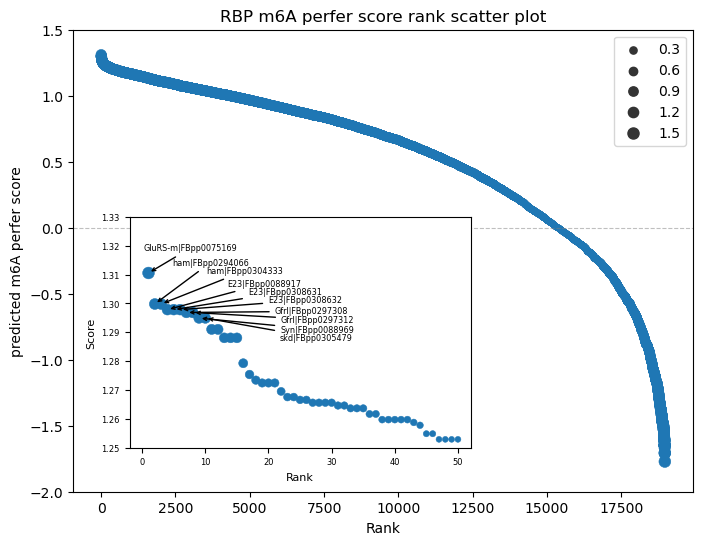

In [ ]:
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
matplotlib.rcParams['pdf.fonttype'] = 42

fig = plt.figure(figsize=(8, 6))
# ax1
ax1 = fig.add_subplot(1, 1, 1)
sns.scatterplot(data=df_for_plot, 
                x=df_for_plot.index + 1, 
                y=df_for_plot.predict_mps, 
                size=np.abs(df_for_plot.predict_mps),
                edgecolor=None,
                linewidths=0
                )
ax1.axhline(y=0, color='grey', linestyle='--', lw=0.8, alpha=0.5)
ax1.set_ylim(-2, 1.5)
ax1.set_xlabel("Rank")
ax1.set_ylabel("predicted m6A perfer score")
ax1.set_title("RBP m6A perfer score rank scatter plot")
ax1.legend(loc="upper right")

# Create a local enlargement drawing
ax_inset = inset_axes(ax1, width="50%", height="50%", loc='lower left', 
                        bbox_to_anchor=[0.08, 0.08, 1.1, 1], bbox_transform=ax1.transAxes)
#
df_mps_top = df_for_plot.head(n=50)
sns.scatterplot(
    data=df_mps_top,
    x=df_mps_top.index + 1,
    y=df_mps_top.predict_mps,
    size=np.abs(df_mps_top.predict_mps),
    linewidths=0,
    edgecolor=None,
    ax=ax_inset,
    legend=None
)
ax_inset.set_xlim(-2, 52)
ax_inset.set_ylim(1.25, 1.33)
ax_inset.set_xlabel("Rank", fontsize=8)
ax_inset.set_ylabel("Score", fontsize=8)
ax_inset.tick_params(axis='both', which='major', labelsize=6)

# The top 10 proteins with the highest scores are labeled
# for pro_idx in list(range(11)):
#     ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[pro_idx].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[pro_idx]+1, df_mps_top.predict_mps[pro_idx]), 
#                 xytext=(50, 15), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[0].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[0]+1, df_mps_top.predict_mps[0]), 
                xytext=(30, 16), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[1].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[1]+1, df_mps_top.predict_mps[1]), 
                xytext=(40, 28), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[2].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[2]+1, df_mps_top.predict_mps[2]), 
                xytext=(60, 22), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[3].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[3]+1, df_mps_top.predict_mps[3]), 
                xytext=(70, 17), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[4].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[4]+1, df_mps_top.predict_mps[4]), 
                xytext=(80, 11), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[5].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[5]+1, df_mps_top.predict_mps[5]), 
                xytext=(90, 5), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[6].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[6]+1, df_mps_top.predict_mps[6]), 
                xytext=(90, -1), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[7].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[7]+1, df_mps_top.predict_mps[7]), 
                xytext=(90, -7), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[8].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[8]+1, df_mps_top.predict_mps[8]), 
                xytext=(85, -10), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[9].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[9]+1, df_mps_top.predict_mps[9]), 
                xytext=(80, -16), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))

# plt.savefig("all_Drosophila_proteins_max_predicted_m6A_perfer_score_rank_scatter_plot.pdf")
plt.show()


## elegans (Caenorhabditis elegans)

### Load all protein sequences and perform preprocessing

In [ ]:
df = pd.read_csv("Caenorhabditis_elegans.WBcel235.pep.all.fa.reshaped_for_predict.txt", sep="\t", header=None)
print(df.shape)
df.head()

(31863, 2)


,0,1
0,aap-1|WBGene00000001|Y110A7A.10.1|Y110A7A.10.1,MSTTPGTPHGVTHSLMEQGWYWADADRSAVSKALSDQPDGSFIVRN...
1,aat-1|WBGene00000002|F27C8.1.1|F27C8.1.1,MTAEKEPLKSREGDEAPQNETEGKGKGLEKSLTLFNGVSMIVGCII...
2,aat-2|WBGene00000003|F07C3.7.1|F07C3.7.1,MNEKEEEVSLNQIKLKPRISLFNGCTIIIGVIIGSGIFVSPKGVLL...
3,aat-3|WBGene00000004|F52H2.2a.1|F52H2.2a.1,MGKQEQSEPLNQEPSNEHHDEEVGDKGLEKTMTLFNGVSIIVGCII...
4,aat-3|WBGene00000004|F52H2.2b.1|F52H2.2b.1,MSAHSSSFALCPSNGRHTHTHTHKQGLDGHTTIRPKMGKQEQSEPL...


In [92]:
processed_df = process_input("Caenorhabditis_elegans.WBcel235.pep.all.fa.reshaped_for_predict.txt")
print(processed_df.shape)
processed_df.head()
# 30s

(182530, 5)


,protein_id,protein_AAstr,peptide_id,peptide_AAstr,encoded_AAstr
0,aap-1|WBGene00000001|Y110A7A.10.1|Y110A7A.10.1,MSTTPGTPHGVTHSLMEQGWYWADADRSAVSKALSDQPDGSFIVRN...,aap-1|WBGene00000001|Y110A7A.10.1|Y110A7A.10.1...,MSTTPGTPHGVTHSLMEQGWYWADADRSAVSKALSDQPDGSFIVRN...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,..."
1,aap-1|WBGene00000001|Y110A7A.10.1|Y110A7A.10.1,MSTTPGTPHGVTHSLMEQGWYWADADRSAVSKALSDQPDGSFIVRN...,aap-1|WBGene00000001|Y110A7A.10.1|Y110A7A.10.1...,GDYTLSVKFAAQVKLLRIVVKDGKCGFNTDSLTHDSVVRLIEFHRN...,"[[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,aap-1|WBGene00000001|Y110A7A.10.1|Y110A7A.10.1,MSTTPGTPHGVTHSLMEQGWYWADADRSAVSKALSDQPDGSFIVRN...,aap-1|WBGene00000001|Y110A7A.10.1|Y110A7A.10.1...,IFNDALDVRLLYPVSVRRNSQNGKPFFKKGQLQQRMILSAKNDHDW...,"[[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,..."
3,aap-1|WBGene00000001|Y110A7A.10.1|Y110A7A.10.1,MSTTPGTPHGVTHSLMEQGWYWADADRSAVSKALSDQPDGSFIVRN...,aap-1|WBGene00000001|Y110A7A.10.1|Y110A7A.10.1...,EMENLRAVHLAFERGAKLYDSAHQEMERAESLYHALNQSVRDNEIK...,"[[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,aap-1|WBGene00000001|Y110A7A.10.1|Y110A7A.10.1,MSTTPGTPHGVTHSLMEQGWYWADADRSAVSKALSDQPDGSFIVRN...,aap-1|WBGene00000001|Y110A7A.10.1|Y110A7A.10.1...,NNLLEAETDVVTQIQGSQTTSEMLKGAFANNKTFVEESIRRINTEL...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,..."


### Feature extraction

In [ ]:
X =  np.array(processed_df['encoded_AAstr'].tolist())
print(X.shape)
X

(182530, 300, 20)


array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 1],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

### Prediction

In [ ]:
with tf.device('/GPU:0'):
    pred = my_model.predict(X)
    print(pred.shape)
    pred
# ~ 30s

(182530, 1)


In [95]:
pred.flatten().tolist()

[0.66748046875,
 0.7333984375,
 -0.1248779296875,
 -0.326416015625,
 -0.30126953125,
 -0.39599609375,
 0.91552734375,
 0.66845703125,
 0.77587890625,
 0.91162109375,
 0.56298828125,
 -0.1923828125,
 -0.642578125,
 0.41650390625,
 -0.0931396484375,
 -0.194580078125,
 -0.345458984375,
 0.31591796875,
 0.78173828125,
 0.79541015625,
 0.95458984375,
 0.126953125,
 -0.09722900390625,
 0.218017578125,
 0.8486328125,
 1.0185546875,
 0.95458984375,
 -1.32421875,
 -0.1568603515625,
 0.89111328125,
 0.11553955078125,
 -0.21484375,
 0.1376953125,
 0.3505859375,
 -0.158203125,
 0.1904296875,
 0.79296875,
 0.68505859375,
 0.88427734375,
 -1.1865234375,
 -0.2421875,
 0.3837890625,
 0.4111328125,
 0.81298828125,
 0.8798828125,
 -0.89501953125,
 -0.283935546875,
 0.2744140625,
 0.53662109375,
 0.84228515625,
 0.8798828125,
 -0.05059814453125,
 0.160888671875,
 -0.20849609375,
 0.276123046875,
 0.51806640625,
 -0.96044921875,
 -0.5712890625,
 -0.29443359375,
 -0.488037109375,
 -0.03778076171875,
 -0.59

### Add prediction results

In [96]:
processed_df["predict_mps"] = pred.flatten().tolist()
processed_df.head()

,protein_id,protein_AAstr,peptide_id,peptide_AAstr,encoded_AAstr,predict_mps
0,aap-1|WBGene00000001|Y110A7A.10.1|Y110A7A.10.1,MSTTPGTPHGVTHSLMEQGWYWADADRSAVSKALSDQPDGSFIVRN...,aap-1|WBGene00000001|Y110A7A.10.1|Y110A7A.10.1...,MSTTPGTPHGVTHSLMEQGWYWADADRSAVSKALSDQPDGSFIVRN...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,...",0.667480
1,aap-1|WBGene00000001|Y110A7A.10.1|Y110A7A.10.1,MSTTPGTPHGVTHSLMEQGWYWADADRSAVSKALSDQPDGSFIVRN...,aap-1|WBGene00000001|Y110A7A.10.1|Y110A7A.10.1...,GDYTLSVKFAAQVKLLRIVVKDGKCGFNTDSLTHDSVVRLIEFHRN...,"[[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.733398
2,aap-1|WBGene00000001|Y110A7A.10.1|Y110A7A.10.1,MSTTPGTPHGVTHSLMEQGWYWADADRSAVSKALSDQPDGSFIVRN...,aap-1|WBGene00000001|Y110A7A.10.1|Y110A7A.10.1...,IFNDALDVRLLYPVSVRRNSQNGKPFFKKGQLQQRMILSAKNDHDW...,"[[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,...",-0.124878
3,aap-1|WBGene00000001|Y110A7A.10.1|Y110A7A.10.1,MSTTPGTPHGVTHSLMEQGWYWADADRSAVSKALSDQPDGSFIVRN...,aap-1|WBGene00000001|Y110A7A.10.1|Y110A7A.10.1...,EMENLRAVHLAFERGAKLYDSAHQEMERAESLYHALNQSVRDNEIK...,"[[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",-0.326416
4,aap-1|WBGene00000001|Y110A7A.10.1|Y110A7A.10.1,MSTTPGTPHGVTHSLMEQGWYWADADRSAVSKALSDQPDGSFIVRN...,aap-1|WBGene00000001|Y110A7A.10.1|Y110A7A.10.1...,NNLLEAETDVVTQIQGSQTTSEMLKGAFANNKTFVEESIRRINTEL...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,...",-0.301270


In [97]:
processed_df = processed_df.drop("encoded_AAstr", axis=1)
processed_df.to_csv("Caenorhabditis_elegans.WBcel235.pep.all.fa.reshaped_for_predict.peptide_wtih_mps.xls", sep="\t", header=True, index=False)
print(processed_df.shape)
processed_df.head()

(182530, 5)


,protein_id,protein_AAstr,peptide_id,peptide_AAstr,predict_mps
0,aap-1|WBGene00000001|Y110A7A.10.1|Y110A7A.10.1,MSTTPGTPHGVTHSLMEQGWYWADADRSAVSKALSDQPDGSFIVRN...,aap-1|WBGene00000001|Y110A7A.10.1|Y110A7A.10.1...,MSTTPGTPHGVTHSLMEQGWYWADADRSAVSKALSDQPDGSFIVRN...,0.667480
1,aap-1|WBGene00000001|Y110A7A.10.1|Y110A7A.10.1,MSTTPGTPHGVTHSLMEQGWYWADADRSAVSKALSDQPDGSFIVRN...,aap-1|WBGene00000001|Y110A7A.10.1|Y110A7A.10.1...,GDYTLSVKFAAQVKLLRIVVKDGKCGFNTDSLTHDSVVRLIEFHRN...,0.733398
2,aap-1|WBGene00000001|Y110A7A.10.1|Y110A7A.10.1,MSTTPGTPHGVTHSLMEQGWYWADADRSAVSKALSDQPDGSFIVRN...,aap-1|WBGene00000001|Y110A7A.10.1|Y110A7A.10.1...,IFNDALDVRLLYPVSVRRNSQNGKPFFKKGQLQQRMILSAKNDHDW...,-0.124878
3,aap-1|WBGene00000001|Y110A7A.10.1|Y110A7A.10.1,MSTTPGTPHGVTHSLMEQGWYWADADRSAVSKALSDQPDGSFIVRN...,aap-1|WBGene00000001|Y110A7A.10.1|Y110A7A.10.1...,EMENLRAVHLAFERGAKLYDSAHQEMERAESLYHALNQSVRDNEIK...,-0.326416
4,aap-1|WBGene00000001|Y110A7A.10.1|Y110A7A.10.1,MSTTPGTPHGVTHSLMEQGWYWADADRSAVSKALSDQPDGSFIVRN...,aap-1|WBGene00000001|Y110A7A.10.1|Y110A7A.10.1...,NNLLEAETDVVTQIQGSQTTSEMLKGAFANNKTFVEESIRRINTEL...,-0.301270


### Get the maximum m6A prefer score for each protein

In [ ]:
idx = processed_df.groupby('protein_id')['predict_mps'].idxmax()
protein_result_df = processed_df.loc[idx].reset_index(drop=True)
protein_result_df.to_csv("Caenorhabditis_elegans.WBcel235.pep.all.fa.reshaped_for_predict.protein_max_mps.xls", sep="\t", header=True, index=False)
print(protein_result_df.shape)
protein_result_df.head()


(31746, 5)


,protein_id,protein_AAstr,peptide_id,peptide_AAstr,predict_mps
0,2L52.1|WBGene00007063|2L52.1a.1|2L52.1a.1,MSMVRNVSNQSEKLEILSCKWVGCLKSTEVFKTVEKLLDHVTADHI...,2L52.1|WBGene00007063|2L52.1a.1|2L52.1a.1:128-427,KERLKEFKSSTDHIEPTQANRVWTIVNGEVQWKTPPRVKKKTVIYY...,0.722656
1,2L52.1|WBGene00007063|2L52.1b.1|2L52.1b.1,MSDNEEVYVNFRGMNCISTGKSASMVPSKRRNWPKRVKKRLSTQRN...,2L52.1|WBGene00007063|2L52.1b.1|2L52.1b.1,MSDNEEVYVNFRGMNCISTGKSASMVPSKRRNWPKRVKKRLSTQRN...,0.831543
2,AC3.12|WBGene00077503|AC3.12.1|AC3.12.1,MQWSNMLCSRGLVKGEQMENYVKETCETGMKYCFESYSKGTEDFDT...,AC3.12|WBGene00077503|AC3.12.1|AC3.12.1,MQWSNMLCSRGLVKGEQMENYVKETCETGMKYCFESYSKGTEDFDT...,-0.578613
3,AC3.5|WBGene00007071|AC3.5a.1|AC3.5a.1,MEDVDLGKDRTQLIDFVYANGNGSASNLNNRNNIPLSEKAAKEPLQ...,AC3.5|WBGene00007071|AC3.5a.1|AC3.5a.1:451-751,VAVPGFQTGNRVSPSFIVLPEEDILYNEQSNDINQKTRIARMISNR...,1.031250
4,AC3.5|WBGene00007071|AC3.5b.1|AC3.5b.1,MMQFKSANESMTTCKNFTRSHKKHQDIVNEEDADENASIKQPTKEE...,AC3.5|WBGene00007071|AC3.5b.1|AC3.5b.1:451-751,QPLRVKNVFSSADIAEIDHEFIGKKGAAVLRMIQKSVGVNVFNKAI...,1.082031


### Scatter plot of the ranking of predicted protein scores

In [293]:
import pandas as pd
protein_result_file = "Caenorhabditis_elegans.WBcel235.pep.all.fa.reshaped_for_predict.protein_max_mps.xls"
protein_result_df = pd.read_csv(protein_result_file, sep="\t", usecols=["protein_id", "predict_mps"])
print(protein_result_df.shape)
protein_result_df.head()


(31746, 2)


,protein_id,predict_mps
0,2L52.1|WBGene00007063|2L52.1a.1|2L52.1a.1,0.722656
1,2L52.1|WBGene00007063|2L52.1b.1|2L52.1b.1,0.831543
2,AC3.12|WBGene00077503|AC3.12.1|AC3.12.1,-0.578613
3,AC3.5|WBGene00007071|AC3.5a.1|AC3.5a.1,1.031250
4,AC3.5|WBGene00007071|AC3.5b.1|AC3.5b.1,1.082031


In [294]:
protein_result_df.predict_mps.describe()

count    31746.000000
mean         0.304397
std          0.643733
min         -2.056641
25%         -0.127197
50%          0.408203
75%          0.848145
max          1.287109
Name: predict_mps, dtype: float64

In [295]:
df_for_plot = protein_result_df.sort_values(by="predict_mps", ascending=False)
df_for_plot.reset_index(drop=True, inplace=True)
df_for_plot.head(n=50)

,protein_id,predict_mps
0,C09G1.2|WBGene00007484|C09G1.2.1|C09G1.2.1,1.287109
1,vbh-1|WBGene00006888|Y54E10A.9a.1|Y54E10A.9a.1,1.279297
2,aak-2|WBGene00020142|T01C8.1c.1|T01C8.1c.1,1.277344
3,eri-12|WBGene00007091|B0001.6.1|B0001.6.1,1.277344
4,eri-12|WBGene00007091|B0001.6.2|B0001.6.2,1.277344
5,laf-1|WBGene00002244|Y71H2AM.19.1|Y71H2AM.19.1,1.276367
6,vbh-1|WBGene00006888|Y54E10A.9c.2|Y54E10A.9c.2,1.274414
7,vbh-1|WBGene00006888|Y54E10A.9c.1|Y54E10A.9c.1,1.274414
8,rgr-1|WBGene00004343|C38C10.5b.1|C38C10.5b.1,1.269531
9,pigg-1|WBGene00009204|F28C6.4a.1|F28C6.4a.1,1.267578


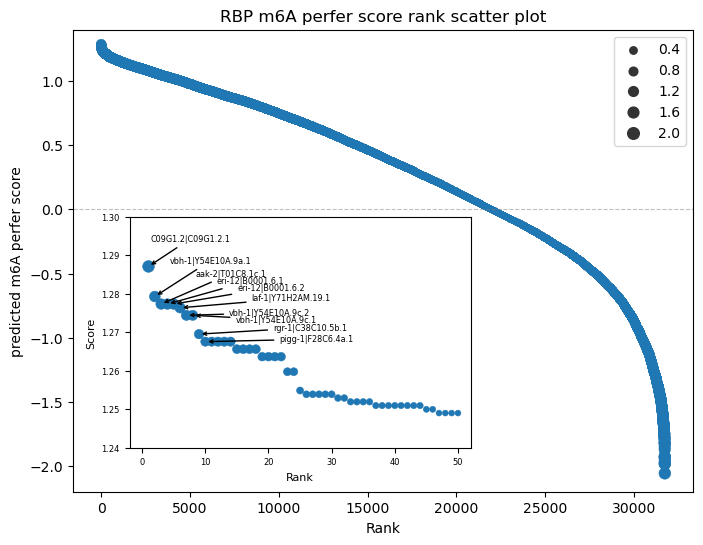

In [ ]:
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
matplotlib.rcParams['pdf.fonttype'] = 42

fig = plt.figure(figsize=(8, 6))
# ax1
ax1 = fig.add_subplot(1, 1, 1)
sns.scatterplot(data=df_for_plot, 
                x=df_for_plot.index + 1, 
                y=df_for_plot.predict_mps, 
                size=np.abs(df_for_plot.predict_mps),
                edgecolor=None,
                linewidths=0
                )
ax1.axhline(y=0, color='grey', linestyle='--', lw=0.8, alpha=0.5)
ax1.set_ylim(-2.2, 1.4)
ax1.set_xlabel("Rank")
ax1.set_ylabel("predicted m6A perfer score")
ax1.set_title("RBP m6A perfer score rank scatter plot")
ax1.legend(loc="upper right")

# Create a local enlargement drawing
ax_inset = inset_axes(ax1, width="50%", height="50%", loc='lower left', 
                        bbox_to_anchor=[0.08, 0.08, 1.1, 1], bbox_transform=ax1.transAxes)
#
df_mps_top = df_for_plot.head(n=50)
sns.scatterplot(
    data=df_mps_top,
    x=df_mps_top.index + 1,
    y=df_mps_top.predict_mps,
    size=np.abs(df_mps_top.predict_mps),
    linewidths=0,
    edgecolor=None,
    ax=ax_inset,
    legend=None
)
ax_inset.set_xlim(-2, 52)
ax_inset.set_ylim(1.24, 1.30)
ax_inset.set_xlabel("Rank", fontsize=8)
ax_inset.set_ylabel("Score", fontsize=8)
ax_inset.tick_params(axis='both', which='major', labelsize=6)

# The top 10 proteins with the highest scores are labeled
# for pro_idx in list(range(11)):
#     ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[pro_idx].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[pro_idx]+1, df_mps_top.predict_mps[pro_idx]), 
#                 xytext=(50, 15), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[0].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[0]+1, df_mps_top.predict_mps[0]), 
                xytext=(30, 18), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[1].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[1]+1, df_mps_top.predict_mps[1]), 
                xytext=(40, 24), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[2].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[2]+1, df_mps_top.predict_mps[2]), 
                xytext=(50, 20), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[3].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[3]+1, df_mps_top.predict_mps[3]), 
                xytext=(60, 15), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[4].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[4]+1, df_mps_top.predict_mps[4]), 
                xytext=(70, 10), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[5].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[5]+1, df_mps_top.predict_mps[5]), 
                xytext=(80, 5), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[6].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[6]+1, df_mps_top.predict_mps[6]), 
                xytext=(60, 0), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[7].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[7]+1, df_mps_top.predict_mps[7]), 
                xytext=(60, -5), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[8].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[8]+1, df_mps_top.predict_mps[8]), 
                xytext=(80, 3), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[9].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[9]+1, df_mps_top.predict_mps[9]), 
                xytext=(80, 0), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))

# plt.savefig("all_C_elegans_proteins_max_predicted_m6A_perfer_score_rank_scatter_plot.pdf")
plt.show()


## Yeast (Saccharomyces cerevisiae)

### Load all protein sequences and perform preprocessing

In [ ]:
df = pd.read_csv("Saccharomyces_cerevisiae.R64-1-1.pep.all.fa.reshaped_for_predict.txt", sep="\t", header=None)
print(df.shape)
df.head()

(5101, 2)


,0,1
0,COF1|YLL050C|YLL050C_mRNA|YLL050C,MSRSGVAVADESLTAFNDLKLGKKYKFILFGLNDAKTEIVVKETST...
1,HOT1|YMR172W|YMR172W_mRNA|YMR172W,MSGMGIAILCIVRTKIYRITISFDYSTLMSPFFLFLMMPTTLKDGY...
2,GSP2|YOR185C|YOR185C_mRNA|YOR185C,MSAPAQNNAEVPTFKLVLVGDGGTGKTTFVKRHLTGEFEKKYIATI...
3,YEF1|YEL041W|YEL041W_mRNA|YEL041W,MKTDRLLINASPETCTKGDAEMDTMDTIDRMTSVKVLAEGKVLSNF...
4,HES1|YOR237W|YOR237W_mRNA|YOR237W,MSQHASSSSWTSFLKSISSFNGDLSSLSAPPFILSPTSLTEFSQYW...


In [100]:
processed_df = process_input("Saccharomyces_cerevisiae.R64-1-1.pep.all.fa.reshaped_for_predict.txt")
print(processed_df.shape)
processed_df.head()
# 5s

(31640, 5)


,protein_id,protein_AAstr,peptide_id,peptide_AAstr,encoded_AAstr
0,COF1|YLL050C|YLL050C_mRNA|YLL050C,MSRSGVAVADESLTAFNDLKLGKKYKFILFGLNDAKTEIVVKETST...,COF1|YLL050C|YLL050C_mRNA|YLL050C,MSRSGVAVADESLTAFNDLKLGKKYKFILFGLNDAKTEIVVKETST...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,..."
1,HOT1|YMR172W|YMR172W_mRNA|YMR172W,MSGMGIAILCIVRTKIYRITISFDYSTLMSPFFLFLMMPTTLKDGY...,HOT1|YMR172W|YMR172W_mRNA|YMR172W:1-301,MSGMGIAILCIVRTKIYRITISFDYSTLMSPFFLFLMMPTTLKDGY...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,..."
2,HOT1|YMR172W|YMR172W_mRNA|YMR172W,MSGMGIAILCIVRTKIYRITISFDYSTLMSPFFLFLMMPTTLKDGY...,HOT1|YMR172W|YMR172W_mRNA|YMR172W:51-351,QVNEDAIGINLDLSLPTHISPTTGSESASGSNASTLRNDGNALDGG...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,..."
3,HOT1|YMR172W|YMR172W_mRNA|YMR172W,MSGMGIAILCIVRTKIYRITISFDYSTLMSPFFLFLMMPTTLKDGY...,HOT1|YMR172W|YMR172W_mRNA|YMR172W:101-401,SAAISAPTGTSQPTETIGEKLSNEERVNSNVSASNSTTAGTGRMLS...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,HOT1|YMR172W|YMR172W_mRNA|YMR172W,MSGMGIAILCIVRTKIYRITISFDYSTLMSPFFLFLMMPTTLKDGY...,HOT1|YMR172W|YMR172W_mRNA|YMR172W:151-451,NDSPSNEISTDQLKIFQRMDEMSARMIEMEESFNKLSNKIAEQNTM...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,..."


### Feature extraction

In [ ]:
X =  np.array(processed_df['encoded_AAstr'].tolist())
print(X.shape)
X

(31640, 300, 20)


array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[1, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

### Prediction

In [ ]:
with tf.device('/GPU:0'):
    pred = my_model.predict(X)
    print(pred.shape)
    pred
# ~ 3s

(31640, 1)


In [103]:
pred.flatten().tolist()

[0.306884765625,
 -1.5244140625,
 -1.31640625,
 -0.9326171875,
 0.08026123046875,
 0.59814453125,
 0.16455078125,
 0.857421875,
 -0.468017578125,
 -1.2529296875,
 -1.4599609375,
 -0.66259765625,
 0.97412109375,
 0.61279296875,
 0.06817626953125,
 0.09039306640625,
 0.11480712890625,
 0.79736328125,
 1.0185546875,
 0.94287109375,
 0.80517578125,
 0.6455078125,
 0.76318359375,
 -0.195068359375,
 -1.3232421875,
 0.66650390625,
 0.32666015625,
 0.98388671875,
 1.150390625,
 0.6650390625,
 1.015625,
 0.96240234375,
 0.75244140625,
 -1.1025390625,
 -1.0009765625,
 0.5,
 -0.24365234375,
 0.0341796875,
 -0.3388671875,
 -0.1351318359375,
 -0.5712890625,
 -0.411376953125,
 0.8583984375,
 0.95263671875,
 1.0361328125,
 1.177734375,
 1.0732421875,
 1.1201171875,
 0.0284423828125,
 -1.2080078125,
 -1.0107421875,
 -1.18359375,
 0.28125,
 0.48828125,
 0.60400390625,
 0.95263671875,
 0.345458984375,
 0.70263671875,
 0.306640625,
 0.218994140625,
 -0.52783203125,
 0.25634765625,
 0.98779296875,
 0.6748

### Add prediction results

In [104]:
processed_df["predict_mps"] = pred.flatten().tolist()
processed_df.head()

,protein_id,protein_AAstr,peptide_id,peptide_AAstr,encoded_AAstr,predict_mps
0,COF1|YLL050C|YLL050C_mRNA|YLL050C,MSRSGVAVADESLTAFNDLKLGKKYKFILFGLNDAKTEIVVKETST...,COF1|YLL050C|YLL050C_mRNA|YLL050C,MSRSGVAVADESLTAFNDLKLGKKYKFILFGLNDAKTEIVVKETST...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,...",0.306885
1,HOT1|YMR172W|YMR172W_mRNA|YMR172W,MSGMGIAILCIVRTKIYRITISFDYSTLMSPFFLFLMMPTTLKDGY...,HOT1|YMR172W|YMR172W_mRNA|YMR172W:1-301,MSGMGIAILCIVRTKIYRITISFDYSTLMSPFFLFLMMPTTLKDGY...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,...",-1.524414
2,HOT1|YMR172W|YMR172W_mRNA|YMR172W,MSGMGIAILCIVRTKIYRITISFDYSTLMSPFFLFLMMPTTLKDGY...,HOT1|YMR172W|YMR172W_mRNA|YMR172W:51-351,QVNEDAIGINLDLSLPTHISPTTGSESASGSNASTLRNDGNALDGG...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,...",-1.316406
3,HOT1|YMR172W|YMR172W_mRNA|YMR172W,MSGMGIAILCIVRTKIYRITISFDYSTLMSPFFLFLMMPTTLKDGY...,HOT1|YMR172W|YMR172W_mRNA|YMR172W:101-401,SAAISAPTGTSQPTETIGEKLSNEERVNSNVSASNSTTAGTGRMLS...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",-0.932617
4,HOT1|YMR172W|YMR172W_mRNA|YMR172W,MSGMGIAILCIVRTKIYRITISFDYSTLMSPFFLFLMMPTTLKDGY...,HOT1|YMR172W|YMR172W_mRNA|YMR172W:151-451,NDSPSNEISTDQLKIFQRMDEMSARMIEMEESFNKLSNKIAEQNTM...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,...",0.080261


In [105]:
processed_df = processed_df.drop("encoded_AAstr", axis=1)
processed_df.to_csv("Saccharomyces_cerevisiae.R64-1-1.pep.all.fa.reshaped_for_predict.peptide_wtih_mps.xls", sep="\t", header=True, index=False)
print(processed_df.shape)
processed_df.head()

(31640, 5)


,protein_id,protein_AAstr,peptide_id,peptide_AAstr,predict_mps
0,COF1|YLL050C|YLL050C_mRNA|YLL050C,MSRSGVAVADESLTAFNDLKLGKKYKFILFGLNDAKTEIVVKETST...,COF1|YLL050C|YLL050C_mRNA|YLL050C,MSRSGVAVADESLTAFNDLKLGKKYKFILFGLNDAKTEIVVKETST...,0.306885
1,HOT1|YMR172W|YMR172W_mRNA|YMR172W,MSGMGIAILCIVRTKIYRITISFDYSTLMSPFFLFLMMPTTLKDGY...,HOT1|YMR172W|YMR172W_mRNA|YMR172W:1-301,MSGMGIAILCIVRTKIYRITISFDYSTLMSPFFLFLMMPTTLKDGY...,-1.524414
2,HOT1|YMR172W|YMR172W_mRNA|YMR172W,MSGMGIAILCIVRTKIYRITISFDYSTLMSPFFLFLMMPTTLKDGY...,HOT1|YMR172W|YMR172W_mRNA|YMR172W:51-351,QVNEDAIGINLDLSLPTHISPTTGSESASGSNASTLRNDGNALDGG...,-1.316406
3,HOT1|YMR172W|YMR172W_mRNA|YMR172W,MSGMGIAILCIVRTKIYRITISFDYSTLMSPFFLFLMMPTTLKDGY...,HOT1|YMR172W|YMR172W_mRNA|YMR172W:101-401,SAAISAPTGTSQPTETIGEKLSNEERVNSNVSASNSTTAGTGRMLS...,-0.932617
4,HOT1|YMR172W|YMR172W_mRNA|YMR172W,MSGMGIAILCIVRTKIYRITISFDYSTLMSPFFLFLMMPTTLKDGY...,HOT1|YMR172W|YMR172W_mRNA|YMR172W:151-451,NDSPSNEISTDQLKIFQRMDEMSARMIEMEESFNKLSNKIAEQNTM...,0.080261


### Get the maximum m6A prefer score for each protein

In [ ]:
idx = processed_df.groupby('protein_id')['predict_mps'].idxmax()
protein_result_df = processed_df.loc[idx].reset_index(drop=True)
protein_result_df.to_csv("Saccharomyces_cerevisiae.R64-1-1.pep.all.fa.reshaped_for_predict.protein_max_mps.xls", sep="\t", header=True, index=False)
print(protein_result_df.shape)
protein_result_df.head()


(5101, 5)


,protein_id,protein_AAstr,peptide_id,peptide_AAstr,predict_mps
0,AAC1|YMR056C|YMR056C_mRNA|YMR056C,MSHTETQTQQSHFGVDFLMGGVSAAIAKTGAAPIERVKLLMQNQEE...,AAC1|YMR056C|YMR056C_mRNA|YMR056C:10-309,QSHFGVDFLMGGVSAAIAKTGAAPIERVKLLMQNQEEMLKQGSLDT...,0.455566
1,AAC3|YBR085W|YBR085W_mRNA|YBR085W,MSSDAKQQETNFAINFLMGGVSAAIAKTAASPIERVKILIQNQDEM...,AAC3|YBR085W|YBR085W_mRNA|YBR085W:8-307,QETNFAINFLMGGVSAAIAKTAASPIERVKILIQNQDEMIKQGTLD...,-0.085999
2,AAD10|YJR155W|YJR155W_mRNA|YJR155W,MASRKLRDQIVIATKFTTDYKGYDVGKGKSANFCGNHKRSLHVSVR...,AAD10|YJR155W|YJR155W_mRNA|YJR155W,MASRKLRDQIVIATKFTTDYKGYDVGKGKSANFCGNHKRSLHVSVR...,-0.327148
3,AAD14|YNL331C|YNL331C_mRNA|YNL331C,MTDLFKPLPEPPTELGRLRVLSKTAGIRVSPLILGGASIGDAWSGF...,AAD14|YNL331C|YNL331C_mRNA|YNL331C:77-376,QNEESEIWIGEWMASRKLRDQIVIATKFTGDYKKYEVGGGKSANYC...,-1.164062
4,AAD15|YOL165C|YOL165C_mRNA|YOL165C,MARHFGMALAPWDVMGGGRFQSKKAMEERRKNGECIRSFVGASEQT...,AAD15|YOL165C|YOL165C_mRNA|YOL165C,MARHFGMALAPWDVMGGGRFQSKKAMEERRKNGECIRSFVGASEQT...,0.159424


### Scatter plot of the ranking of predicted protein scores

In [301]:
import pandas as pd
protein_result_file = "Saccharomyces_cerevisiae.R64-1-1.pep.all.fa.reshaped_for_predict.protein_max_mps.xls"
protein_result_df = pd.read_csv(protein_result_file, sep="\t", usecols=["protein_id", "predict_mps"])
print(protein_result_df.shape)
protein_result_df.head()

(5101, 2)


,protein_id,predict_mps
0,AAC1|YMR056C|YMR056C_mRNA|YMR056C,0.455566
1,AAC3|YBR085W|YBR085W_mRNA|YBR085W,-0.085999
2,AAD10|YJR155W|YJR155W_mRNA|YJR155W,-0.327148
3,AAD14|YNL331C|YNL331C_mRNA|YNL331C,-1.164062
4,AAD15|YOL165C|YOL165C_mRNA|YOL165C,0.159424


In [302]:
protein_result_df.predict_mps.describe()

count    5101.000000
mean        0.373516
std         0.625969
min        -1.936523
25%        -0.023010
50%         0.491699
75%         0.897949
max         1.289062
Name: predict_mps, dtype: float64

In [303]:
df_for_plot = protein_result_df.sort_values(by="predict_mps", ascending=False)
df_for_plot.reset_index(drop=True, inplace=True)
df_for_plot.head(n=50)

,protein_id,predict_mps
0,PSD2|YGR170W|YGR170W_mRNA|YGR170W,1.289062
1,MAK5|YBR142W|YBR142W_mRNA|YBR142W,1.284180
2,SEY1|YOR165W|YOR165W_mRNA|YOR165W,1.271484
3,ALY2|YJL084C|YJL084C_mRNA|YJL084C,1.271484
4,GDE1|YPL110C|YPL110C_mRNA|YPL110C,1.265625
5,DBP1|YPL119C|YPL119C_mRNA|YPL119C,1.263672
6,ALY1|YKR021W|YKR021W_mRNA|YKR021W,1.262695
7,DED1|YOR204W|YOR204W_mRNA|YOR204W,1.260742
8,BDF1|YLR399C|YLR399C_mRNA|YLR399C,1.257812
9,PHO8|YDR481C|YDR481C_mRNA|YDR481C,1.252930


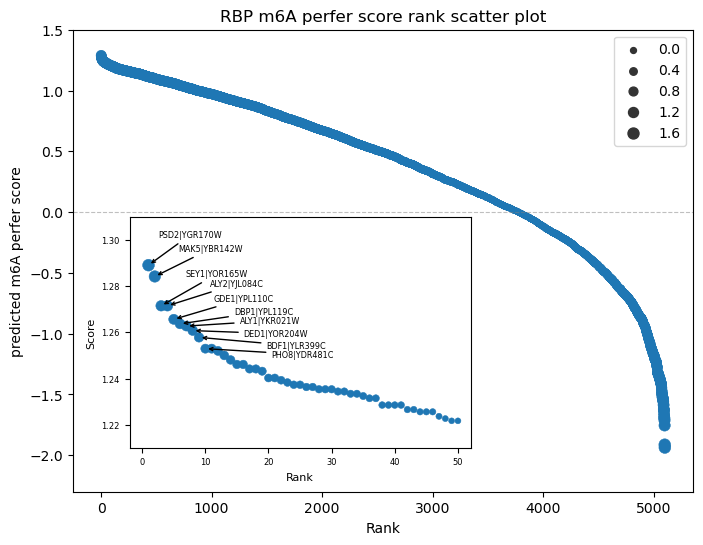

In [ ]:
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
matplotlib.rcParams['pdf.fonttype'] = 42

fig = plt.figure(figsize=(8, 6))
# ax1
ax1 = fig.add_subplot(1, 1, 1)
sns.scatterplot(data=df_for_plot, 
                x=df_for_plot.index + 1, 
                y=df_for_plot.predict_mps, 
                size=np.abs(df_for_plot.predict_mps),
                edgecolor=None,
                linewidths=0
                )
ax1.axhline(y=0, color='grey', linestyle='--', lw=0.8, alpha=0.5)
ax1.set_ylim(-2.3, 1.5)
ax1.set_xlabel("Rank")
ax1.set_ylabel("predicted m6A perfer score")
ax1.set_title("RBP m6A perfer score rank scatter plot")
ax1.legend(loc="upper right")

# Create a local enlargement drawing
ax_inset = inset_axes(ax1, width="50%", height="50%", loc='lower left', 
                        bbox_to_anchor=[0.08, 0.08, 1.1, 1], bbox_transform=ax1.transAxes)
#
df_mps_top = df_for_plot.head(n=50)
sns.scatterplot(
    data=df_mps_top,
    x=df_mps_top.index + 1,
    y=df_mps_top.predict_mps,
    size=np.abs(df_mps_top.predict_mps),
    linewidths=0,
    edgecolor=None,
    ax=ax_inset,
    legend=None
)
ax_inset.set_xlim(-2, 52)
ax_inset.set_ylim(1.21, 1.31)
ax_inset.set_xlabel("Rank", fontsize=8)
ax_inset.set_ylabel("Score", fontsize=8)
ax_inset.tick_params(axis='both', which='major', labelsize=6)

# The top 10 proteins with the highest scores are labeled
# for pro_idx in list(range(11)):
#     ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[pro_idx].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[pro_idx]+1, df_mps_top.predict_mps[pro_idx]), 
#                 xytext=(50, 15), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[0].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[0]+1, df_mps_top.predict_mps[0]), 
                xytext=(30, 20), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[1].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[1]+1, df_mps_top.predict_mps[1]), 
                xytext=(40, 18), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[2].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[2]+1, df_mps_top.predict_mps[2]), 
                xytext=(40, 21), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[3].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[3]+1, df_mps_top.predict_mps[3]), 
                xytext=(50, 14), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[4].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[4]+1, df_mps_top.predict_mps[4]), 
                xytext=(50, 13), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[5].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[5]+1, df_mps_top.predict_mps[5]), 
                xytext=(60, 7), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[6].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[6]+1, df_mps_top.predict_mps[6]), 
                xytext=(60, 2), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[7].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[7]+1, df_mps_top.predict_mps[7]), 
                xytext=(60, -4), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[8].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[8]+1, df_mps_top.predict_mps[8]), 
                xytext=(70, -8), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[9].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[9]+1, df_mps_top.predict_mps[9]), 
                xytext=(70, -6), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))

# plt.savefig("all_yeast_proteins_max_predicted_m6A_perfer_score_rank_scatter_plot.pdf")
plt.show()


## Arabidopsis (Arabidopsis thaliana)

### Load all protein sequences and perform preprocessing

In [ ]:
df = pd.read_csv("Arabidopsis_thaliana.TAIR10.pep.all.fa.reshaped_for_predict.txt", sep="\t", header=None)
print(df.shape)
df.head()

(47450, 2)


,0,1
0,AER|AT5G16970|AT5G16970.1|AT5G16970.1,MTATNKQVILKDYVSGFPTESDFDFTTTTVELRVPEGTNSVLVKNL...
1,AT4G32100|AT4G32100|AT4G32100.1|AT4G32100.1,MATNACKFLCLVLLFAFVTQGYGDDSYSLESLSVIQSKTGNMVENK...
2,AT2G43120|AT2G43120|AT2G43120.2|AT2G43120.2,MAHNQFKDSLDPLSSINRHTESQHQNTSKIRLLPRKATKKKKREEK...
3,AT2G43120|AT2G43120|AT2G43120.1|AT2G43120.1,MRAAINRANSLGGLFSFRFIRNIKSMSSSTSQDFVSRPVIKKVFAK...
4,AT1G30814|AT1G30814|AT1G30814.1|AT1G30814.1,MKDHERAILEERINYYLAKRTERIVFAELDTGGKIIECPNCHVQFT...


In [108]:
processed_df = process_input("Arabidopsis_thaliana.TAIR10.pep.all.fa.reshaped_for_predict.txt")
print(processed_df.shape)
processed_df.head()
# 35s

(231088, 5)


,protein_id,protein_AAstr,peptide_id,peptide_AAstr,encoded_AAstr
0,AER|AT5G16970|AT5G16970.1|AT5G16970.1,MTATNKQVILKDYVSGFPTESDFDFTTTTVELRVPEGTNSVLVKNL...,AER|AT5G16970|AT5G16970.1|AT5G16970.1:1-301,MTATNKQVILKDYVSGFPTESDFDFTTTTVELRVPEGTNSVLVKNL...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,..."
1,AER|AT5G16970|AT5G16970.1|AT5G16970.1,MTATNKQVILKDYVSGFPTESDFDFTTTTVELRVPEGTNSVLVKNL...,AER|AT5G16970|AT5G16970.1|AT5G16970.1:46-345,LYLSCDPYMRIRMGKPDPSTAALAQAYTPGQPIQGYGVSRIIESGH...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,..."
2,AT4G32100|AT4G32100|AT4G32100.1|AT4G32100.1,MATNACKFLCLVLLFAFVTQGYGDDSYSLESLSVIQSKTGNMVENK...,AT4G32100|AT4G32100|AT4G32100.1|AT4G32100.1,MATNACKFLCLVLLFAFVTQGYGDDSYSLESLSVIQSKTGNMVENK...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,..."
3,AT2G43120|AT2G43120|AT2G43120.2|AT2G43120.2,MAHNQFKDSLDPLSSINRHTESQHQNTSKIRLLPRKATKKKKREEK...,AT2G43120|AT2G43120|AT2G43120.2|AT2G43120.2:1-301,MAHNQFKDSLDPLSSINRHTESQHQNTSKIRLLPRKATKKKKREEK...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,..."
4,AT2G43120|AT2G43120|AT2G43120.2|AT2G43120.2,MAHNQFKDSLDPLSSINRHTESQHQNTSKIRLLPRKATKKKKREEK...,AT2G43120|AT2G43120|AT2G43120.2|AT2G43120.2:51...,YMRAAINRANSLGGLFSFRFIRNIKSMSSSTSQDFVSRPVIKKVFA...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


### Feature extraction

In [ ]:
X =  np.array(processed_df['encoded_AAstr'].tolist())
print(X.shape)
X

(231088, 300, 20)


array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

### Prediction

In [ ]:
with tf.device('/GPU:0'):
    pred = my_model.predict(X)
    print(pred.shape)
    pred
# ~22s

(231088, 1)


In [111]:
pred.flatten().tolist()

[-0.63720703125,
 -0.478515625,
 -0.008544921875,
 0.228271484375,
 0.5791015625,
 -0.110595703125,
 0.231689453125,
 -0.110595703125,
 0.71630859375,
 0.62548828125,
 0.70703125,
 0.67529296875,
 0.71630859375,
 0.62548828125,
 0.79638671875,
 0.8662109375,
 0.81298828125,
 0.75341796875,
 0.7177734375,
 0.7333984375,
 1.0341796875,
 0.66552734375,
 0.568359375,
 -0.51611328125,
 -0.319580078125,
 -1.4541015625,
 -1.3974609375,
 -1.0439453125,
 -0.6474609375,
 -0.47216796875,
 -0.580078125,
 0.7177734375,
 0.7333984375,
 1.0341796875,
 0.66552734375,
 0.568359375,
 -0.48046875,
 -0.04278564453125,
 -1.47265625,
 -1.384765625,
 -0.96337890625,
 -0.5751953125,
 -0.5244140625,
 -0.44970703125,
 0.7177734375,
 0.7333984375,
 1.0341796875,
 0.66552734375,
 0.568359375,
 -0.51611328125,
 -0.319580078125,
 -1.4541015625,
 -1.3974609375,
 -1.0439453125,
 -0.6474609375,
 -0.47216796875,
 -0.44970703125,
 0.7177734375,
 0.7333984375,
 1.0341796875,
 0.66552734375,
 0.568359375,
 -0.51611328125,

### Add prediction results

In [112]:
processed_df["predict_mps"] = pred.flatten().tolist()
processed_df.head()

,protein_id,protein_AAstr,peptide_id,peptide_AAstr,encoded_AAstr,predict_mps
0,AER|AT5G16970|AT5G16970.1|AT5G16970.1,MTATNKQVILKDYVSGFPTESDFDFTTTTVELRVPEGTNSVLVKNL...,AER|AT5G16970|AT5G16970.1|AT5G16970.1:1-301,MTATNKQVILKDYVSGFPTESDFDFTTTTVELRVPEGTNSVLVKNL...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,...",-0.637207
1,AER|AT5G16970|AT5G16970.1|AT5G16970.1,MTATNKQVILKDYVSGFPTESDFDFTTTTVELRVPEGTNSVLVKNL...,AER|AT5G16970|AT5G16970.1|AT5G16970.1:46-345,LYLSCDPYMRIRMGKPDPSTAALAQAYTPGQPIQGYGVSRIIESGH...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,...",-0.478516
2,AT4G32100|AT4G32100|AT4G32100.1|AT4G32100.1,MATNACKFLCLVLLFAFVTQGYGDDSYSLESLSVIQSKTGNMVENK...,AT4G32100|AT4G32100|AT4G32100.1|AT4G32100.1,MATNACKFLCLVLLFAFVTQGYGDDSYSLESLSVIQSKTGNMVENK...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,...",-0.008545
3,AT2G43120|AT2G43120|AT2G43120.2|AT2G43120.2,MAHNQFKDSLDPLSSINRHTESQHQNTSKIRLLPRKATKKKKREEK...,AT2G43120|AT2G43120|AT2G43120.2|AT2G43120.2:1-301,MAHNQFKDSLDPLSSINRHTESQHQNTSKIRLLPRKATKKKKREEK...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,...",0.228271
4,AT2G43120|AT2G43120|AT2G43120.2|AT2G43120.2,MAHNQFKDSLDPLSSINRHTESQHQNTSKIRLLPRKATKKKKREEK...,AT2G43120|AT2G43120|AT2G43120.2|AT2G43120.2:51...,YMRAAINRANSLGGLFSFRFIRNIKSMSSSTSQDFVSRPVIKKVFA...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.579102


In [113]:
processed_df = processed_df.drop("encoded_AAstr", axis=1)
processed_df.to_csv("Arabidopsis_thaliana.TAIR10.pep.all.fa.reshaped_for_predict.peptide_wtih_mps.xls", sep="\t", header=True, index=False)
print(processed_df.shape)
processed_df.head()

(231088, 5)


,protein_id,protein_AAstr,peptide_id,peptide_AAstr,predict_mps
0,AER|AT5G16970|AT5G16970.1|AT5G16970.1,MTATNKQVILKDYVSGFPTESDFDFTTTTVELRVPEGTNSVLVKNL...,AER|AT5G16970|AT5G16970.1|AT5G16970.1:1-301,MTATNKQVILKDYVSGFPTESDFDFTTTTVELRVPEGTNSVLVKNL...,-0.637207
1,AER|AT5G16970|AT5G16970.1|AT5G16970.1,MTATNKQVILKDYVSGFPTESDFDFTTTTVELRVPEGTNSVLVKNL...,AER|AT5G16970|AT5G16970.1|AT5G16970.1:46-345,LYLSCDPYMRIRMGKPDPSTAALAQAYTPGQPIQGYGVSRIIESGH...,-0.478516
2,AT4G32100|AT4G32100|AT4G32100.1|AT4G32100.1,MATNACKFLCLVLLFAFVTQGYGDDSYSLESLSVIQSKTGNMVENK...,AT4G32100|AT4G32100|AT4G32100.1|AT4G32100.1,MATNACKFLCLVLLFAFVTQGYGDDSYSLESLSVIQSKTGNMVENK...,-0.008545
3,AT2G43120|AT2G43120|AT2G43120.2|AT2G43120.2,MAHNQFKDSLDPLSSINRHTESQHQNTSKIRLLPRKATKKKKREEK...,AT2G43120|AT2G43120|AT2G43120.2|AT2G43120.2:1-301,MAHNQFKDSLDPLSSINRHTESQHQNTSKIRLLPRKATKKKKREEK...,0.228271
4,AT2G43120|AT2G43120|AT2G43120.2|AT2G43120.2,MAHNQFKDSLDPLSSINRHTESQHQNTSKIRLLPRKATKKKKREEK...,AT2G43120|AT2G43120|AT2G43120.2|AT2G43120.2:51...,YMRAAINRANSLGGLFSFRFIRNIKSMSSSTSQDFVSRPVIKKVFA...,0.579102


### Get the maximum m6A prefer score for each protein

In [ ]:
idx = processed_df.groupby('protein_id')['predict_mps'].idxmax()
protein_result_df = processed_df.loc[idx].reset_index(drop=True)
protein_result_df.to_csv("Arabidopsis_thaliana.TAIR10.pep.all.fa.reshaped_for_predict.protein_max_mps.xls", sep="\t", header=True, index=False)
print(protein_result_df.shape)
protein_result_df.head()


(47450, 5)


,protein_id,protein_AAstr,peptide_id,peptide_AAstr,predict_mps
0,2-Cys|AT5G06290|AT5G06290.1|AT5G06290.1,MSMASIASSSSTTLLSSSRVLLPSKSSLLSPTVSFPRIIPSSSASS...,2-Cys|AT5G06290|AT5G06290.1|AT5G06290.1,MSMASIASSSSTTLLSSSRVLLPSKSSLLSPTVSFPRIIPSSSASS...,0.086609
1,2-Cys|AT5G06290|AT5G06290.2|AT5G06290.2,MSMASIASSSSTTLLSSSRVLLPSKSSLLSPTVSFPRIIPSSSASS...,2-Cys|AT5G06290|AT5G06290.2|AT5G06290.2,MSMASIASSSSTTLLSSSRVLLPSKSSLLSPTVSFPRIIPSSSASS...,-0.176636
2,2A6|AT1G03410|AT1G03410.1|AT1G03410.1,MGHDSFCYLIVLRCALRCGIIALMQICALQKKERRSKMESSDRSSQ...,2A6|AT1G03410|AT1G03410.1|AT1G03410.1:1-301,MGHDSFCYLIVLRCALRCGIIALMQICALQKKERRSKMESSDRSSQ...,-0.022644
3,2A6|AT1G03410|AT1G03410.2|AT1G03410.2,MESSDRSSQAKAFDETKTGVKGLVASGIKEIPAMFHTPPDTLTSLK...,2A6|AT1G03410|AT1G03410.2|AT1G03410.2:1-301,MESSDRSSQAKAFDETKTGVKGLVASGIKEIPAMFHTPPDTLTSLK...,0.133301
4,3xHMG-box1|AT4G11080|AT4G11080.1|AT4G11080.1,MSTVSSDPAHAKKSRNSRKALKQKNEIVESSPVSDKGKETKSFEKD...,3xHMG-box1|AT4G11080|AT4G11080.1|AT4G11080.1:1...,VKKQNPEADFKETSNILGAKWKGISAEEKKPYEEKYQADKEAYLQV...,0.453125


### Scatter plot of the ranking of predicted protein scores

In [312]:
import pandas as pd
protein_result_file = "Arabidopsis_thaliana.TAIR10.pep.all.fa.reshaped_for_predict.protein_max_mps.xls"
protein_result_df = pd.read_csv(protein_result_file, sep="\t", usecols=["protein_id", "predict_mps"])
print(protein_result_df.shape)
protein_result_df.head()


(47450, 2)


,protein_id,predict_mps
0,2-Cys|AT5G06290|AT5G06290.1|AT5G06290.1,0.086609
1,2-Cys|AT5G06290|AT5G06290.2|AT5G06290.2,-0.176636
2,2A6|AT1G03410|AT1G03410.1|AT1G03410.1,-0.022644
3,2A6|AT1G03410|AT1G03410.2|AT1G03410.2,0.133301
4,3xHMG-box1|AT4G11080|AT4G11080.1|AT4G11080.1,0.453125


In [313]:
protein_result_df.predict_mps.describe()

count    47450.000000
mean         0.261723
std          0.664653
min         -2.197266
25%         -0.174316
50%          0.372803
75%          0.809570
max          1.307617
Name: predict_mps, dtype: float64

In [314]:
df_for_plot = protein_result_df.sort_values(by="predict_mps", ascending=False)
df_for_plot.reset_index(drop=True, inplace=True)
df_for_plot.head(n=50)

,protein_id,predict_mps
0,AT4G31630|AT4G31630|AT4G31630.1|AT4G31630.1,1.307617
1,AT2G35140|AT2G35140|AT2G35140.6|AT2G35140.6,1.303711
2,AT2G35140|AT2G35140|AT2G35140.4|AT2G35140.4,1.279297
3,AT2G35140|AT2G35140|AT2G35140.3|AT2G35140.3,1.279297
4,AT2G35140|AT2G35140|AT2G35140.2|AT2G35140.2,1.279297
5,AT2G35140|AT2G35140|AT2G35140.1|AT2G35140.1,1.279297
6,AT2G35140|AT2G35140|AT2G35140.5|AT2G35140.5,1.279297
7,IBM1|AT3G07610|AT3G07610.1|AT3G07610.1,1.277344
8,AT5G46520|AT5G46520|AT5G46520.1|AT5G46520.1,1.277344
9,AT1G70620|AT1G70620|AT1G70620.3|AT1G70620.3,1.276367


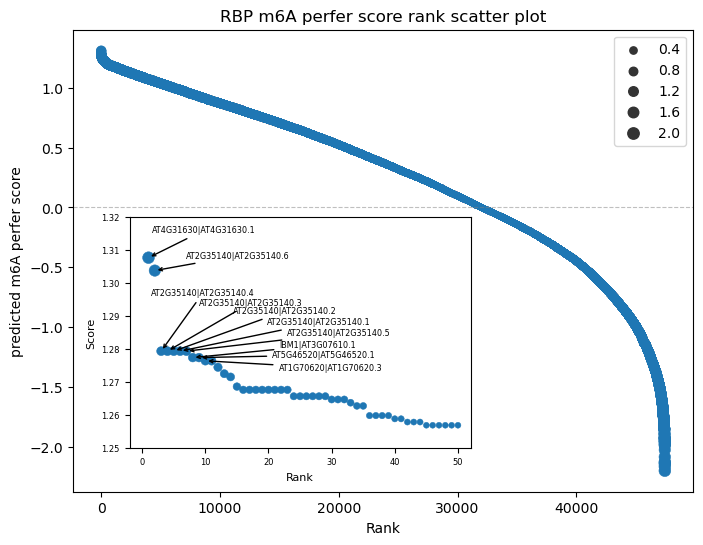

In [ ]:
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
matplotlib.rcParams['pdf.fonttype'] = 42

fig = plt.figure(figsize=(8, 6))
# ax1
ax1 = fig.add_subplot(1, 1, 1)
sns.scatterplot(data=df_for_plot, 
                x=df_for_plot.index + 1, 
                y=df_for_plot.predict_mps, 
                size=np.abs(df_for_plot.predict_mps),
                edgecolor=None,
                linewidths=0
                )
ax1.axhline(y=0, color='grey', linestyle='--', lw=0.8, alpha=0.5)
ax1.set_xlabel("Rank")
ax1.set_ylabel("predicted m6A perfer score")
ax1.set_title("RBP m6A perfer score rank scatter plot")
ax1.legend(loc="upper right")

# Create a local enlargement drawing
ax_inset = inset_axes(ax1, width="50%", height="50%", loc='lower left', 
                        bbox_to_anchor=[0.08, 0.08, 1.1, 1], bbox_transform=ax1.transAxes)
#
df_mps_top = df_for_plot.head(n=50)
sns.scatterplot(
    data=df_mps_top,
    x=df_mps_top.index + 1,
    y=df_mps_top.predict_mps,
    size=np.abs(df_mps_top.predict_mps),
    linewidths=0,
    edgecolor=None,
    ax=ax_inset,
    legend=None
)
ax_inset.set_xlim(-2, 52)
ax_inset.set_ylim(1.25, 1.32)
ax_inset.set_xlabel("Rank", fontsize=8)
ax_inset.set_ylabel("Score", fontsize=8)
ax_inset.tick_params(axis='both', which='major', labelsize=6)

# The top 10 proteins with the highest scores are labeled
# for pro_idx in list(range(11)):
#     ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[pro_idx].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[pro_idx]+1, df_mps_top.predict_mps[pro_idx]), 
#                 xytext=(50, 15), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[0].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[0]+1, df_mps_top.predict_mps[0]), 
                xytext=(40, 18), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[1].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[1]+1, df_mps_top.predict_mps[1]), 
                xytext=(60, 9), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[2].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[2]+1, df_mps_top.predict_mps[2]), 
                xytext=(30, 40), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[3].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[3]+1, df_mps_top.predict_mps[3]), 
                xytext=(60, 33), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[4].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[4]+1, df_mps_top.predict_mps[4]), 
                xytext=(80, 27), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[5].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[5]+1, df_mps_top.predict_mps[5]), 
                xytext=(100, 19), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[6].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[6]+1, df_mps_top.predict_mps[6]), 
                xytext=(110, 11), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[7].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[7]+1, df_mps_top.predict_mps[7]), 
                xytext=(90, 7), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[8].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[8]+1, df_mps_top.predict_mps[8]), 
                xytext=(90, 0), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[9].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[9]+1, df_mps_top.predict_mps[9]), 
                xytext=(90, -7), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))

# plt.savefig("all_Arabidopsis_proteins_max_predicted_m6A_perfer_score_rank_scatter_plot.pdf")
plt.show()


## rice (Oryza sativa)

### Load all protein sequences and perform preprocessing

In [ ]:
df = pd.read_csv("Oryza_sativa.IRGSP-1.0.pep.all.fa.reshaped_for_predict.txt", sep="\t", header=None)
print(df.shape)
df.head()

(42564, 2)


,0,1
0,cds-CAA33989.1|gene-rps2|transcript-rps2|cds-C...,MTRRYWNINLKEMIEAGVHFGHGIKKWNPKMAPYISAKRKGTHITN...
1,cds-CAA33977.1|gene-petB|transcript-petB|cds-C...,MS
2,cds-CAA33920.1|gene-ndhB-2|transcript-ndhB-2|c...,MIWHVQNENFILDSTRIFMKAFHLLLFQGSFIFPECILIFGLILLL...
3,cds-CAA33981.1|gene-rpl36|transcript-rpl36|cds...,MKIRASVRKICTKCRLIRRRGRIRVICSNPKHKQRQG
4,cds-CAA33987.1|gene-rpoC1|transcript-rpoC1|cds...,MIDQYKHQQLQIGLVSPQQIKAWANKTLPNGEVVGEVTRPSTFHYK...


In [116]:
processed_df = process_input("Oryza_sativa.IRGSP-1.0.pep.all.fa.reshaped_for_predict.txt")
print(processed_df.shape)
processed_df.head()
# 25s

(144730, 5)


,protein_id,protein_AAstr,peptide_id,peptide_AAstr,encoded_AAstr
0,cds-CAA33989.1|gene-rps2|transcript-rps2|cds-C...,MTRRYWNINLKEMIEAGVHFGHGIKKWNPKMAPYISAKRKGTHITN...,cds-CAA33989.1|gene-rps2|transcript-rps2|cds-C...,MTRRYWNINLKEMIEAGVHFGHGIKKWNPKMAPYISAKRKGTHITN...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,..."
1,cds-CAA33977.1|gene-petB|transcript-petB|cds-C...,MS,cds-CAA33977.1|gene-petB|transcript-petB|cds-C...,MS,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,..."
2,cds-CAA33920.1|gene-ndhB-2|transcript-ndhB-2|c...,MIWHVQNENFILDSTRIFMKAFHLLLFQGSFIFPECILIFGLILLL...,cds-CAA33920.1|gene-ndhB-2|transcript-ndhB-2|c...,MIWHVQNENFILDSTRIFMKAFHLLLFQGSFIFPECILIFGLILLL...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,..."
3,cds-CAA33981.1|gene-rpl36|transcript-rpl36|cds...,MKIRASVRKICTKCRLIRRRGRIRVICSNPKHKQRQG,cds-CAA33981.1|gene-rpl36|transcript-rpl36|cds...,MKIRASVRKICTKCRLIRRRGRIRVICSNPKHKQRQG,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,..."
4,cds-CAA33987.1|gene-rpoC1|transcript-rpoC1|cds...,MIDQYKHQQLQIGLVSPQQIKAWANKTLPNGEVVGEVTRPSTFHYK...,cds-CAA33987.1|gene-rpoC1|transcript-rpoC1|cds...,MIDQYKHQQLQIGLVSPQQIKAWANKTLPNGEVVGEVTRPSTFHYK...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,..."


### Feature extraction

In [ ]:
X =  np.array(processed_df['encoded_AAstr'].tolist())
print(X.shape)
X

(144730, 300, 20)


array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

### Prediction

In [ ]:
with tf.device('/GPU:0'):
    pred = my_model.predict(X)
    print(pred.shape)
    pred
# ~ 15s

(144730, 1)


In [119]:
pred.flatten().tolist()

[0.12408447265625,
 0.1572265625,
 -0.172607421875,
 0.223876953125,
 0.908203125,
 0.385986328125,
 0.49462890625,
 0.55078125,
 -0.083740234375,
 -0.06805419921875,
 0.274169921875,
 -0.105712890625,
 0.04815673828125,
 -0.122802734375,
 -0.172607421875,
 0.397705078125,
 0.212646484375,
 -0.00677490234375,
 -0.71484375,
 -0.068359375,
 -0.421142578125,
 -1.5341796875,
 -1.330078125,
 0.7724609375,
 0.671875,
 0.023193359375,
 -0.4873046875,
 -0.210693359375,
 0.4453125,
 0.6337890625,
 0.83837890625,
 -0.3955078125,
 -0.30810546875,
 -0.34716796875,
 0.42138671875,
 0.13720703125,
 0.03094482421875,
 -0.09130859375,
 -0.326904296875,
 -0.017791748046875,
 -0.184326171875,
 0.12432861328125,
 -0.182373046875,
 0.6650390625,
 -0.260498046875,
 0.11346435546875,
 -0.09307861328125,
 0.50634765625,
 0.54052734375,
 -0.182373046875,
 0.01947021484375,
 0.07403564453125,
 -0.45166015625,
 0.12054443359375,
 -1.51953125,
 -1.5751953125,
 -1.2822265625,
 -0.468505859375,
 -1.3271484375,
 -0

### Add prediction results

In [120]:
processed_df["predict_mps"] = pred.flatten().tolist()
processed_df.head()

,protein_id,protein_AAstr,peptide_id,peptide_AAstr,encoded_AAstr,predict_mps
0,cds-CAA33989.1|gene-rps2|transcript-rps2|cds-C...,MTRRYWNINLKEMIEAGVHFGHGIKKWNPKMAPYISAKRKGTHITN...,cds-CAA33989.1|gene-rps2|transcript-rps2|cds-C...,MTRRYWNINLKEMIEAGVHFGHGIKKWNPKMAPYISAKRKGTHITN...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,...",0.124084
1,cds-CAA33977.1|gene-petB|transcript-petB|cds-C...,MS,cds-CAA33977.1|gene-petB|transcript-petB|cds-C...,MS,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,...",0.157227
2,cds-CAA33920.1|gene-ndhB-2|transcript-ndhB-2|c...,MIWHVQNENFILDSTRIFMKAFHLLLFQGSFIFPECILIFGLILLL...,cds-CAA33920.1|gene-ndhB-2|transcript-ndhB-2|c...,MIWHVQNENFILDSTRIFMKAFHLLLFQGSFIFPECILIFGLILLL...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,...",-0.172607
3,cds-CAA33981.1|gene-rpl36|transcript-rpl36|cds...,MKIRASVRKICTKCRLIRRRGRIRVICSNPKHKQRQG,cds-CAA33981.1|gene-rpl36|transcript-rpl36|cds...,MKIRASVRKICTKCRLIRRRGRIRVICSNPKHKQRQG,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,...",0.223877
4,cds-CAA33987.1|gene-rpoC1|transcript-rpoC1|cds...,MIDQYKHQQLQIGLVSPQQIKAWANKTLPNGEVVGEVTRPSTFHYK...,cds-CAA33987.1|gene-rpoC1|transcript-rpoC1|cds...,MIDQYKHQQLQIGLVSPQQIKAWANKTLPNGEVVGEVTRPSTFHYK...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,...",0.908203


In [121]:
processed_df = processed_df.drop("encoded_AAstr", axis=1)
processed_df.to_csv("Oryza_sativa.IRGSP-1.0.pep.all.fa.reshaped_for_predict.peptide_wtih_mps.xls", sep="\t", header=True, index=False)
print(processed_df.shape)
processed_df.head()

(144730, 5)


,protein_id,protein_AAstr,peptide_id,peptide_AAstr,predict_mps
0,cds-CAA33989.1|gene-rps2|transcript-rps2|cds-C...,MTRRYWNINLKEMIEAGVHFGHGIKKWNPKMAPYISAKRKGTHITN...,cds-CAA33989.1|gene-rps2|transcript-rps2|cds-C...,MTRRYWNINLKEMIEAGVHFGHGIKKWNPKMAPYISAKRKGTHITN...,0.124084
1,cds-CAA33977.1|gene-petB|transcript-petB|cds-C...,MS,cds-CAA33977.1|gene-petB|transcript-petB|cds-C...,MS,0.157227
2,cds-CAA33920.1|gene-ndhB-2|transcript-ndhB-2|c...,MIWHVQNENFILDSTRIFMKAFHLLLFQGSFIFPECILIFGLILLL...,cds-CAA33920.1|gene-ndhB-2|transcript-ndhB-2|c...,MIWHVQNENFILDSTRIFMKAFHLLLFQGSFIFPECILIFGLILLL...,-0.172607
3,cds-CAA33981.1|gene-rpl36|transcript-rpl36|cds...,MKIRASVRKICTKCRLIRRRGRIRVICSNPKHKQRQG,cds-CAA33981.1|gene-rpl36|transcript-rpl36|cds...,MKIRASVRKICTKCRLIRRRGRIRVICSNPKHKQRQG,0.223877
4,cds-CAA33987.1|gene-rpoC1|transcript-rpoC1|cds...,MIDQYKHQQLQIGLVSPQQIKAWANKTLPNGEVVGEVTRPSTFHYK...,cds-CAA33987.1|gene-rpoC1|transcript-rpoC1|cds...,MIDQYKHQQLQIGLVSPQQIKAWANKTLPNGEVVGEVTRPSTFHYK...,0.908203


### Get the maximum m6A prefer score for each protein

In [122]:
# 对于每个蛋白取最大的 m6A prefer score
idx = processed_df.groupby('protein_id')['predict_mps'].idxmax()
protein_result_df = processed_df.loc[idx].reset_index(drop=True)
protein_result_df.to_csv("Oryza_sativa.IRGSP-1.0.pep.all.fa.reshaped_for_predict.protein_max_mps.xls", sep="\t", header=True, index=False)
print(protein_result_df.shape)
protein_result_df.head()

(42564, 5)


,protein_id,protein_AAstr,peptide_id,peptide_AAstr,predict_mps
0,Os01t0100100-01|Os01g0100100|Os01t0100100-01|O...,MSSAAGQDNGDTAGDYIKWMCGAGGRAGGAMANLQRGVGSLVRDIG...,Os01t0100100-01|Os01g0100100|Os01t0100100-01|O...,HSFQINNNIDLIIESNSCSSDVFRASNSDSAIFHSDAYKQDRWLDD...,0.247314
1,Os01t0100200-01|Os01g0100200|Os01t0100200-01|O...,MEEAGERDADETHAWSGTASPAALWKTVASSAAMLKLALAMISAAF...,Os01t0100200-01|Os01g0100200|Os01t0100200-01|O...,MEEAGERDADETHAWSGTASPAALWKTVASSAAMLKLALAMISAAF...,-1.210938
2,Os01t0100300-00|Os01g0100300|Os01t0100300-00|O...,VCQLAHYIVTAQPHAHVRERPRHGRGRRVGSPPLHRRPCLLRHQPQ...,Os01t0100300-00|Os01g0100300|Os01t0100300-00|O...,VCQLAHYIVTAQPHAHVRERPRHGRGRRVGSPPLHRRPCLLRHQPQ...,0.379639
3,Os01t0100400-01|Os01g0100400|Os01t0100400-01|O...,MDSIRRRSAGGILGILFLVLLRWAGAGDPYAYYEWEVSYVWGAPLG...,Os01t0100400-01|Os01g0100400|Os01t0100400-01|O...,DGVGGTNCGIPPGWNWTYQFQVKDQVGSFFYAPSTALHRAAGGYGA...,0.686523
4,Os01t0100466-00|Os01g0100466|Os01t0100466-00|O...,MPQFVPPTPSCQGLLRCCTPCHVSSSGSSRPFLTFTTRFQLVVTFS...,Os01t0100466-00|Os01g0100466|Os01t0100466-00|O...,MPQFVPPTPSCQGLLRCCTPCHVSSSGSSRPFLTFTTRFQLVVTFS...,0.010559


### Scatter plot of the ranking of predicted protein scores

In [323]:
import pandas as pd
protein_result_file = "Oryza_sativa.IRGSP-1.0.pep.all.fa.reshaped_for_predict.protein_max_mps.xls"
protein_result_df = pd.read_csv(protein_result_file, sep="\t", usecols=["protein_id", "predict_mps"])
print(protein_result_df.shape)
protein_result_df.head()


(42564, 2)


,protein_id,predict_mps
0,Os01t0100100-01|Os01g0100100|Os01t0100100-01|O...,0.247314
1,Os01t0100200-01|Os01g0100200|Os01t0100200-01|O...,-1.210938
2,Os01t0100300-00|Os01g0100300|Os01t0100300-00|O...,0.379639
3,Os01t0100400-01|Os01g0100400|Os01t0100400-01|O...,0.686523
4,Os01t0100466-00|Os01g0100466|Os01t0100466-00|O...,0.010559


In [324]:
protein_result_df.predict_mps.describe()

count    42564.000000
mean         0.199875
std          0.654863
min         -2.517578
25%         -0.232666
50%          0.267090
75%          0.739868
max          1.290039
Name: predict_mps, dtype: float64

In [325]:
df_for_plot = protein_result_df.sort_values(by="predict_mps", ascending=False)
df_for_plot.reset_index(drop=True, inplace=True)
df_for_plot.head(n=50)

,protein_id,predict_mps
0,Os12t0564800-01|Os12g0564800|Os12t0564800-01|O...,1.290039
1,Os01t0846300-01|Os01g0846300|Os01t0846300-01|O...,1.286133
2,Os08t0202300-03|Os08g0202300|Os08t0202300-03|O...,1.278320
3,Os01t0180000-01|Os01g0180000|Os01t0180000-01|O...,1.276367
4,Os06t0235200-01|Os06g0235200|Os06t0235200-01|O...,1.274414
5,Os06t0240050-00|Os06g0240050|Os06t0240050-00|O...,1.273438
6,Os03t0152800-03|Os03g0152800|Os03t0152800-03|O...,1.272461
7,Os04t0488700-01|Os04g0488700|Os04t0488700-01|O...,1.271484
8,Os04t0488000-02|Os04g0488000|Os04t0488000-02|O...,1.271484
9,Os04t0488000-01|Os04g0488000|Os04t0488000-01|O...,1.271484


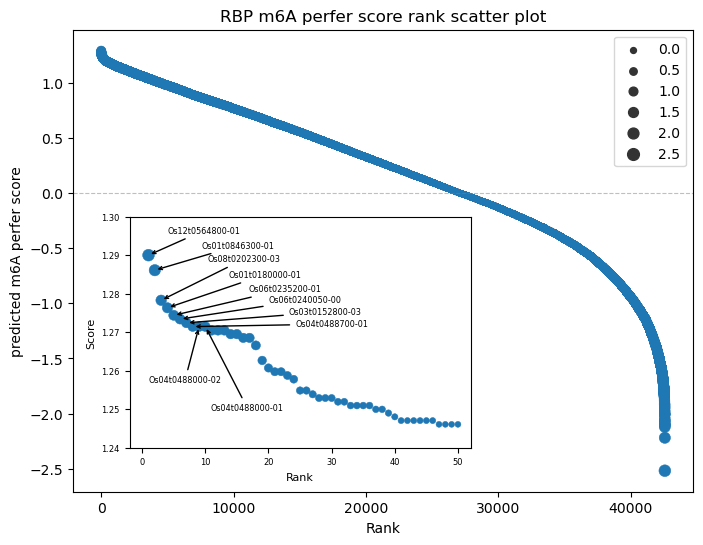

In [ ]:
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
matplotlib.rcParams['pdf.fonttype'] = 42

fig = plt.figure(figsize=(8, 6))
# ax1
ax1 = fig.add_subplot(1, 1, 1)
sns.scatterplot(data=df_for_plot, 
                x=df_for_plot.index + 1, 
                y=df_for_plot.predict_mps, 
                size=np.abs(df_for_plot.predict_mps),
                edgecolor=None,
                linewidths=0
                )
ax1.axhline(y=0, color='grey', linestyle='--', lw=0.8, alpha=0.5)
ax1.set_xlabel("Rank")
ax1.set_ylabel("predicted m6A perfer score")
ax1.set_title("RBP m6A perfer score rank scatter plot")
ax1.legend(loc="upper right")

# Create a local enlargement drawing
ax_inset = inset_axes(ax1, width="50%", height="50%", loc='lower left', 
                        bbox_to_anchor=[0.08, 0.08, 1.1, 1], bbox_transform=ax1.transAxes)
#
df_mps_top = df_for_plot.head(n=50)
sns.scatterplot(
    data=df_mps_top,
    x=df_mps_top.index + 1,
    y=df_mps_top.predict_mps,
    size=np.abs(df_mps_top.predict_mps),
    linewidths=0,
    edgecolor=None,
    ax=ax_inset,
    legend=None
)
ax_inset.set_xlim(-2, 52)
ax_inset.set_ylim(1.24, 1.3)
ax_inset.set_xlabel("Rank", fontsize=8)
ax_inset.set_ylabel("Score", fontsize=8)
ax_inset.tick_params(axis='both', which='major', labelsize=6)

# The top 10 proteins with the highest scores are labeled
# for pro_idx in list(range(11)):
#     ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[pro_idx].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[pro_idx]+1, df_mps_top.predict_mps[pro_idx]), 
#                 xytext=(50, 15), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{df_mps_top.protein_id[0].split("|")[3]}', (df_mps_top.index[0]+1, df_mps_top.predict_mps[0]), 
                xytext=(40, 16), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{df_mps_top.protein_id[1].split("|")[3]}', (df_mps_top.index[1]+1, df_mps_top.predict_mps[1]), 
                xytext=(60, 16), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{df_mps_top.protein_id[2].split("|")[3]}', (df_mps_top.index[2]+1, df_mps_top.predict_mps[2]), 
                xytext=(60, 28), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{df_mps_top.protein_id[3].split("|")[3]}', (df_mps_top.index[3]+1, df_mps_top.predict_mps[3]), 
                xytext=(70, 22), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{df_mps_top.protein_id[4].split("|")[3]}', (df_mps_top.index[4]+1, df_mps_top.predict_mps[4]), 
                xytext=(80, 17), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{df_mps_top.protein_id[5].split("|")[3]}', (df_mps_top.index[5]+1, df_mps_top.predict_mps[5]), 
                xytext=(90, 12), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{df_mps_top.protein_id[6].split("|")[3]}', (df_mps_top.index[6]+1, df_mps_top.predict_mps[6]), 
                xytext=(100, 6), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{df_mps_top.protein_id[7].split("|")[3]}', (df_mps_top.index[7]+1, df_mps_top.predict_mps[7]), 
                xytext=(100, 0), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{df_mps_top.protein_id[8].split("|")[3]}', (df_mps_top.index[8]+1, df_mps_top.predict_mps[8]), 
                xytext=(-10, -40), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{df_mps_top.protein_id[9].split("|")[3]}', (df_mps_top.index[9]+1, df_mps_top.predict_mps[9]), 
                xytext=(30, -60), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))

# plt.savefig("all_rice_proteins_max_predicted_m6A_perfer_score_rank_scatter_plot.pdf")
plt.show()


## wheat (Triticum aestivum)

### Load all protein sequences and perform preprocessing

In [ ]:
df = pd.read_csv("Triticum_aestivum.IWGSC.pep.all.fa.reshaped_for_predict.txt", sep="\t", header=None)
print(df.shape)
df.head()

(132472, 2)


,0,1
0,TraesCS4A02G403700.1|TraesCS4A02G403700|TraesC...,MVKHLPKLWKFHNSSVILDNTKKQDRVRYRSVKESGFIR
1,TraesCS3A02G154800.1|TraesCS3A02G154800|TraesC...,MDDGAAEAEALRLRLAAVARKWLEDPRADYAGKITDAASQKGHALN...
2,TraesCS2B02G516800.1|TraesCS2B02G516800|TraesC...,MAVLSLAACVAFFHLLLLFSSSSSLRVAPEAAESSGSAPHGRTAYH...
3,TraesCS2A02G142500.4|TraesCS2A02G142500|TraesC...,MHPYPLKGSKGASLPPRPTLVFLIALFGLYVCYLSFNQIRMESKHV...
4,TraesCS2A02G142500.1|TraesCS2A02G142500|TraesC...,MHPYPLKGSKGASLPPRPTLVFLIALFGLYVCYLSFNQIRMESKHV...


In [124]:
processed_df = process_input("Triticum_aestivum.IWGSC.pep.all.fa.reshaped_for_predict.txt")
print(processed_df.shape)
processed_df.head()
# 1m40s

(663987, 5)


,protein_id,protein_AAstr,peptide_id,peptide_AAstr,encoded_AAstr
0,TraesCS4A02G403700.1|TraesCS4A02G403700|TraesC...,MVKHLPKLWKFHNSSVILDNTKKQDRVRYRSVKESGFIR,TraesCS4A02G403700.1|TraesCS4A02G403700|TraesC...,MVKHLPKLWKFHNSSVILDNTKKQDRVRYRSVKESGFIR,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,..."
1,TraesCS3A02G154800.1|TraesCS3A02G154800|TraesC...,MDDGAAEAEALRLRLAAVARKWLEDPRADYAGKITDAASQKGHALN...,TraesCS3A02G154800.1|TraesCS3A02G154800|TraesC...,MDDGAAEAEALRLRLAAVARKWLEDPRADYAGKITDAASQKGHALN...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,..."
2,TraesCS2B02G516800.1|TraesCS2B02G516800|TraesC...,MAVLSLAACVAFFHLLLLFSSSSSLRVAPEAAESSGSAPHGRTAYH...,TraesCS2B02G516800.1|TraesCS2B02G516800|TraesC...,MAVLSLAACVAFFHLLLLFSSSSSLRVAPEAAESSGSAPHGRTAYH...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,..."
3,TraesCS2B02G516800.1|TraesCS2B02G516800|TraesC...,MAVLSLAACVAFFHLLLLFSSSSSLRVAPEAAESSGSAPHGRTAYH...,TraesCS2B02G516800.1|TraesCS2B02G516800|TraesC...,KNWQNDPNGPMYHNGMYHLFYQYNPHGATWGVGNLSWGHSVSGDLV...,"[[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,..."
4,TraesCS2B02G516800.1|TraesCS2B02G516800|TraesC...,MAVLSLAACVAFFHLLLLFSSSSSLRVAPEAAESSGSAPHGRTAYH...,TraesCS2B02G516800.1|TraesCS2B02G516800|TraesC...,LDAALEPTSPFDANGCWSGSATILPGGVPAILYTGISADGEQVQNV...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,..."


### Feature extraction

In [ ]:
X =  np.array(processed_df['encoded_AAstr'].tolist())
print(X.shape)
X

(663987, 300, 20)


array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        ...,
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 1, 0, 0]],

       [[0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

### Prediction

In [ ]:
with tf.device('/GPU:0'):
    pred = my_model.predict(X)
    print(pred.shape)
    pred
# ~ 2m55s

(663987, 1)


In [127]:
pred.flatten().tolist()

[0.0472412109375,
 -0.27880859375,
 -1.3642578125,
 -1.3486328125,
 -1.2841796875,
 -0.658203125,
 -0.11077880859375,
 -0.62158203125,
 -0.927734375,
 0.1650390625,
 -0.16650390625,
 0.11578369140625,
 0.150390625,
 -0.1483154296875,
 0.3740234375,
 0.239990234375,
 0.3740234375,
 -0.30615234375,
 -0.316162109375,
 -0.1290283203125,
 -1.041015625,
 1.033203125,
 0.77001953125,
 1.12109375,
 0.69677734375,
 0.9072265625,
 1.2275390625,
 1.1787109375,
 0.77392578125,
 0.94970703125,
 0.12176513671875,
 -0.60791015625,
 -0.393310546875,
 -0.1494140625,
 -0.0174560546875,
 0.179931640625,
 -0.0977783203125,
 0.21044921875,
 0.339111328125,
 0.453125,
 -0.08648681640625,
 -0.151123046875,
 0.149658203125,
 0.179931640625,
 -0.0977783203125,
 0.21044921875,
 0.339111328125,
 0.453125,
 -0.08648681640625,
 -0.15087890625,
 0.5498046875,
 -1.0712890625,
 -1.2666015625,
 -1.287109375,
 -1.09765625,
 -0.92578125,
 0.08294677734375,
 -0.58251953125,
 -0.0048828125,
 -0.70654296875,
 -0.7104492187

### Add prediction results

In [128]:
processed_df["predict_mps"] = pred.flatten().tolist()
processed_df.head()

,protein_id,protein_AAstr,peptide_id,peptide_AAstr,encoded_AAstr,predict_mps
0,TraesCS4A02G403700.1|TraesCS4A02G403700|TraesC...,MVKHLPKLWKFHNSSVILDNTKKQDRVRYRSVKESGFIR,TraesCS4A02G403700.1|TraesCS4A02G403700|TraesC...,MVKHLPKLWKFHNSSVILDNTKKQDRVRYRSVKESGFIR,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,...",0.047241
1,TraesCS3A02G154800.1|TraesCS3A02G154800|TraesC...,MDDGAAEAEALRLRLAAVARKWLEDPRADYAGKITDAASQKGHALN...,TraesCS3A02G154800.1|TraesCS3A02G154800|TraesC...,MDDGAAEAEALRLRLAAVARKWLEDPRADYAGKITDAASQKGHALN...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,...",-0.278809
2,TraesCS2B02G516800.1|TraesCS2B02G516800|TraesC...,MAVLSLAACVAFFHLLLLFSSSSSLRVAPEAAESSGSAPHGRTAYH...,TraesCS2B02G516800.1|TraesCS2B02G516800|TraesC...,MAVLSLAACVAFFHLLLLFSSSSSLRVAPEAAESSGSAPHGRTAYH...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,...",-1.364258
3,TraesCS2B02G516800.1|TraesCS2B02G516800|TraesC...,MAVLSLAACVAFFHLLLLFSSSSSLRVAPEAAESSGSAPHGRTAYH...,TraesCS2B02G516800.1|TraesCS2B02G516800|TraesC...,KNWQNDPNGPMYHNGMYHLFYQYNPHGATWGVGNLSWGHSVSGDLV...,"[[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,...",-1.348633
4,TraesCS2B02G516800.1|TraesCS2B02G516800|TraesC...,MAVLSLAACVAFFHLLLLFSSSSSLRVAPEAAESSGSAPHGRTAYH...,TraesCS2B02G516800.1|TraesCS2B02G516800|TraesC...,LDAALEPTSPFDANGCWSGSATILPGGVPAILYTGISADGEQVQNV...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,...",-1.284180


In [129]:
processed_df = processed_df.drop("encoded_AAstr", axis=1)
processed_df.to_csv("Triticum_aestivum.IWGSC.pep.all.fa.reshaped_for_predict.peptide_wtih_mps.xls", sep="\t", header=True, index=False)
print(processed_df.shape)
processed_df.head()

(663987, 5)


,protein_id,protein_AAstr,peptide_id,peptide_AAstr,predict_mps
0,TraesCS4A02G403700.1|TraesCS4A02G403700|TraesC...,MVKHLPKLWKFHNSSVILDNTKKQDRVRYRSVKESGFIR,TraesCS4A02G403700.1|TraesCS4A02G403700|TraesC...,MVKHLPKLWKFHNSSVILDNTKKQDRVRYRSVKESGFIR,0.047241
1,TraesCS3A02G154800.1|TraesCS3A02G154800|TraesC...,MDDGAAEAEALRLRLAAVARKWLEDPRADYAGKITDAASQKGHALN...,TraesCS3A02G154800.1|TraesCS3A02G154800|TraesC...,MDDGAAEAEALRLRLAAVARKWLEDPRADYAGKITDAASQKGHALN...,-0.278809
2,TraesCS2B02G516800.1|TraesCS2B02G516800|TraesC...,MAVLSLAACVAFFHLLLLFSSSSSLRVAPEAAESSGSAPHGRTAYH...,TraesCS2B02G516800.1|TraesCS2B02G516800|TraesC...,MAVLSLAACVAFFHLLLLFSSSSSLRVAPEAAESSGSAPHGRTAYH...,-1.364258
3,TraesCS2B02G516800.1|TraesCS2B02G516800|TraesC...,MAVLSLAACVAFFHLLLLFSSSSSLRVAPEAAESSGSAPHGRTAYH...,TraesCS2B02G516800.1|TraesCS2B02G516800|TraesC...,KNWQNDPNGPMYHNGMYHLFYQYNPHGATWGVGNLSWGHSVSGDLV...,-1.348633
4,TraesCS2B02G516800.1|TraesCS2B02G516800|TraesC...,MAVLSLAACVAFFHLLLLFSSSSSLRVAPEAAESSGSAPHGRTAYH...,TraesCS2B02G516800.1|TraesCS2B02G516800|TraesC...,LDAALEPTSPFDANGCWSGSATILPGGVPAILYTGISADGEQVQNV...,-1.284180


### Get the maximum m6A prefer score for each protein

In [ ]:
idx = processed_df.groupby('protein_id')['predict_mps'].idxmax()
protein_result_df = processed_df.loc[idx].reset_index(drop=True)
protein_result_df.to_csv("Triticum_aestivum.IWGSC.pep.all.fa.reshaped_for_predict.protein_max_mps.xls", sep="\t", header=True, index=False)
print(protein_result_df.shape)
protein_result_df.head()


(132472, 5)


,protein_id,protein_AAstr,peptide_id,peptide_AAstr,predict_mps
0,TraesCS1A02G000100.1.cds1|TraesCS1A02G000100|T...,MRVIALSAGVTPSLRIGLPMCKCRSHGTFLLFGLQSSHLNICYYHQ...,TraesCS1A02G000100.1.cds1|TraesCS1A02G000100|T...,MRVIALSAGVTPSLRIGLPMCKCRSHGTFLLFGLQSSHLNICYYHQ...,0.033875
1,TraesCS1A02G000200.1.cds1|TraesCS1A02G000200|T...,MVNNLWPMEQCRQGKSAKRIRNFGKRICSEDWAQGSRPRTRRLSAD...,TraesCS1A02G000200.1.cds1|TraesCS1A02G000200|T...,MVNNLWPMEQCRQGKSAKRIRNFGKRICSEDWAQGSRPRTRRLSAD...,-0.945312
2,TraesCS1A02G000300.1.cds1|TraesCS1A02G000300|T...,MEQCRQGKSAKRIRNFGKRIGYEDWARGSRPRTRRLSADCSSCSRG...,TraesCS1A02G000300.1.cds1|TraesCS1A02G000300|T...,MEQCRQGKSAKRIRNFGKRIGYEDWARGSRPRTRRLSADCSSCSRG...,-1.451172
3,TraesCS1A02G000400.1.cds1|TraesCS1A02G000400|T...,MEQCRQGKSAKRIRNFGKRIGSEDWARGSRPRTRRLSADCSSCSRG...,TraesCS1A02G000400.1.cds1|TraesCS1A02G000400|T...,MEQCRQGKSAKRIRNFGKRIGSEDWARGSRPRTRRLSADCSSCSRG...,-1.288086
4,TraesCS1A02G000500.1|TraesCS1A02G000500|TraesC...,MGSPQAVAAQCPEGHAFRRAGTGLADDGHRGHLGPPGFGRRRLGPP...,TraesCS1A02G000500.1|TraesCS1A02G000500|TraesC...,MGSPQAVAAQCPEGHAFRRAGTGLADDGHRGHLGPPGFGRRRLGPP...,-0.046112


### Scatter plot of the ranking of predicted protein scores

In [333]:
import pandas as pd
protein_result_file = "Triticum_aestivum.IWGSC.pep.all.fa.reshaped_for_predict.protein_max_mps.xls"
protein_result_df = pd.read_csv(protein_result_file, sep="\t", usecols=["protein_id", "predict_mps"])
print(protein_result_df.shape)
protein_result_df.head()

(132472, 2)


,protein_id,predict_mps
0,TraesCS1A02G000100.1.cds1|TraesCS1A02G000100|T...,0.033875
1,TraesCS1A02G000200.1.cds1|TraesCS1A02G000200|T...,-0.945312
2,TraesCS1A02G000300.1.cds1|TraesCS1A02G000300|T...,-1.451172
3,TraesCS1A02G000400.1.cds1|TraesCS1A02G000400|T...,-1.288086
4,TraesCS1A02G000500.1|TraesCS1A02G000500|TraesC...,-0.046112


In [334]:
protein_result_df.predict_mps.describe()

count    132472.000000
mean          0.283969
std           0.655365
min          -2.164062
25%          -0.140625
50%           0.400146
75%           0.821289
max           1.324219
Name: predict_mps, dtype: float64

In [335]:
df_for_plot = protein_result_df.sort_values(by="predict_mps", ascending=False)
df_for_plot.reset_index(drop=True, inplace=True)
df_for_plot.head(n=50)

,protein_id,predict_mps
0,TraesCS4A02G122300.4|TraesCS4A02G122300|TraesC...,1.324219
1,TraesCS7A02G004500.1|TraesCS7A02G004500|TraesC...,1.318359
2,TraesCS1A02G119600.1.cds1|TraesCS1A02G119600|T...,1.307617
3,TraesCS1D02G120500.1.cds1|TraesCS1D02G120500|T...,1.303711
4,TraesCS2B02G209000.1|TraesCS2B02G209000|TraesC...,1.302734
5,TraesCS7B02G314100.1|TraesCS7B02G314100|TraesC...,1.300781
6,TraesCS1B02G139000.1.cds1|TraesCS1B02G139000|T...,1.293945
7,TraesCS4A02G122300.2|TraesCS4A02G122300|TraesC...,1.289062
8,TraesCS7A02G149100.3|TraesCS7A02G149100|TraesC...,1.289062
9,TraesCS1A02G388300.1.cds1|TraesCS1A02G388300|T...,1.288086


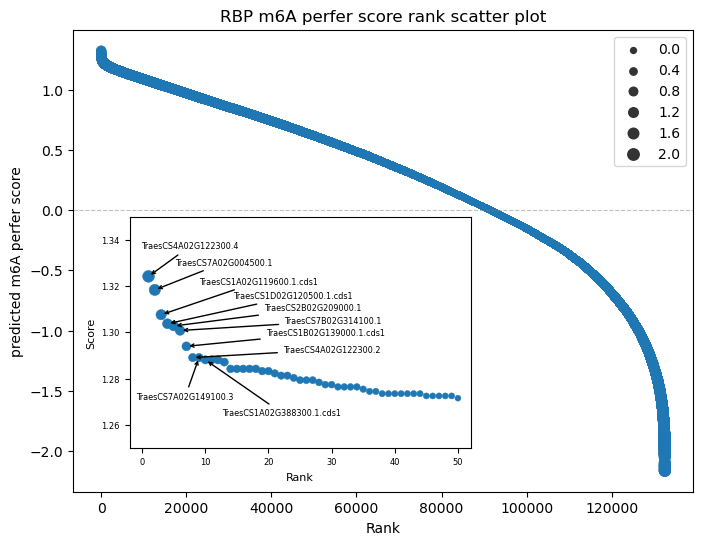

In [ ]:
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
matplotlib.rcParams['pdf.fonttype'] = 42

fig = plt.figure(figsize=(8, 6))
# ax1
ax1 = fig.add_subplot(1, 1, 1)
sns.scatterplot(data=df_for_plot, 
                x=df_for_plot.index + 1, 
                y=df_for_plot.predict_mps, 
                size=np.abs(df_for_plot.predict_mps),
                edgecolor=None,
                linewidths=0
                )
ax1.axhline(y=0, color='grey', linestyle='--', lw=0.8, alpha=0.5)
ax1.set_xlabel("Rank")
ax1.set_ylabel("predicted m6A perfer score")
ax1.set_title("RBP m6A perfer score rank scatter plot")
ax1.legend(loc="upper right")

# Create a local enlargement drawing
ax_inset = inset_axes(ax1, width="50%", height="50%", loc='lower left', 
                        bbox_to_anchor=[0.08, 0.08, 1.1, 1], bbox_transform=ax1.transAxes)
#
df_mps_top = df_for_plot.head(n=50)
sns.scatterplot(
    data=df_mps_top,
    x=df_mps_top.index + 1,
    y=df_mps_top.predict_mps,
    size=np.abs(df_mps_top.predict_mps),
    linewidths=0,
    edgecolor=None,
    ax=ax_inset,
    legend=None
)
ax_inset.set_xlim(-2, 52)
ax_inset.set_ylim(1.25, 1.35)
ax_inset.set_xlabel("Rank", fontsize=8)
ax_inset.set_ylabel("Score", fontsize=8)
ax_inset.tick_params(axis='both', which='major', labelsize=6)

# The top 10 proteins with the highest scores are labeled
# for pro_idx in list(range(11)):
#     ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[pro_idx].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[pro_idx]+1, df_mps_top.predict_mps[pro_idx]), 
#                 xytext=(50, 15), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{df_mps_top.protein_id[0].split("|")[3]}', (df_mps_top.index[0]+1, df_mps_top.predict_mps[0]), 
                xytext=(30, 20), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{df_mps_top.protein_id[1].split("|")[3]}', (df_mps_top.index[1]+1, df_mps_top.predict_mps[1]), 
                xytext=(50, 18), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{df_mps_top.protein_id[2].split("|")[3]}', (df_mps_top.index[2]+1, df_mps_top.predict_mps[2]), 
                xytext=(70, 22), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{df_mps_top.protein_id[3].split("|")[3]}', (df_mps_top.index[3]+1, df_mps_top.predict_mps[3]), 
                xytext=(90, 18), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{df_mps_top.protein_id[4].split("|")[3]}', (df_mps_top.index[4]+1, df_mps_top.predict_mps[4]), 
                xytext=(100, 11), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{df_mps_top.protein_id[5].split("|")[3]}', (df_mps_top.index[5]+1, df_mps_top.predict_mps[5]), 
                xytext=(110, 5), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{df_mps_top.protein_id[6].split("|")[3]}', (df_mps_top.index[6]+1, df_mps_top.predict_mps[6]), 
                xytext=(100, 8), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{df_mps_top.protein_id[7].split("|")[3]}', (df_mps_top.index[7]+1, df_mps_top.predict_mps[7]), 
                xytext=(100, 4), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{df_mps_top.protein_id[8].split("|")[3]}', (df_mps_top.index[8]+1, df_mps_top.predict_mps[8]), 
                xytext=(-10, -30), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{df_mps_top.protein_id[9].split("|")[3]}', (df_mps_top.index[9]+1, df_mps_top.predict_mps[9]), 
                xytext=(55, -40), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))

# plt.savefig("all_wheat_proteins_max_predicted_m6A_perfer_score_rank_scatter_plot.pdf")
plt.show()


## maize (Zea mays)

### Load all protein sequences and perform preprocessing

In [ ]:
df = pd.read_csv("Zea_mays.Zm-B73-REFERENCE-NAM-5.0.pep.all.fa.reshaped_for_predict.txt", sep="\t", header=None)
print(df.shape)
df.head()

(72539, 2)


,0,1
0,Zm00001eb096110_P001|Zm00001eb096110|Zm00001eb...,MDAAALLDAFSAAPRHQLRPAAWCRSTRFASQACRATAPFARADWQ...
1,Zm00001eb321680_P001|Zm00001eb321680|Zm00001eb...,MAGGAGGRDPLVASEIHGFLTCADLNFDKLMMEAGTRWFRPNEIYA...
2,Zm00001eb323640_P001|Zm00001eb323640|Zm00001eb...,MAAAGARLPLALLLPLFVTFFASPASATDTITANSSLSDGQTLVSA...
3,Zm00001eb314140_P001|Zm00001eb314140|Zm00001eb...,MSVVPSLSLTRLSLDNMFLCGILDDMNRFPPIIGTTTLGWWPSRSC...
4,Zm00001eb080260_P001|Zm00001eb080260|Zm00001eb...,MARPAAGAHDVGMALRKAEEAAARRCEAARWLRQMEPAAAESLPER...


In [132]:
processed_df = process_input("Zea_mays.Zm-B73-REFERENCE-NAM-5.0.pep.all.fa.reshaped_for_predict.txt")
print(processed_df.shape)
processed_df.head()
# 1m15s

(311136, 5)


,protein_id,protein_AAstr,peptide_id,peptide_AAstr,encoded_AAstr
0,Zm00001eb096110_P001|Zm00001eb096110|Zm00001eb...,MDAAALLDAFSAAPRHQLRPAAWCRSTRFASQACRATAPFARADWQ...,Zm00001eb096110_P001|Zm00001eb096110|Zm00001eb...,MDAAALLDAFSAAPRHQLRPAAWCRSTRFASQACRATAPFARADWQ...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,..."
1,Zm00001eb096110_P001|Zm00001eb096110|Zm00001eb...,MDAAALLDAFSAAPRHQLRPAAWCRSTRFASQACRATAPFARADWQ...,Zm00001eb096110_P001|Zm00001eb096110|Zm00001eb...,ILASNSTGGAGHDASSNNNAQPAPRVNGQKPPPALEATPTPDELDL...,"[[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,..."
2,Zm00001eb096110_P001|Zm00001eb096110|Zm00001eb...,MDAAALLDAFSAAPRHQLRPAAWCRSTRFASQACRATAPFARADWQ...,Zm00001eb096110_P001|Zm00001eb096110|Zm00001eb...,NLPRPLSISDLSPAPMHGSQLRVAYQGVPGAYSEAAAAKAYPGCDA...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,..."
3,Zm00001eb096110_P001|Zm00001eb096110|Zm00001eb...,MDAAALLDAFSAAPRHQLRPAAWCRSTRFASQACRATAPFARADWQ...,Zm00001eb096110_P001|Zm00001eb096110|Zm00001eb...,VAYQGVPGAYSEAAAAKAYPGCDAIPCDQFEVAFQAVELWIADRAV...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,Zm00001eb321680_P001|Zm00001eb321680|Zm00001eb...,MAGGAGGRDPLVASEIHGFLTCADLNFDKLMMEAGTRWFRPNEIYA...,Zm00001eb321680_P001|Zm00001eb321680|Zm00001eb...,MAGGAGGRDPLVASEIHGFLTCADLNFDKLMMEAGTRWFRPNEIYA...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,..."


### Feature extraction

In [ ]:
X =  np.array(processed_df['encoded_AAstr'].tolist())
print(X.shape)
X

(311136, 300, 20)


array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

### Prediction

In [ ]:
with tf.device('/GPU:0'):
    pred = my_model.predict(X)
    print(pred.shape)
    pred
# ~ 40s

(311136, 1)


In [135]:
pred.flatten().tolist()

[0.53662109375,
 0.56201171875,
 0.228515625,
 0.40380859375,
 -1.3037109375,
 -0.26611328125,
 -0.7021484375,
 -1.734375,
 -0.42333984375,
 -0.0838623046875,
 -0.9892578125,
 -0.180419921875,
 -0.327392578125,
 -0.81591796875,
 -0.66552734375,
 -0.144287109375,
 -0.332275390625,
 -0.198486328125,
 -0.5224609375,
 -0.85888671875,
 -0.484619140625,
 0.46435546875,
 0.5380859375,
 0.5224609375,
 0.52001953125,
 0.48779296875,
 0.2314453125,
 -0.298828125,
 -0.20556640625,
 0.09356689453125,
 -0.405029296875,
 0.167724609375,
 -0.333740234375,
 -0.55419921875,
 -0.26953125,
 -0.68505859375,
 -0.87451171875,
 -0.91845703125,
 -0.64990234375,
 -0.269287109375,
 -0.32470703125,
 0.189453125,
 0.47900390625,
 0.284423828125,
 0.80029296875,
 0.93701171875,
 0.97998046875,
 -0.00140380859375,
 0.305908203125,
 0.458984375,
 0.36474609375,
 0.60205078125,
 0.0528564453125,
 0.184814453125,
 0.415283203125,
 0.52880859375,
 0.17529296875,
 0.53125,
 0.0528564453125,
 0.16650390625,
 0.3332519531

### Add prediction results

In [136]:
processed_df["predict_mps"] = pred.flatten().tolist()
processed_df.head()

,protein_id,protein_AAstr,peptide_id,peptide_AAstr,encoded_AAstr,predict_mps
0,Zm00001eb096110_P001|Zm00001eb096110|Zm00001eb...,MDAAALLDAFSAAPRHQLRPAAWCRSTRFASQACRATAPFARADWQ...,Zm00001eb096110_P001|Zm00001eb096110|Zm00001eb...,MDAAALLDAFSAAPRHQLRPAAWCRSTRFASQACRATAPFARADWQ...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,...",0.536621
1,Zm00001eb096110_P001|Zm00001eb096110|Zm00001eb...,MDAAALLDAFSAAPRHQLRPAAWCRSTRFASQACRATAPFARADWQ...,Zm00001eb096110_P001|Zm00001eb096110|Zm00001eb...,ILASNSTGGAGHDASSNNNAQPAPRVNGQKPPPALEATPTPDELDL...,"[[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,...",0.562012
2,Zm00001eb096110_P001|Zm00001eb096110|Zm00001eb...,MDAAALLDAFSAAPRHQLRPAAWCRSTRFASQACRATAPFARADWQ...,Zm00001eb096110_P001|Zm00001eb096110|Zm00001eb...,NLPRPLSISDLSPAPMHGSQLRVAYQGVPGAYSEAAAAKAYPGCDA...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,...",0.228516
3,Zm00001eb096110_P001|Zm00001eb096110|Zm00001eb...,MDAAALLDAFSAAPRHQLRPAAWCRSTRFASQACRATAPFARADWQ...,Zm00001eb096110_P001|Zm00001eb096110|Zm00001eb...,VAYQGVPGAYSEAAAAKAYPGCDAIPCDQFEVAFQAVELWIADRAV...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.403809
4,Zm00001eb321680_P001|Zm00001eb321680|Zm00001eb...,MAGGAGGRDPLVASEIHGFLTCADLNFDKLMMEAGTRWFRPNEIYA...,Zm00001eb321680_P001|Zm00001eb321680|Zm00001eb...,MAGGAGGRDPLVASEIHGFLTCADLNFDKLMMEAGTRWFRPNEIYA...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,...",-1.303711


In [137]:
processed_df = processed_df.drop("encoded_AAstr", axis=1)
processed_df.to_csv("Zea_mays.Zm-B73-REFERENCE-NAM-5.0.pep.all.fa.reshaped_for_predict.peptide_wtih_mps.xls", sep="\t", header=True, index=False)
print(processed_df.shape)
processed_df.head()

(311136, 5)


,protein_id,protein_AAstr,peptide_id,peptide_AAstr,predict_mps
0,Zm00001eb096110_P001|Zm00001eb096110|Zm00001eb...,MDAAALLDAFSAAPRHQLRPAAWCRSTRFASQACRATAPFARADWQ...,Zm00001eb096110_P001|Zm00001eb096110|Zm00001eb...,MDAAALLDAFSAAPRHQLRPAAWCRSTRFASQACRATAPFARADWQ...,0.536621
1,Zm00001eb096110_P001|Zm00001eb096110|Zm00001eb...,MDAAALLDAFSAAPRHQLRPAAWCRSTRFASQACRATAPFARADWQ...,Zm00001eb096110_P001|Zm00001eb096110|Zm00001eb...,ILASNSTGGAGHDASSNNNAQPAPRVNGQKPPPALEATPTPDELDL...,0.562012
2,Zm00001eb096110_P001|Zm00001eb096110|Zm00001eb...,MDAAALLDAFSAAPRHQLRPAAWCRSTRFASQACRATAPFARADWQ...,Zm00001eb096110_P001|Zm00001eb096110|Zm00001eb...,NLPRPLSISDLSPAPMHGSQLRVAYQGVPGAYSEAAAAKAYPGCDA...,0.228516
3,Zm00001eb096110_P001|Zm00001eb096110|Zm00001eb...,MDAAALLDAFSAAPRHQLRPAAWCRSTRFASQACRATAPFARADWQ...,Zm00001eb096110_P001|Zm00001eb096110|Zm00001eb...,VAYQGVPGAYSEAAAAKAYPGCDAIPCDQFEVAFQAVELWIADRAV...,0.403809
4,Zm00001eb321680_P001|Zm00001eb321680|Zm00001eb...,MAGGAGGRDPLVASEIHGFLTCADLNFDKLMMEAGTRWFRPNEIYA...,Zm00001eb321680_P001|Zm00001eb321680|Zm00001eb...,MAGGAGGRDPLVASEIHGFLTCADLNFDKLMMEAGTRWFRPNEIYA...,-1.303711


### Get the maximum m6A prefer score for each protein

In [ ]:
idx = processed_df.groupby('protein_id')['predict_mps'].idxmax()
protein_result_df = processed_df.loc[idx].reset_index(drop=True)
protein_result_df.to_csv("Zea_mays.Zm-B73-REFERENCE-NAM-5.0.pep.all.fa.reshaped_for_predict.protein_max_mps.xls", sep="\t", header=True, index=False)
print(protein_result_df.shape)
protein_result_df.head()


(72539, 5)


,protein_id,protein_AAstr,peptide_id,peptide_AAstr,predict_mps
0,Zm00001eb000010_P001|Zm00001eb000010|Zm00001eb...,MAAAAATFGFLHPPIRKPAVPPLYILRLPTKPHSKTHPRSPPLLFL...,Zm00001eb000010_P001|Zm00001eb000010|Zm00001eb...,SVLLLFPPIILSDVENDIKPRIREWEKAGIEQDYVSRMLLKYPWIL...,1.195312
1,Zm00001eb000020_P001|Zm00001eb000020|Zm00001eb...,MAEKVKEKMLMLRSSDNQEFEVKESVAMQSMTLKKMVEDGCADKGI...,Zm00001eb000020_P001|Zm00001eb000020|Zm00001eb...,VTSHILVKVIEYCNKHAEPTGPGDAAGTTNRSAEDELNIFDADFVN...,0.537109
2,Zm00001eb000020_P002|Zm00001eb000020|Zm00001eb...,MAEKVKEKMLMLRSSDNQEFEVKESVAMQSMTLKKMVEDGCADKGI...,Zm00001eb000020_P002|Zm00001eb000020|Zm00001eb...,VTSHILVKVIEYCNKHAEPTGPGDAAGTTNRSAEDELNIFDADFVN...,0.537109
3,Zm00001eb000020_P003|Zm00001eb000020|Zm00001eb...,MAEKVKEKMLMLRSSDNQEFEVKESVAMQSMTLKKMVEDGCADKGI...,Zm00001eb000020_P003|Zm00001eb000020|Zm00001eb...,MAEKVKEKMLMLRSSDNQEFEVKESVAMQSMTLKKMVEDGCADKGI...,-1.173828
4,Zm00001eb000020_P004|Zm00001eb000020|Zm00001eb...,LFYLCSSVCCSIPSRSLSFSFYFFVTILNDNYRKHGERPPQPPLEI...,Zm00001eb000020_P004|Zm00001eb000020|Zm00001eb...,ALLERAWGWDSILPYCPVNSWPLYKTYLQEYYERNSREVLAHQVEA...,-0.320312


### Scatter plot of the ranking of predicted protein scores

In [342]:
import pandas as pd
protein_result_file = "Zea_mays.Zm-B73-REFERENCE-NAM-5.0.pep.all.fa.reshaped_for_predict.protein_max_mps.xls"
protein_result_df = pd.read_csv(protein_result_file, sep="\t", usecols=["protein_id", "predict_mps"])
print(protein_result_df.shape)
protein_result_df.head()


(72539, 2)


,protein_id,predict_mps
0,Zm00001eb000010_P001|Zm00001eb000010|Zm00001eb...,1.195312
1,Zm00001eb000020_P001|Zm00001eb000020|Zm00001eb...,0.537109
2,Zm00001eb000020_P002|Zm00001eb000020|Zm00001eb...,0.537109
3,Zm00001eb000020_P003|Zm00001eb000020|Zm00001eb...,-1.173828
4,Zm00001eb000020_P004|Zm00001eb000020|Zm00001eb...,-0.320312


In [343]:
protein_result_df.predict_mps.describe()

count    72539.000000
mean         0.271354
std          0.655909
min         -2.259766
25%         -0.151367
50%          0.380371
75%          0.810059
max          1.339844
Name: predict_mps, dtype: float64

In [344]:
df_for_plot = protein_result_df.sort_values(by="predict_mps", ascending=False)
df_for_plot.reset_index(drop=True, inplace=True)
df_for_plot.head(n=50)

,protein_id,predict_mps
0,Zm00001eb327170_P001|Zm00001eb327170|Zm00001eb...,1.339844
1,Zm00001eb283750_P001|Zm00001eb283750|Zm00001eb...,1.297852
2,Zm00001eb142180_P001|Zm00001eb142180|Zm00001eb...,1.295898
3,Zm00001eb142180_P002|Zm00001eb142180|Zm00001eb...,1.295898
4,Zm00001eb380840_P002|Zm00001eb380840|Zm00001eb...,1.295898
5,Zm00001eb103390_P001|Zm00001eb103390|Zm00001eb...,1.287109
6,Zm00001eb102560_P002|Zm00001eb102560|Zm00001eb...,1.287109
7,Zm00001eb066230_P001|Zm00001eb066230|Zm00001eb...,1.286133
8,Zm00001eb066230_P002|Zm00001eb066230|Zm00001eb...,1.286133
9,Zm00001eb329790_P001|Zm00001eb329790|Zm00001eb...,1.283203


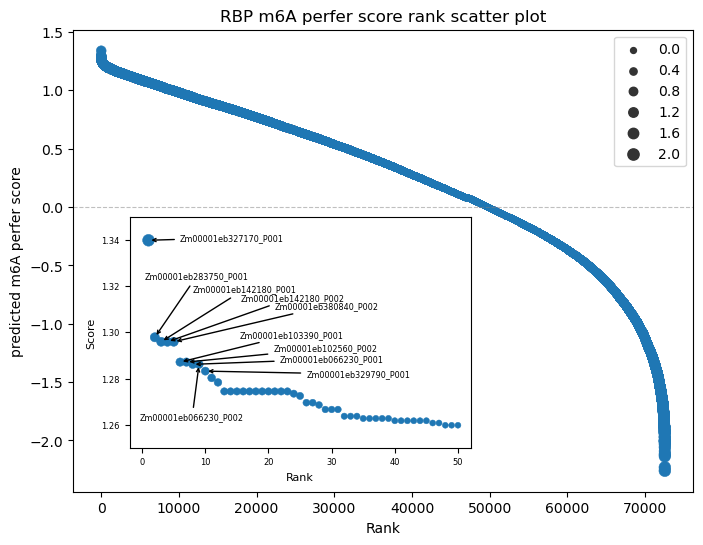

In [ ]:
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
matplotlib.rcParams['pdf.fonttype'] = 42

fig = plt.figure(figsize=(8, 6))
# ax1
ax1 = fig.add_subplot(1, 1, 1)
sns.scatterplot(data=df_for_plot, 
                x=df_for_plot.index + 1, 
                y=df_for_plot.predict_mps, 
                size=np.abs(df_for_plot.predict_mps),
                edgecolor=None,
                linewidths=0
                )
ax1.axhline(y=0, color='grey', linestyle='--', lw=0.8, alpha=0.5)
ax1.set_xlabel("Rank")
ax1.set_ylabel("predicted m6A perfer score")
ax1.set_title("RBP m6A perfer score rank scatter plot")
ax1.legend(loc="upper right")

# Create a local enlargement drawing
ax_inset = inset_axes(ax1, width="50%", height="50%", loc='lower left', 
                        bbox_to_anchor=[0.08, 0.08, 1.1, 1], bbox_transform=ax1.transAxes)
#
df_mps_top = df_for_plot.head(n=50)
sns.scatterplot(
    data=df_mps_top,
    x=df_mps_top.index + 1,
    y=df_mps_top.predict_mps,
    size=np.abs(df_mps_top.predict_mps),
    linewidths=0,
    edgecolor=None,
    ax=ax_inset,
    legend=None
)
ax_inset.set_xlim(-2, 52)
ax_inset.set_ylim(1.25, 1.35)
ax_inset.set_xlabel("Rank", fontsize=8)
ax_inset.set_ylabel("Score", fontsize=8)
ax_inset.tick_params(axis='both', which='major', labelsize=6)

# The top 10 proteins with the highest scores are labeled
# for pro_idx in list(range(11)):
#     ax_inset.annotate(f'{"|".join([df_mps_top.protein_id[pro_idx].split("|")[i] for i in [0, 3]])}', (df_mps_top.index[pro_idx]+1, df_mps_top.predict_mps[pro_idx]), 
#                 xytext=(50, 15), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{df_mps_top.protein_id[0].split("|")[3]}', (df_mps_top.index[0]+1, df_mps_top.predict_mps[0]), 
                xytext=(60, 0), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{df_mps_top.protein_id[1].split("|")[3]}', (df_mps_top.index[1]+1, df_mps_top.predict_mps[1]), 
                xytext=(30, 42), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{df_mps_top.protein_id[2].split("|")[3]}', (df_mps_top.index[2]+1, df_mps_top.predict_mps[2]), 
                xytext=(60, 36), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{df_mps_top.protein_id[3].split("|")[3]}', (df_mps_top.index[3]+1, df_mps_top.predict_mps[3]), 
                xytext=(90, 30), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{df_mps_top.protein_id[4].split("|")[3]}', (df_mps_top.index[4]+1, df_mps_top.predict_mps[4]), 
                xytext=(110, 24), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{df_mps_top.protein_id[5].split("|")[3]}', (df_mps_top.index[5]+1, df_mps_top.predict_mps[5]), 
                xytext=(80, 18), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{df_mps_top.protein_id[6].split("|")[3]}', (df_mps_top.index[6]+1, df_mps_top.predict_mps[6]), 
                xytext=(100, 8), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{df_mps_top.protein_id[7].split("|")[3]}', (df_mps_top.index[7]+1, df_mps_top.predict_mps[7]), 
                xytext=(100, 2), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{df_mps_top.protein_id[8].split("|")[3]}', (df_mps_top.index[8]+1, df_mps_top.predict_mps[8]), 
                xytext=(-5, -40), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax_inset.annotate(f'{df_mps_top.protein_id[9].split("|")[3]}', (df_mps_top.index[9]+1, df_mps_top.predict_mps[9]), 
                xytext=(110, -4), textcoords='offset points', ha='center', size="xx-small", arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))

# plt.savefig("all_Zea_mays_proteins_max_predicted_m6A_perfer_score_rank_scatter_plot.pdf")
plt.show()


# Prediction of m6A preference score for random polypeptide sequences (300AA)

In [ ]:
%%bash 
cat /dev/urandom |tr -dc 'ACGT' | fold -w 101 |head -n 10

# Generate random polypeptide sequences (300AA; 10k,1m,1b)
cat /dev/urandom |tr -dc 'ACDEFGHIKLMNPQRSTVWY' | fold -w 300 |head -n 10000 >random_AAstr_L300.1w.txt
cat /dev/urandom |tr -dc 'ACDEFGHIKLMNPQRSTVWY' | fold -w 300 |head -n 1000000 >random_AAstr_L300.1m.txt
cat /dev/urandom |tr -dc 'ACDEFGHIKLMNPQRSTVWY' | fold -w 300 |head -n 1000000000 >random_AAstr_L300.1b.txt
# The files 'random_AAstr_L300.1w.txt' and 'random_AAstr_L300.1m.txt' were created merely for testing the subsequent code.


GCATGTTGGGCTTACATTCCTCAGTGCTTACCAGACGACCCAGCCATTTTTGTGACTGTACACTACGCCACACTTGCTTCTCAAAATGTAGAGACGTTTGA
GCTCACTTGGGACGGGGGGGAGGCCAGGCTGATGTTTGGTATGCATCTTATAGCCTGAGCTCCCTCGAGGAATCCAGAAACGTAGCAAATCTTTCAGCAAA
AGCTGGCGCCACCAGGTCCCCCAAAGTTGGACAAGAGATTTCGCAGTAATAAATGCTGCGCAAAGACAGCGGTCAAGGTGTCTACTCGTCCGCAGTAAATG
GAGTCACTACCTCTTGTAAGACTGTGCCCTATTTTGTTTTCAAGTATCCATCATGGGCTGTCATGGCCACTGTGGAATATGTAGCTATAGGATTATGTGCC
TACCTCGCCGTAAAATGTCCAATAACTGTCGAAGCTCTATACCCGTGAAAAAAGCTATAAGGGCAAGCTCAGGTCCGATGAGAAAGGTTCTCGTCCCGCGA
AGTCTCCTTTAGAAGTCACAATTCCCTGCTCCCACATCTTGACAGTCGCTGTGCTATTCAGCGTACACCAGCCGCTAACGGAGCGCTTATAAACGTATACA
GGTGTCCCGATGCTCTATCTCGCCCCATTTTTAGGCCACTGATGCTCCATTCTACCCTATGGAAGAGGATCCTCGTACCGCGGGTCTGGGGCTTGATGAAC
GATGGACGAGGAATAACCAGGACAATTCAGAGCTTTGTTACGTCGAATAGCGGGTTTGTGTCTCGCTCAAATCTAACATCGGTTGATAGAGCGCTACTCGC
GATCCGAGCTATTCTTGCGAGTATGATAGGGTCACGAACAGTCTTAGAAGTAATCGCGTGAAAAAGGGCTTGCCAGGTTAGATCCCTACGCCTGCTGTGCG
TGTAAATATTTGTATATTAGCTAGAAGCTCTACCTTACGTGAGCATCCGCCCCTCATGCATACGCAGTTTCTTGTAGGCTGG

## Predict each sequence using the sequence batch generator method

In [ ]:
import numpy as np
import tensorflow as tf
from keras.utils import to_categorical
from keras.models import model_from_json
# Enable automatic mixed precision
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Load the CNN model
model_path = "RBP_m6A_preference_CNN_model_DeepPScan"
keras_model_json = model_path + '.json'
keras_model_weights = model_path + '.h5'
keras_model = model_from_json(open(keras_model_json).read())
keras_model.load_weights(keras_model_weights)


def one_hot_encode(sequence, max_length=300):
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
    encoded = to_categorical([amino_acids.index(aa) for aa in sequence], num_classes=len(amino_acids), dtype="float32")
    if len(encoded) < max_length:
        encoded = np.pad(encoded, ((0, max_length - len(encoded)), (0, 0)), 'constant')
    return encoded


def sequence_generator(input_AAseq_file_path, batch_size=1024):
    sequences = []
    with open(input_AAseq_file_path, "rt") as RANDOM_AA_IN:
        for line in RANDOM_AA_IN:
            aa300_str = line.rstrip()
            sequences.append(aa300_str)
            if len(sequences) == batch_size:
                batch_sequences = [one_hot_encode(seq) for seq in sequences]
                yield np.array(batch_sequences), sequences
                sequences = []
    if sequences:  # Yield the remaining sequences
        batch_sequences = [one_hot_encode(seq) for seq in sequences]
        yield np.array(batch_sequences), sequences


def predict_sequences(generator, model, output_file):
    with open(output_file, "wt") as PREOUT:
        for X, sequences in generator:
            predict_mps = model.predict(X).flatten().tolist()
            for aa_str, predict_mps in zip(sequences, predict_mps):
                print(aa_str, predict_mps, sep="\t", end="\n", file=PREOUT)

# test prediction of the 10k random sequences
random_AA300_seqStr_file = "random_AAstr_L300.1w.txt"
random_AA300_seqStr_with_predict_mps = "random_AAstr_L300.1w.with_predict_mps.txt"
predict_sequences(sequence_generator(random_AA300_seqStr_file, batch_size=5120), keras_model, random_AA300_seqStr_with_predict_mps)
# 1.8s


In [ ]:
# test prediction of the 10k random sequence with different batch size
random_AA300_seqStr_file = "random_AAstr_L300.1w.txt"
random_AA300_seqStr_with_predict_mps = "random_AAstr_L300.1w.with_predict_mps.txt"
predict_sequences(sequence_generator(random_AA300_seqStr_file, batch_size=10240), keras_model, random_AA300_seqStr_with_predict_mps)
# 1.7s

In [ ]:
# test prediction of the 1m random sequence
random_AA300_seqStr_file = "random_AAstr_L300.1m.txt"
random_AA300_seqStr_with_predict_mps = "random_AAstr_L300.1m.with_predict_mps.txt"
predict_sequences(sequence_generator(random_AA300_seqStr_file, batch_size=5120), keras_model, random_AA300_seqStr_with_predict_mps)
# 2m35s

In [ ]:
# prediction of the 1b random sequence
random_AA300_seqStr_file = "random_AAstr_L300.1b.txt"
random_AA300_seqStr_with_predict_mps = "random_AAstr_L300.1b.with_predict_mps.txt"
predict_sequences(sequence_generator(random_AA300_seqStr_file, batch_size=5120), keras_model, random_AA300_seqStr_with_predict_mps)
# 2246m20s
# ~37.5h

In [ ]:
%%bash
# Test of sorting results for 10k random sequences prediction
time sort -T ./  -k2,2gr random_AAstr_L300.1w.with_predict_mps.txt >random_AAstr_L300.1w.with_predict_mps.sorted.txt
head random_AAstr_L300.1w.with_predict_mps.sorted.txt 
# 7s

NKSEIHMPISNGRFCRQCSNVYPMPTRVTRQDCYCRGTFDLSFESDTWHGRYKPKPWYWVIIFWFFTHIFCFFRIFLAEPDEVYCGGLIRGKKEKCYASEYADIAHEITYQDGDAPGCGPVHHHHPLFMIEGVKQTLQNRYLETAPMNWVHRTPYMSEKHDFQILCRCINLESQTRKTKCNCACTEIWNAPQIFGMPIQIAEISKARVVGMHHAYKRHSTLSFFKYCTHCALIYHFFDHIFMGMCWLTNAVSMPSHGCHQPESDMASPTNPFSDFKECMHGTMWIEPDMTDHMRPWELRF	1.2353515625
WIHLWLVNQVTFDNDKSCYELLLYTHWCMVVTFIKWAAEEKWPAHCNRRFNAEQVLCKVNMRALPIHIMQQIFCCPCFQVAMHGVRQNQVLEGTHVFQDIEMNFMHHAQMSRKATFNNYKAASRGYSSKLTDLCFGHWVFHSFCTDHYLVVMYACCEFHLKYLFFQSVQGEEHGHFGDPTETMADYWYRTPPRPVNFFTYGFCTPEWFHVTLRFKTEEYNFGVYSIIIKMSHFVTNAHCMHVVVIKTCTDQIIPCHMEDLHRIEIAHREILSDVVDKFLSGIETGHKTPFNALVMISNPY	1.1240234375
PNCWSTCFEHHWRKPFFGCKYHSHPYNWIINFRWDQMRYRNNLSHRWTWVWVHGAPPALVVFPEYAHVFAGRKGRHHHIPGHWHPWITLIADRADEKMNQVLEFLDQAKREHKFAPHWPTLANMACLGQKGHLLLYIPCIFVNSGAGYRCKRMMCLKSPRWCTYERANKVHYNCWFTVVHVWMQTMENPTQKVQCHEPPPNGDDYCADMHVSPVYDAVQRPTMVWAKIKCKAEHYELGCGQVQGPMYIQKNTDLMVIVHGQEHEQCCHEYKQSMMEDVYIDWNVGWSICMGLHHMMTQMN	1.1171875
RCGGPNFMEKETENDLVLEITNQEKYMEFHIKGPKETTGNLTRFLKRSWHVTCLYCAIPFN


real	0m0.491s
user	0m0.289s
sys	0m0.020s


In [ ]:
%%bash
# Test of sorting results for 1m random sequences prediction
time sort -T ./ -k2,2gr random_AAstr_L300.1m.with_predict_mps.txt >random_AAstr_L300.1m.with_predict_mps.sorted.txt
head random_AAstr_L300.1m.with_predict_mps.sorted.txt
# 30s

MGFHWMPYAANENGINHDVHFCDNCSDETPVYKKGQVIRAQMDGRQDDYRVLFCGAYSKHKDALDPDRIKYGMMMQIPFAELFMGGQCEITDPVCLSRFLVEEMTDLYSFNQMKDIIVRRGVFINDWQHNTIHYPATRWPQMGHEKDMGFHNIEINMDVHDDDVAIRFSNSCFDPSCDPPTRIVTVTPVHPPPIFHMPKIVIDVCCNIEDGHHMVQNQMNDVQMFLFFENQMVSWFHVIKWRQQEGYILGHHLTREWMNGVITEGTCAGNSQLIHISHHIRQQRRDFKANPHDQMYNHIL	1.318359375
FIEAAPPMHSQIEGNARNQMICPRDSHHCFPEQLYLHTNQLVIQNLSYSRVAVTLLLGHRLFLTYEHNIDGIYWGNAENRVKDDDFNCYWLLSRIMKRHRYEARSLTKSTNSYILFNAGQGQDRQVPIHAHIQWWHEPLHFVCVQTCKTVASPQAAYGQLLVTWNQTKPHHFLPDHGIRDPMIFIHDERHVPAPLGSRPLMAVSWIFVLPTNCLMHKQWHRSWFACENHKRHMGVLWCFGRPYHDTSLTYMPCNTICPYLDYHLWYANFMLLKQRHVAVPDHTHMWMSKNWQVQFIVSMD	1.28125
CPTVWMLDLYTCLRLHTNFRHIHHAHYVLAKSSRDEDSECAYHFKFNFGFCSRFFTEAYMTEPVIKRRGVRQGKAVTKNYWHHREIQWHLLYAHWCIDNHWCLSKYAIPLQVRYTVTKHHMIHAVHEFEMAITPMKKYQDHSDYQYVEYDRDDGMPGSRRAHAHIQCNIHDRKPAWYSHFESEPFTPRRQYGFTCYVSQNDIDQAVRLHVMVGLCKCMESHNHNPYDQFFQTCINKFTSYFISNAFYCSLFCCGGRQTWDLSKLKPVMWRTAEMMNAMGDMVMCQHTGASNNHPWISRKK	1.2734375
GWQNMAVSVSIRPWKDKDEQCSDMCFYVIQITVDFCVEAAHDQGYWAFAQRCTKPYLNKKRNMVYMK


real	0m31.197s
user	0m42.629s
sys	0m1.405s


In [ ]:
%%bash
# sorted the prediction results of one billion random sequences
time sort -T ./ -k2,2gr random_AAstr_L300.1b.with_predict_mps.txt >random_AAstr_L300.1b.with_predict_mps.sorted.txt
head random_AAstr_L300.1b.with_predict_mps.sorted.txt 

# The top 100 sequences with the highest scores were used for subsequent screening and synthesis.
head -n 100 random_AAstr_L300.1b.with_predict_mps.sorted.txt >random_AAstr_L300.1b.with_predict_mps.sorted.top100.txt
